<a href="https://colab.research.google.com/github/beverly0005/ppg_project/blob/main/ppg_segmentation_bw_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Modify the 1-second segmentation method:
    + Use paper peak detection and point detection to identify systolic, diastolic peaks and diastolic points
    + No fixed window size for the initial window extraction: need to include the starting diastolic point of systolic peak, and the ending diastolic point of diastolic peak
    + Use Guassian function fitting to verify if the extracted window is eligible [*Zhang et al*: *A Noninvasive Blood Glucose Monitoring System Based on Smartphone PPG Signal Processing and Machine Learning*]
2. Correct typo of Gaussian function:
    + Using half-width of Gaussian curve
    + Remove bounding from the fitting function
    + Fitted parameters need to be positive
3. Modify R squared in Gaussian function to LSE according to Zhang's paper
5. Directly cut into 1-second window from 16 minutes


# Install and Import Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.spatial.distance import cosine
from scipy.optimize import curve_fit
from pathlib import Path
from tqdm import tqdm
import warnings
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# User-Defined Parameters

In [3]:
DATAPATH = 'drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/'
PROCESSPATH = 'drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_10s_windows/'
OUTPUT_PATH1 = 'drive/MyDrive/2025_PPG_GLUC/Data/Final Data/1s_segmentation_newproc_bw_v1/'
OUTPUT_PATH2 = 'drive/MyDrive/2025_PPG_GLUC/Data/Final Data/1s_segmentation_newproc_gaussian_bw_v1/'

if not os.path.exists(OUTPUT_PATH1):
    os.makedirs(OUTPUT_PATH1)

if not os.path.exists(OUTPUT_PATH2):
    os.makedirs(OUTPUT_PATH2)

# Signal parameters
FS = 100  # Sampling frequency (Hz)
WINDOW_SIZE = 120  # 1 second = 100 samples
WINDOW_BEFORE = 50
WINDOW_AFTER = 50

# Thresholds from paper
HEIGHT_THRESHOLD = 20
DISTANCE_THRESHOLD = int(0.8 * FS)  # 0.8s min between peaks
SIMILARITY_THRESHOLD = 0.85

# New parameters for diastolic detection
MAX_WINDOW_SIZE = 150  # Maximum window size to allow for flexibility
DIASTOLIC_SEARCH_WINDOW = int(0.5 * FS)

LSE_THRESHOLD = 1.5

# Process Data

In [4]:
# Get all filtered files
ppg_files = sorted(Path(DATAPATH).glob('case_*_filtered.npy'))
print(f"Found {len(ppg_files)} files to process\n")

Found 7300 files to process



## Prepare Mini-Functions

### Guassian Fitting Function

In [ ]:
def gaussian(x, amplitude, n_peak, w):
    return amplitude * np.exp(-2*((x - n_peak) ** 2) / (w ** 2))

def double_gaussian(x, H1, n1, W1, H2, n2, W2):
    return gaussian(x, H1, n1, W1) + gaussian(x, H2, n2, W2)

def validate_gaussian_fit(window, systolic_idx, diastolic_idx, window_start,
                          lse_threshold=LSE_THRESHOLD):
    """Validate using Gaussian fitting and return parameters"""
    x = np.arange(len(window))
    window_norm = (window - np.min(window)) / (np.max(window) - np.min(window) + 1e-8)
    # Need to process to make min greater than 0 in order to fit Gaussian

    initial_guess = [
        window_norm[systolic_idx-window_start], systolic_idx-window_start, 8,
        window_norm[diastolic_idx-window_start], diastolic_idx-window_start, 10
    ]

    try:
        params, _ = curve_fit(double_gaussian, x, window_norm, p0=initial_guess)
        H1, n1, W1, H2, n2, W2 = params

        fitted = double_gaussian(x, *params)
        ss_res = np.sum((window_norm - fitted) ** 2)
        ss_tot = np.sum(window_norm ** 2)
        lse = ss_res/ss_tot * 100

        # Validation
        if lse > LSE_THRESHOLD:
            return False, None
        if W1 <=0 or W2 <=0 or H1 <=0 or H2 <= 0 or n1 <= 0 or n2 <= 0:
            return False, None
        if H1 <= H2:
            return False, None
        if n1 >= n2:
            return False, None

        # Return parameters for valid segments
        return True, {'H1': H1, 'n1': n1, 'W1': W1, 'H2': H2, 'n2': n2, 'W2': W2, 'lse': lse}

    except:
        return False, None

### Peak and Point Detection

In [ ]:
def detect_peaks(ppg_signal, height_threshold=HEIGHT_THRESHOLD,
                 distance_threshold=DISTANCE_THRESHOLD):
    peaks = []
    for i in range(1, len(ppg_signal) - 1):
        if ppg_signal[i-1] < ppg_signal[i] > ppg_signal[i+1]:
            if ppg_signal[i] > height_threshold:
                if len(peaks) == 0 or i - peaks[-1] > distance_threshold:
                    peaks.append(i)
    return peaks

In [ ]:
def detect_all_points(ppg_signal, height_threshold=HEIGHT_THRESHOLD,
                 distance_threshold=DISTANCE_THRESHOLD):
    # Systolic peaks
    systolic_peaks = detect_peaks(ppg_signal, height_threshold, distance_threshold)

    # All peaks
    all_peaks = detect_peaks(ppg_signal, height_threshold=min(ppg_signal), distance_threshold=0)

    # All diastolic points
    all_diastolic_points = detect_peaks(-ppg_signal, height_threshold=min(-ppg_signal), distance_threshold=0)

    return systolic_peaks, all_peaks, all_diastolic_points



### Extract Windows
- Only keep windows that contain exactly 1 peak
- window_size adaptable: Ensure only starts and ends of the systolic and the diastolic peaks are included
- Returns: list of valid windows (windows)

In [ ]:
def extract_windows(ppg_signal, systolic_peaks, all_peaks, all_diastolic_points,
                    window_size=WINDOW_SIZE):
    windows = []
    systolic_peaks_pt = []
    diastolic_peaks_pt = []
    window_starts_pt = []
    window_ends_pt = []
    for systolic_peak in systolic_peaks:

        # Detect start of systolic peak: add zero to the list
        tmp_starts_systolic = [0] + [i for i in all_diastolic_points if i < systolic_peak]
        window_start = max(tmp_starts_systolic)

        # Detect diastolic peak
        tmp_peaks = [i for i in all_peaks if i > systolic_peak]
        if len(tmp_peaks) == 0:
            continue
        diastolic_peak = min(tmp_peaks)

        # Detect end of diastolic peak
        tmp_ends_diastolic = [i for i in all_diastolic_points if i > diastolic_peak]
        if len(tmp_ends_diastolic) == 0:
            continue
        window_end = min(tmp_ends_diastolic)

        # Validation
        if ppg_signal[diastolic_peak] >= ppg_signal[systolic_peak]:
            continue

        window = ppg_signal[window_start:window_end]
        if len(window) > window_size or np.any(np.isnan(window)):
            continue

        peak_count = count_peaks_in_window(window, HEIGHT_THRESHOLD)
        if peak_count == 1:
            windows.append(window)
            systolic_peaks_pt.append(systolic_peak)
            diastolic_peaks_pt.append(diastolic_peak)
            window_starts_pt.append(window_start)
            window_ends_pt.append(window_end)
    return windows, systolic_peaks_pt, diastolic_peaks_pt, window_starts_pt, window_ends_pt

### Count Peaks in Window

In [ ]:
def count_peaks_in_window(window, height_threshold):

    count = 0

    for i in range(1, len(window) - 1):
        if window[i-1] < window[i] > window[i+1]:
            if window[i] > height_threshold:
                count += 1

    return count

## Process and Extract Windows

In [ ]:
def process_file_extract_params(ppg_signal, window_size=WINDOW_SIZE):
    """Process file and extract Gaussian parameters for all valid segments"""
    # Extract all windows
    systolic_peaks, all_peaks, all_diastolic_points = detect_all_points(
        ppg_signal, height_threshold=HEIGHT_THRESHOLD,
        distance_threshold=DISTANCE_THRESHOLD)
    (windows, systolic_peaks_pt, diastolic_peaks_pt, window_starts_pt,
    window_ends_pt) = extract_windows(
        ppg_signal, systolic_peaks, all_peaks, all_diastolic_points,
        window_size)

    # Validation
    if len(windows) == 0:
        print('No selected windows')
        return [], [], []

    # Gaussian fitting and parameter extraction
    param_records = []
    padded_windows1 = []  # Based on peaks and point of original waveform
    padded_windows2 = []  # Based on Gaussian fitting curve points
    for i in range(len(windows)):
        is_valid, params = validate_gaussian_fit(
            windows[i], systolic_peaks_pt[i], diastolic_peaks_pt[i],
            window_starts_pt[i])
        if is_valid:
            record = params.copy()
            param_records.append(record)
            window = windows[i]

            # Window 1: Filter valid windows based on valid Gaussian functions
            padded_window1 = np.array(window.tolist() + [
                0 for i in range(window_size - len(window))])
            padded_windows1.append(padded_window1)

            # Window 2: Modify the window start and end:
            # Start: systolic peak - 2 W1
            # End: diastolic peak + 2 W2
            n1, W1, n2, W2 = (int(params['n1']), int(params['W1']),
                              int(params['n2']), int(params['W2']))
            mod_window = window[max(0, n1-W1*2): min(window_size, n2+W2*2)]
            padded_window2 = np.array(mod_window.tolist() + [
                0 for i in range(window_size - len(mod_window))])
            padded_windows2.append(padded_window2)

    return param_records, padded_windows1, padded_windows2

# Run All 1-Second Segmentation Process

In [ ]:
# Set paths
input_path = Path(DATAPATH)
output_path1 = Path(OUTPUT_PATH1)
output_path2 = Path(OUTPUT_PATH2)

# Get all filtered files
ppg_files = sorted(input_path.glob('case_*_filtered.npy'))
print(f"Found {len(ppg_files)} files to process")

ppg_files_created = os.listdir(output_path1)

# Process all files with local templates
results = []
meta_df = pd.DataFrame()
for file in tqdm(ppg_files):
    # Make filename: Extract caseid and glucose_time from filename
    # Parse from filename format like 'case_1001_time_2625_filtered.npy'
    filename = file.name
    if 'case_' in filename and '_time_' in filename:
        parts = filename.split('_')
        if len(parts) >= 4:
            try:
                caseid = int(parts[1])  # Extract '1001' from 'case_1001_time_2625_filtered.npy'
                glucose_time = int(parts[3])  # Extract '2625' from 'case_1001_time_2625_filtered.npy'
                new_filename = f'case_{caseid}_time_{glucose_time}_1s_segment.npy'
            except ValueError:
                pass  # If conversion fails, keep None values
    else:
        continue

    # Check if the file already created or not
    if new_filename in ppg_files_created:
        continue

    # Process
    ppg_signal = np.load(file)
    param_records, padded_windows1, padded_windows2 = process_file_extract_params(
        ppg_signal, window_size=WINDOW_SIZE)

    if len(padded_windows1) == 0:
        print(f'{filename}: No Valid Windows')
        continue
    else:
        # Update meta
        meta_df = pd.concat([meta_df,
                              pd.DataFrame({'filename': [new_filename],
                                            'len': [len(padded_windows1)],
                                            'param_records': [param_records]})])
        # Save
        np.save(output_path1 / new_filename, np.array(padded_windows1))
        np.save(output_path2 / new_filename, np.array(padded_windows2))

# Save metadata
meta_df.to_excel(output_path1 / 'metadata_gaussian.xlsx', index=False)
meta_df.to_excel(output_path2 / 'metadata_gaussian.xlsx', index=False)

Found 7300 files to process


  0%|          | 12/7300 [00:15<1:41:41,  1.19it/s]

case_1004_time_8012_filtered.npy: No Valid Windows


  0%|          | 23/7300 [00:46<6:23:16,  3.16s/it]

No selected windows
case_1016_time_11496_filtered.npy: No Valid Windows


  0%|          | 24/7300 [00:47<5:02:22,  2.49s/it]

case_1016_time_14104_filtered.npy: No Valid Windows


  0%|          | 25/7300 [00:48<3:53:10,  1.92s/it]

case_1016_time_8072_filtered.npy: No Valid Windows


  0%|          | 26/7300 [00:48<3:02:59,  1.51s/it]

No selected windows
case_1016_time_9642_filtered.npy: No Valid Windows


  0%|          | 31/7300 [00:52<1:40:43,  1.20it/s]

case_101_time_2370_filtered.npy: No Valid Windows


  0%|          | 32/7300 [00:53<2:03:39,  1.02s/it]

No selected windows
case_101_time_9508_filtered.npy: No Valid Windows


  1%|          | 43/7300 [01:22<3:23:42,  1.68s/it]

No selected windows
case_1026_time_11873_filtered.npy: No Valid Windows


  1%|          | 46/7300 [01:24<2:08:18,  1.06s/it]

No selected windows
case_1027_time_4171_filtered.npy: No Valid Windows


  1%|          | 47/7300 [01:25<1:55:03,  1.05it/s]

No selected windows
case_1027_time_9892_filtered.npy: No Valid Windows


  1%|          | 71/7300 [02:48<5:55:11,  2.95s/it]

case_1039_time_7228_filtered.npy: No Valid Windows


  1%|          | 76/7300 [02:54<2:48:38,  1.40s/it]

No selected windows
case_1041_time_3729_filtered.npy: No Valid Windows


  1%|          | 80/7300 [03:04<3:31:08,  1.75s/it]

No selected windows
case_1044_time_8182_filtered.npy: No Valid Windows


  1%|          | 83/7300 [03:13<4:14:23,  2.11s/it]

case_1046_time_6886_filtered.npy: No Valid Windows


  1%|          | 88/7300 [03:25<5:06:00,  2.55s/it]

No selected windows
case_104_time_4193_filtered.npy: No Valid Windows


  1%|▏         | 108/7300 [04:12<3:04:02,  1.54s/it]

No selected windows
case_1069_time_23519_filtered.npy: No Valid Windows


  2%|▏         | 131/7300 [05:08<4:15:44,  2.14s/it]

No selected windows
case_1089_time_8674_filtered.npy: No Valid Windows


  2%|▏         | 135/7300 [05:20<5:16:53,  2.65s/it]

No selected windows
case_1091_time_4088_filtered.npy: No Valid Windows


  2%|▏         | 136/7300 [05:21<4:08:47,  2.08s/it]

No selected windows
case_1091_time_6049_filtered.npy: No Valid Windows


  2%|▏         | 138/7300 [05:22<2:37:22,  1.32s/it]

No selected windows
case_1091_time_8965_filtered.npy: No Valid Windows


  2%|▏         | 141/7300 [05:29<3:22:22,  1.70s/it]

No selected windows
case_1094_time_11946_filtered.npy: No Valid Windows


  2%|▏         | 142/7300 [05:29<2:41:30,  1.35s/it]

No selected windows
case_1094_time_18129_filtered.npy: No Valid Windows


  2%|▏         | 143/7300 [05:30<2:17:16,  1.15s/it]

No selected windows
case_1094_time_21205_filtered.npy: No Valid Windows


  2%|▏         | 146/7300 [05:33<2:07:55,  1.07s/it]

No selected windows
case_1095_time_24041_filtered.npy: No Valid Windows


  2%|▏         | 151/7300 [05:42<2:47:13,  1.40s/it]

No selected windows
case_1098_time_2080_filtered.npy: No Valid Windows


  2%|▏         | 152/7300 [05:42<2:13:22,  1.12s/it]

No selected windows
case_1098_time_5909_filtered.npy: No Valid Windows


  2%|▏         | 158/7300 [05:55<3:54:46,  1.97s/it]

No selected windows
case_1103_time_3578_filtered.npy: No Valid Windows


  2%|▏         | 163/7300 [06:10<5:13:44,  2.64s/it]

No selected windows
case_1109_time_8129_filtered.npy: No Valid Windows


  2%|▏         | 165/7300 [06:12<3:17:52,  1.66s/it]

No selected windows
case_1113_time_12320_filtered.npy: No Valid Windows


  2%|▏         | 180/7300 [06:56<4:04:45,  2.06s/it]

No selected windows
case_1123_time_16963_filtered.npy: No Valid Windows


  3%|▎         | 194/7300 [07:42<4:02:53,  2.05s/it]

No selected windows
case_1131_time_3178_filtered.npy: No Valid Windows


  3%|▎         | 195/7300 [07:43<3:16:36,  1.66s/it]

case_1131_time_7806_filtered.npy: No Valid Windows


  3%|▎         | 206/7300 [08:10<2:54:53,  1.48s/it]

No selected windows
case_1144_time_5461_filtered.npy: No Valid Windows


  3%|▎         | 208/7300 [08:11<2:10:56,  1.11s/it]

No selected windows
case_1144_time_8969_filtered.npy: No Valid Windows


  3%|▎         | 214/7300 [08:20<2:10:21,  1.10s/it]

No selected windows
case_1157_time_13451_filtered.npy: No Valid Windows


  3%|▎         | 215/7300 [08:21<2:06:20,  1.07s/it]

No selected windows
case_1157_time_17036_filtered.npy: No Valid Windows


  3%|▎         | 216/7300 [08:21<1:47:38,  1.10it/s]

case_1157_time_18699_filtered.npy: No Valid Windows


  3%|▎         | 217/7300 [08:22<1:34:13,  1.25it/s]

No selected windows
case_1157_time_19670_filtered.npy: No Valid Windows


  3%|▎         | 218/7300 [08:23<1:43:24,  1.14it/s]

No selected windows
case_1157_time_25393_filtered.npy: No Valid Windows


  3%|▎         | 221/7300 [08:25<1:50:31,  1.07it/s]

No selected windows
case_1157_time_3854_filtered.npy: No Valid Windows


  3%|▎         | 225/7300 [08:33<2:50:02,  1.44s/it]

No selected windows
case_1160_time_14225_filtered.npy: No Valid Windows


  3%|▎         | 236/7300 [08:56<2:59:18,  1.52s/it]

No selected windows
case_116_time_8408_filtered.npy: No Valid Windows


  3%|▎         | 253/7300 [09:42<4:33:49,  2.33s/it]

No selected windows
case_1184_time_2685_filtered.npy: No Valid Windows


  3%|▎         | 254/7300 [09:42<3:31:23,  1.80s/it]

No selected windows
case_1184_time_2992_filtered.npy: No Valid Windows


  4%|▎         | 256/7300 [09:45<2:51:17,  1.46s/it]

No selected windows
case_1185_time_3307_filtered.npy: No Valid Windows


  4%|▎         | 257/7300 [09:45<2:20:08,  1.19s/it]

No selected windows
case_1186_time_4516_filtered.npy: No Valid Windows


  4%|▎         | 260/7300 [09:57<4:31:10,  2.31s/it]

case_1189_time_13817_filtered.npy: No Valid Windows


  4%|▎         | 266/7300 [10:02<1:43:34,  1.13it/s]

case_118_time_24028_filtered.npy: No Valid Windows


  4%|▎         | 267/7300 [10:02<1:30:54,  1.29it/s]

No selected windows
case_118_time_27100_filtered.npy: No Valid Windows


  4%|▎         | 269/7300 [10:09<3:36:24,  1.85s/it]

No selected windows
case_118_time_9205_filtered.npy: No Valid Windows


  4%|▍         | 284/7300 [10:46<3:42:14,  1.90s/it]

No selected windows
case_1202_time_3221_filtered.npy: No Valid Windows


  4%|▍         | 285/7300 [10:47<3:09:33,  1.62s/it]

case_1203_time_3382_filtered.npy: No Valid Windows


  4%|▍         | 286/7300 [10:48<2:34:43,  1.32s/it]

No selected windows
case_1203_time_5101_filtered.npy: No Valid Windows


  4%|▍         | 299/7300 [11:24<2:01:13,  1.04s/it]

No selected windows
case_1208_time_11012_filtered.npy: No Valid Windows


  4%|▍         | 300/7300 [11:25<2:04:56,  1.07s/it]

No selected windows
case_1208_time_16365_filtered.npy: No Valid Windows


  4%|▍         | 301/7300 [11:25<1:47:36,  1.08it/s]

case_1208_time_21309_filtered.npy: No Valid Windows


  4%|▍         | 302/7300 [11:26<1:34:29,  1.23it/s]

No selected windows
case_1208_time_24816_filtered.npy: No Valid Windows


  4%|▍         | 303/7300 [11:27<1:25:21,  1.37it/s]

No selected windows
case_1208_time_8285_filtered.npy: No Valid Windows


  4%|▍         | 312/7300 [11:50<4:29:32,  2.31s/it]

No selected windows
case_1212_time_5195_filtered.npy: No Valid Windows


  4%|▍         | 313/7300 [11:50<3:26:51,  1.78s/it]

No selected windows
case_1212_time_6312_filtered.npy: No Valid Windows


  4%|▍         | 319/7300 [11:56<1:55:00,  1.01it/s]

No selected windows
case_1215_time_17477_filtered.npy: No Valid Windows


  4%|▍         | 324/7300 [12:03<2:42:33,  1.40s/it]

No selected windows
case_1216_time_18835_filtered.npy: No Valid Windows


  4%|▍         | 326/7300 [12:05<2:07:12,  1.09s/it]

No selected windows
case_1216_time_27011_filtered.npy: No Valid Windows


  4%|▍         | 327/7300 [12:06<2:01:44,  1.05s/it]

No selected windows
case_1216_time_7545_filtered.npy: No Valid Windows


  5%|▍         | 331/7300 [12:13<2:42:58,  1.40s/it]

case_1221_time_11239_filtered.npy: No Valid Windows


  5%|▍         | 332/7300 [12:13<2:19:54,  1.20s/it]

No selected windows
case_1221_time_16056_filtered.npy: No Valid Windows


  5%|▍         | 338/7300 [12:23<2:36:47,  1.35s/it]

No selected windows
case_1225_time_3819_filtered.npy: No Valid Windows


  5%|▍         | 339/7300 [12:24<2:09:05,  1.11s/it]

No selected windows
case_1225_time_8057_filtered.npy: No Valid Windows


  5%|▍         | 343/7300 [12:30<2:19:22,  1.20s/it]

No selected windows
case_1230_time_16419_filtered.npy: No Valid Windows


  5%|▍         | 344/7300 [12:30<1:57:15,  1.01s/it]

No selected windows
case_1230_time_20563_filtered.npy: No Valid Windows


  5%|▍         | 349/7300 [12:39<2:30:33,  1.30s/it]

No selected windows
case_1234_time_5236_filtered.npy: No Valid Windows


  5%|▍         | 350/7300 [12:39<2:05:07,  1.08s/it]

No selected windows
case_1234_time_9048_filtered.npy: No Valid Windows


  5%|▍         | 351/7300 [12:40<1:52:17,  1.03it/s]

case_1236_time_1747_filtered.npy: No Valid Windows


  5%|▍         | 354/7300 [12:43<1:54:38,  1.01it/s]

No selected windows
case_1238_time_3516_filtered.npy: No Valid Windows


  5%|▍         | 357/7300 [12:48<2:44:47,  1.42s/it]

No selected windows
case_1240_time_3894_filtered.npy: No Valid Windows


  5%|▌         | 369/7300 [13:21<2:42:05,  1.40s/it]

No selected windows
case_125_time_11452_filtered.npy: No Valid Windows


  5%|▌         | 374/7300 [13:30<3:35:32,  1.87s/it]

case_1261_time_12319_filtered.npy: No Valid Windows


  5%|▌         | 375/7300 [13:31<2:49:50,  1.47s/it]

No selected windows
case_1261_time_15939_filtered.npy: No Valid Windows


  5%|▌         | 376/7300 [13:31<2:16:23,  1.18s/it]

No selected windows
case_1261_time_19564_filtered.npy: No Valid Windows


  5%|▌         | 378/7300 [13:33<1:56:20,  1.01s/it]

case_1261_time_7849_filtered.npy: No Valid Windows


  5%|▌         | 380/7300 [13:34<1:31:32,  1.26it/s]

No selected windows
case_1263_time_9541_filtered.npy: No Valid Windows


  5%|▌         | 381/7300 [13:35<1:21:58,  1.41it/s]

case_1264_time_5172_filtered.npy: No Valid Windows


  5%|▌         | 388/7300 [13:55<5:06:40,  2.66s/it]

No selected windows
case_126_time_2863_filtered.npy: No Valid Windows


  5%|▌         | 393/7300 [14:13<6:22:10,  3.32s/it]

case_1275_time_9375_filtered.npy: No Valid Windows


  5%|▌         | 397/7300 [14:20<3:50:26,  2.00s/it]

No selected windows
case_1279_time_10152_filtered.npy: No Valid Windows


  6%|▌         | 415/7300 [15:03<3:29:58,  1.83s/it]

No selected windows
case_1294_time_3913_filtered.npy: No Valid Windows


  6%|▌         | 416/7300 [15:03<2:50:33,  1.49s/it]

No selected windows
case_1297_time_3406_filtered.npy: No Valid Windows


  6%|▌         | 418/7300 [15:05<2:07:18,  1.11s/it]

No selected windows
case_1298_time_15304_filtered.npy: No Valid Windows


  6%|▌         | 420/7300 [15:07<2:11:11,  1.14s/it]

No selected windows
case_1298_time_9689_filtered.npy: No Valid Windows


  6%|▌         | 444/7300 [16:37<4:11:02,  2.20s/it]

No selected windows
case_1317_time_3077_filtered.npy: No Valid Windows


  6%|▌         | 445/7300 [16:38<3:15:14,  1.71s/it]

No selected windows
case_1319_time_5718_filtered.npy: No Valid Windows


  6%|▌         | 451/7300 [16:47<3:19:39,  1.75s/it]

No selected windows
case_1321_time_8582_filtered.npy: No Valid Windows


  6%|▋         | 465/7300 [17:16<2:24:02,  1.26s/it]

No selected windows
case_132_time_4771_filtered.npy: No Valid Windows


  6%|▋         | 466/7300 [17:17<2:05:57,  1.11s/it]

No selected windows
case_132_time_9084_filtered.npy: No Valid Windows


  6%|▋         | 467/7300 [17:18<1:59:19,  1.05s/it]

No selected windows
case_1331_time_10943_filtered.npy: No Valid Windows


  6%|▋         | 469/7300 [17:19<1:40:59,  1.13it/s]

No selected windows
case_1331_time_14879_filtered.npy: No Valid Windows


  6%|▋         | 472/7300 [17:22<1:30:34,  1.26it/s]

No selected windows
case_1333_time_12804_filtered.npy: No Valid Windows


  6%|▋         | 474/7300 [17:26<2:38:05,  1.39s/it]

No selected windows
case_1333_time_7029_filtered.npy: No Valid Windows


  7%|▋         | 479/7300 [17:39<4:11:23,  2.21s/it]

No selected windows
case_1338_time_5330_filtered.npy: No Valid Windows


  7%|▋         | 482/7300 [17:48<4:45:12,  2.51s/it]

No selected windows
case_1341_time_4655_filtered.npy: No Valid Windows


  7%|▋         | 497/7300 [18:25<3:37:50,  1.92s/it]

No selected windows
case_1353_time_8151_filtered.npy: No Valid Windows


  7%|▋         | 501/7300 [18:42<7:07:53,  3.78s/it]

case_1358_time_1998_filtered.npy: No Valid Windows


  7%|▋         | 516/7300 [19:21<4:42:14,  2.50s/it]

No selected windows
case_1374_time_11539_filtered.npy: No Valid Windows


  7%|▋         | 519/7300 [19:24<2:29:11,  1.32s/it]

No selected windows
case_1376_time_3793_filtered.npy: No Valid Windows


  7%|▋         | 529/7300 [20:03<5:18:56,  2.83s/it]

No selected windows
case_1392_time_10126_filtered.npy: No Valid Windows


  7%|▋         | 530/7300 [20:03<4:01:52,  2.14s/it]

No selected windows
case_1392_time_11975_filtered.npy: No Valid Windows


  7%|▋         | 531/7300 [20:04<3:07:49,  1.66s/it]

No selected windows
case_1392_time_4747_filtered.npy: No Valid Windows


  7%|▋         | 532/7300 [20:05<2:48:40,  1.50s/it]

No selected windows
case_1392_time_6637_filtered.npy: No Valid Windows


  7%|▋         | 533/7300 [20:06<2:19:02,  1.23s/it]

No selected windows
case_1392_time_8365_filtered.npy: No Valid Windows


  8%|▊         | 553/7300 [21:05<6:00:57,  3.21s/it]

No selected windows
case_1404_time_2756_filtered.npy: No Valid Windows


  8%|▊         | 554/7300 [21:06<4:36:37,  2.46s/it]

No selected windows
case_1404_time_7098_filtered.npy: No Valid Windows


  8%|▊         | 555/7300 [21:07<3:31:03,  1.88s/it]

No selected windows
case_1407_time_10804_filtered.npy: No Valid Windows


  8%|▊         | 564/7300 [21:14<1:28:17,  1.27it/s]

No selected windows
case_1407_time_8450_filtered.npy: No Valid Windows


  8%|▊         | 566/7300 [21:15<1:16:27,  1.47it/s]

No selected windows
case_1408_time_6583_filtered.npy: No Valid Windows


  8%|▊         | 567/7300 [21:16<1:14:12,  1.51it/s]

No selected windows
case_140_time_16739_filtered.npy: No Valid Windows


  8%|▊         | 593/7300 [22:25<6:09:54,  3.31s/it]

No selected windows
case_1428_time_8318_filtered.npy: No Valid Windows


  8%|▊         | 595/7300 [22:28<4:23:00,  2.35s/it]

No selected windows
case_142_time_9239_filtered.npy: No Valid Windows


  8%|▊         | 599/7300 [22:35<3:02:51,  1.64s/it]

No selected windows
case_1434_time_8375_filtered.npy: No Valid Windows


  8%|▊         | 611/7300 [23:08<3:25:12,  1.84s/it]

No selected windows
case_1444_time_12304_filtered.npy: No Valid Windows


  8%|▊         | 612/7300 [23:09<2:58:44,  1.60s/it]

No selected windows
case_1444_time_4794_filtered.npy: No Valid Windows


  8%|▊         | 613/7300 [23:09<2:23:38,  1.29s/it]

No selected windows
case_1444_time_6272_filtered.npy: No Valid Windows


  8%|▊         | 615/7300 [23:12<2:10:02,  1.17s/it]

No selected windows
case_1444_time_9969_filtered.npy: No Valid Windows


  8%|▊         | 618/7300 [23:25<5:36:55,  3.03s/it]

No selected windows
case_1448_time_1398_filtered.npy: No Valid Windows


  8%|▊         | 619/7300 [23:26<4:28:52,  2.41s/it]

No selected windows
case_1448_time_6554_filtered.npy: No Valid Windows


  9%|▊         | 621/7300 [23:29<3:11:05,  1.72s/it]

No selected windows
case_1451_time_5952_filtered.npy: No Valid Windows


  9%|▊         | 622/7300 [23:30<2:46:31,  1.50s/it]

No selected windows
case_1452_time_3959_filtered.npy: No Valid Windows


  9%|▊         | 626/7300 [23:35<2:13:14,  1.20s/it]

No selected windows
case_1456_time_4905_filtered.npy: No Valid Windows


  9%|▊         | 630/7300 [23:38<1:45:41,  1.05it/s]

No selected windows
case_145_time_3225_filtered.npy: No Valid Windows


  9%|▊         | 631/7300 [23:39<1:34:51,  1.17it/s]

No selected windows
case_145_time_7930_filtered.npy: No Valid Windows


  9%|▉         | 639/7300 [24:09<4:30:55,  2.44s/it]

No selected windows
case_1469_time_16980_filtered.npy: No Valid Windows


  9%|▉         | 641/7300 [24:13<3:46:47,  2.04s/it]

No selected windows
case_1469_time_25548_filtered.npy: No Valid Windows


  9%|▉         | 642/7300 [24:13<2:56:42,  1.59s/it]

No selected windows
case_1469_time_9951_filtered.npy: No Valid Windows


  9%|▉         | 644/7300 [24:25<6:02:13,  3.27s/it]

No selected windows
case_1471_time_1458_filtered.npy: No Valid Windows


  9%|▉         | 659/7300 [25:01<2:18:38,  1.25s/it]

case_1482_time_13390_filtered.npy: No Valid Windows


  9%|▉         | 664/7300 [25:05<1:33:35,  1.18it/s]

No selected windows
case_1487_time_4767_filtered.npy: No Valid Windows


  9%|▉         | 666/7300 [25:06<1:17:49,  1.42it/s]

case_1487_time_9335_filtered.npy: No Valid Windows


  9%|▉         | 667/7300 [25:06<1:12:18,  1.53it/s]

No selected windows
case_1488_time_4060_filtered.npy: No Valid Windows


  9%|▉         | 668/7300 [25:07<1:09:32,  1.59it/s]

No selected windows
case_1488_time_7598_filtered.npy: No Valid Windows


  9%|▉         | 685/7300 [26:08<4:23:15,  2.39s/it]

No selected windows
case_1493_time_13381_filtered.npy: No Valid Windows


  9%|▉         | 686/7300 [26:09<3:23:26,  1.85s/it]

No selected windows
case_1493_time_16364_filtered.npy: No Valid Windows


 10%|▉         | 704/7300 [27:06<3:27:00,  1.88s/it]

No selected windows
case_1511_time_10627_filtered.npy: No Valid Windows


 10%|▉         | 705/7300 [27:06<2:40:34,  1.46s/it]

No selected windows
case_1511_time_12489_filtered.npy: No Valid Windows


 10%|▉         | 706/7300 [27:08<2:31:18,  1.38s/it]

No selected windows
case_1511_time_14005_filtered.npy: No Valid Windows


 10%|▉         | 707/7300 [27:09<2:17:32,  1.25s/it]

No selected windows
case_1511_time_16155_filtered.npy: No Valid Windows


 10%|▉         | 710/7300 [27:11<1:50:22,  1.00s/it]

case_1511_time_7091_filtered.npy: No Valid Windows


 10%|▉         | 711/7300 [27:12<1:41:50,  1.08it/s]

No selected windows
case_1511_time_8701_filtered.npy: No Valid Windows


 10%|▉         | 720/7300 [27:39<3:37:24,  1.98s/it]

No selected windows
case_1515_time_4850_filtered.npy: No Valid Windows


 10%|▉         | 721/7300 [27:39<2:55:08,  1.60s/it]

No selected windows
case_1515_time_8976_filtered.npy: No Valid Windows


 10%|█         | 739/7300 [28:20<3:22:03,  1.85s/it]

No selected windows
case_1527_time_10908_filtered.npy: No Valid Windows


 10%|█         | 752/7300 [29:09<5:01:44,  2.76s/it]

No selected windows
case_1543_time_10430_filtered.npy: No Valid Windows


 10%|█         | 753/7300 [29:09<3:50:03,  2.11s/it]

No selected windows
case_1543_time_14441_filtered.npy: No Valid Windows


 10%|█         | 760/7300 [29:31<5:15:13,  2.89s/it]

No selected windows
case_1546_time_11893_filtered.npy: No Valid Windows


 10%|█         | 761/7300 [29:32<3:58:26,  2.19s/it]

No selected windows
case_1546_time_6111_filtered.npy: No Valid Windows


 10%|█         | 762/7300 [29:33<3:05:04,  1.70s/it]

No selected windows
case_1548_time_11923_filtered.npy: No Valid Windows


 10%|█         | 763/7300 [29:34<2:44:24,  1.51s/it]

No selected windows
case_1548_time_15669_filtered.npy: No Valid Windows


 10%|█         | 764/7300 [29:34<2:20:03,  1.29s/it]

No selected windows
case_1548_time_18466_filtered.npy: No Valid Windows


 10%|█         | 765/7300 [29:35<2:01:19,  1.11s/it]

No selected windows
case_1548_time_2005_filtered.npy: No Valid Windows


 10%|█         | 766/7300 [29:36<1:46:44,  1.02it/s]

No selected windows
case_1548_time_6062_filtered.npy: No Valid Windows


 11%|█         | 771/7300 [29:43<1:57:46,  1.08s/it]

No selected windows
case_1553_time_8920_filtered.npy: No Valid Windows


 11%|█         | 788/7300 [30:13<3:09:34,  1.75s/it]

No selected windows
case_1559_time_13834_filtered.npy: No Valid Windows


 11%|█         | 789/7300 [30:14<2:30:29,  1.39s/it]

No selected windows
case_1559_time_2240_filtered.npy: No Valid Windows


 11%|█         | 791/7300 [30:16<2:23:34,  1.32s/it]

No selected windows
case_1559_time_8103_filtered.npy: No Valid Windows


 11%|█         | 794/7300 [30:22<2:48:00,  1.55s/it]

No selected windows
case_1562_time_1950_filtered.npy: No Valid Windows


 11%|█         | 800/7300 [30:38<4:12:30,  2.33s/it]

No selected windows
case_156_time_18368_filtered.npy: No Valid Windows


 11%|█         | 804/7300 [30:45<2:50:35,  1.58s/it]

No selected windows
case_1575_time_7438_filtered.npy: No Valid Windows


 11%|█         | 806/7300 [30:51<3:43:18,  2.06s/it]

No selected windows
case_1580_time_2542_filtered.npy: No Valid Windows


 11%|█         | 807/7300 [30:51<2:53:14,  1.60s/it]

No selected windows
case_1580_time_6101_filtered.npy: No Valid Windows


 11%|█         | 808/7300 [30:52<2:19:36,  1.29s/it]

No selected windows
case_1580_time_7998_filtered.npy: No Valid Windows


 11%|█         | 809/7300 [30:53<2:02:11,  1.13s/it]

No selected windows
case_1580_time_9960_filtered.npy: No Valid Windows


 11%|█         | 815/7300 [31:03<2:29:54,  1.39s/it]

No selected windows
case_1586_time_10114_filtered.npy: No Valid Windows


 11%|█         | 818/7300 [31:05<1:43:32,  1.04it/s]

No selected windows
case_158_time_16227_filtered.npy: No Valid Windows


 11%|█         | 819/7300 [31:06<1:30:37,  1.19it/s]

No selected windows
case_158_time_18108_filtered.npy: No Valid Windows


 11%|█         | 820/7300 [31:07<1:35:57,  1.13it/s]

No selected windows
case_158_time_22706_filtered.npy: No Valid Windows


 11%|█         | 821/7300 [31:07<1:26:07,  1.25it/s]

No selected windows
case_158_time_3576_filtered.npy: No Valid Windows


 11%|█▏        | 822/7300 [31:08<1:18:10,  1.38it/s]

No selected windows
case_158_time_9635_filtered.npy: No Valid Windows


 11%|█▏        | 825/7300 [31:17<3:03:58,  1.70s/it]

No selected windows
case_1594_time_6675_filtered.npy: No Valid Windows


 11%|█▏        | 826/7300 [31:18<2:31:37,  1.41s/it]

No selected windows
case_1594_time_6988_filtered.npy: No Valid Windows


 11%|█▏        | 827/7300 [31:19<2:17:43,  1.28s/it]

case_1595_time_15166_filtered.npy: No Valid Windows


 11%|█▏        | 835/7300 [31:40<3:30:39,  1.96s/it]

No selected windows
case_1601_time_5234_filtered.npy: No Valid Windows


 11%|█▏        | 836/7300 [31:41<2:58:31,  1.66s/it]

No selected windows
case_1602_time_10041_filtered.npy: No Valid Windows


 11%|█▏        | 837/7300 [31:41<2:21:25,  1.31s/it]

No selected windows
case_1602_time_17155_filtered.npy: No Valid Windows


 11%|█▏        | 838/7300 [31:42<2:18:14,  1.28s/it]

No selected windows
case_1602_time_23253_filtered.npy: No Valid Windows


 12%|█▏        | 845/7300 [31:59<4:35:11,  2.56s/it]

No selected windows
case_160_time_3214_filtered.npy: No Valid Windows


 12%|█▏        | 846/7300 [32:00<3:32:39,  1.98s/it]

No selected windows
case_160_time_8679_filtered.npy: No Valid Windows


 12%|█▏        | 850/7300 [32:05<2:50:20,  1.58s/it]

No selected windows
case_1615_time_16605_filtered.npy: No Valid Windows


 12%|█▏        | 852/7300 [32:07<1:54:24,  1.06s/it]

No selected windows
case_1615_time_9205_filtered.npy: No Valid Windows


 12%|█▏        | 859/7300 [32:22<2:38:54,  1.48s/it]

No selected windows
case_161_time_7382_filtered.npy: No Valid Windows


 12%|█▏        | 863/7300 [32:27<2:22:37,  1.33s/it]

No selected windows
case_1623_time_12178_filtered.npy: No Valid Windows


 12%|█▏        | 881/7300 [33:46<4:29:43,  2.52s/it]

No selected windows
case_1641_time_14712_filtered.npy: No Valid Windows


 12%|█▏        | 882/7300 [33:47<3:45:36,  2.11s/it]

No selected windows
case_1641_time_17825_filtered.npy: No Valid Windows


 12%|█▏        | 884/7300 [33:48<2:24:08,  1.35s/it]

case_1641_time_7494_filtered.npy: No Valid Windows


 12%|█▏        | 885/7300 [33:50<2:17:54,  1.29s/it]

No selected windows
case_1641_time_9667_filtered.npy: No Valid Windows


 12%|█▏        | 889/7300 [34:00<3:19:38,  1.87s/it]

No selected windows
case_1648_time_12170_filtered.npy: No Valid Windows


 12%|█▏        | 891/7300 [34:02<2:22:54,  1.34s/it]

No selected windows
case_1648_time_15260_filtered.npy: No Valid Windows


 12%|█▏        | 892/7300 [34:03<2:10:36,  1.22s/it]

No selected windows
case_1648_time_18570_filtered.npy: No Valid Windows


 12%|█▏        | 896/7300 [34:12<2:54:23,  1.63s/it]

No selected windows
case_1648_time_9432_filtered.npy: No Valid Windows


 12%|█▏        | 904/7300 [34:37<4:02:34,  2.28s/it]

No selected windows
case_1652_time_17046_filtered.npy: No Valid Windows


 12%|█▏        | 905/7300 [34:37<3:07:34,  1.76s/it]

No selected windows
case_1652_time_17306_filtered.npy: No Valid Windows


 12%|█▏        | 907/7300 [34:39<2:04:53,  1.17s/it]

No selected windows
case_1652_time_9638_filtered.npy: No Valid Windows


 12%|█▏        | 912/7300 [34:45<1:43:29,  1.03it/s]

No selected windows
case_1657_time_18521_filtered.npy: No Valid Windows


 13%|█▎        | 914/7300 [34:48<2:20:50,  1.32s/it]

No selected windows
case_1658_time_4039_filtered.npy: No Valid Windows


 13%|█▎        | 916/7300 [34:52<2:45:47,  1.56s/it]

case_1665_time_11283_filtered.npy: No Valid Windows


 13%|█▎        | 917/7300 [34:53<2:31:16,  1.42s/it]

case_1665_time_13026_filtered.npy: No Valid Windows


 13%|█▎        | 918/7300 [34:54<2:02:46,  1.15s/it]

case_1665_time_14884_filtered.npy: No Valid Windows


 13%|█▎        | 919/7300 [34:55<1:43:26,  1.03it/s]

No selected windows
case_1665_time_6105_filtered.npy: No Valid Windows


 13%|█▎        | 920/7300 [34:55<1:32:01,  1.16it/s]

case_1665_time_7713_filtered.npy: No Valid Windows


 13%|█▎        | 921/7300 [34:56<1:22:39,  1.29it/s]

case_1665_time_9541_filtered.npy: No Valid Windows


 13%|█▎        | 922/7300 [34:56<1:22:26,  1.29it/s]

No selected windows
case_1666_time_14052_filtered.npy: No Valid Windows


 13%|█▎        | 926/7300 [35:02<1:58:56,  1.12s/it]

case_1668_time_3648_filtered.npy: No Valid Windows


 13%|█▎        | 927/7300 [35:03<1:46:01,  1.00it/s]

No selected windows
case_1668_time_5038_filtered.npy: No Valid Windows


 13%|█▎        | 928/7300 [35:04<1:38:40,  1.08it/s]

No selected windows
case_166_time_14157_filtered.npy: No Valid Windows


 13%|█▎        | 929/7300 [35:05<1:43:39,  1.02it/s]

No selected windows
case_166_time_17436_filtered.npy: No Valid Windows


 13%|█▎        | 932/7300 [35:10<2:05:45,  1.18s/it]

No selected windows
case_166_time_9838_filtered.npy: No Valid Windows


 13%|█▎        | 933/7300 [35:10<1:45:59,  1.00it/s]

case_1671_time_10979_filtered.npy: No Valid Windows


 13%|█▎        | 934/7300 [35:11<1:32:01,  1.15it/s]

No selected windows
case_1671_time_14983_filtered.npy: No Valid Windows


 13%|█▎        | 936/7300 [35:12<1:20:31,  1.32it/s]

No selected windows
case_1671_time_6197_filtered.npy: No Valid Windows


 13%|█▎        | 948/7300 [35:34<3:02:43,  1.73s/it]

No selected windows
case_1676_time_7357_filtered.npy: No Valid Windows


 13%|█▎        | 949/7300 [35:35<2:29:52,  1.42s/it]

case_1676_time_9220_filtered.npy: No Valid Windows


 13%|█▎        | 952/7300 [35:42<2:58:55,  1.69s/it]

No selected windows
case_1681_time_10108_filtered.npy: No Valid Windows


 13%|█▎        | 956/7300 [35:50<2:49:32,  1.60s/it]

No selected windows
case_1681_time_4708_filtered.npy: No Valid Windows


 13%|█▎        | 965/7300 [36:02<2:29:42,  1.42s/it]

No selected windows
case_1689_time_2896_filtered.npy: No Valid Windows


 13%|█▎        | 968/7300 [36:08<2:45:50,  1.57s/it]

No selected windows
case_1691_time_6004_filtered.npy: No Valid Windows


 13%|█▎        | 970/7300 [36:09<1:58:49,  1.13s/it]

No selected windows
case_1694_time_10794_filtered.npy: No Valid Windows


 13%|█▎        | 984/7300 [36:48<4:07:29,  2.35s/it]

No selected windows
case_1703_time_14118_filtered.npy: No Valid Windows


 14%|█▎        | 989/7300 [37:01<4:31:41,  2.58s/it]

No selected windows
case_1705_time_8769_filtered.npy: No Valid Windows


 14%|█▎        | 990/7300 [37:02<3:26:07,  1.96s/it]

No selected windows
case_1706_time_12588_filtered.npy: No Valid Windows


 14%|█▎        | 995/7300 [37:05<1:25:35,  1.23it/s]

No selected windows
case_1718_time_13307_filtered.npy: No Valid Windows


 14%|█▍        | 1006/7300 [37:31<3:28:21,  1.99s/it]

No selected windows
case_1726_time_8234_filtered.npy: No Valid Windows


 14%|█▍        | 1009/7300 [37:33<1:57:03,  1.12s/it]

No selected windows
case_1729_time_17810_filtered.npy: No Valid Windows


 14%|█▍        | 1014/7300 [37:47<4:13:20,  2.42s/it]

case_1733_time_11249_filtered.npy: No Valid Windows


 14%|█▍        | 1015/7300 [37:49<3:39:18,  2.09s/it]

No selected windows
case_1733_time_14701_filtered.npy: No Valid Windows


 14%|█▍        | 1016/7300 [37:49<2:53:58,  1.66s/it]

No selected windows
case_1733_time_18861_filtered.npy: No Valid Windows


 14%|█▍        | 1017/7300 [37:50<2:32:28,  1.46s/it]

No selected windows
case_1733_time_5089_filtered.npy: No Valid Windows


 14%|█▍        | 1018/7300 [37:51<2:18:05,  1.32s/it]

case_1733_time_8807_filtered.npy: No Valid Windows


 14%|█▍        | 1019/7300 [37:52<1:53:02,  1.08s/it]

No selected windows
case_1734_time_3892_filtered.npy: No Valid Windows


 14%|█▍        | 1020/7300 [37:53<1:53:58,  1.09s/it]

No selected windows
case_1734_time_5895_filtered.npy: No Valid Windows


 14%|█▍        | 1021/7300 [37:53<1:37:16,  1.08it/s]

No selected windows
case_1734_time_7088_filtered.npy: No Valid Windows


 14%|█▍        | 1022/7300 [37:54<1:24:20,  1.24it/s]

No selected windows
case_1735_time_10528_filtered.npy: No Valid Windows


 14%|█▍        | 1036/7300 [38:37<5:05:04,  2.92s/it]

No selected windows
case_1748_time_3611_filtered.npy: No Valid Windows


 14%|█▍        | 1048/7300 [39:22<5:03:06,  2.91s/it]

No selected windows
case_1756_time_12792_filtered.npy: No Valid Windows


 14%|█▍        | 1050/7300 [39:26<3:58:25,  2.29s/it]

No selected windows
case_1757_time_3858_filtered.npy: No Valid Windows


 14%|█▍        | 1056/7300 [39:39<4:40:47,  2.70s/it]

No selected windows
case_1761_time_10940_filtered.npy: No Valid Windows


 14%|█▍        | 1057/7300 [39:40<3:38:12,  2.10s/it]

No selected windows
case_1761_time_12832_filtered.npy: No Valid Windows


 14%|█▍        | 1058/7300 [39:41<3:12:43,  1.85s/it]

No selected windows
case_1761_time_14747_filtered.npy: No Valid Windows


 15%|█▍        | 1060/7300 [39:43<2:06:06,  1.21s/it]

No selected windows
case_1761_time_6044_filtered.npy: No Valid Windows


 15%|█▍        | 1061/7300 [39:43<1:49:27,  1.05s/it]

No selected windows
case_1761_time_7528_filtered.npy: No Valid Windows


 15%|█▍        | 1062/7300 [39:44<1:33:02,  1.12it/s]

No selected windows
case_1761_time_9244_filtered.npy: No Valid Windows


 15%|█▍        | 1068/7300 [39:58<3:57:47,  2.29s/it]

No selected windows
case_1768_time_3456_filtered.npy: No Valid Windows


 15%|█▍        | 1069/7300 [39:58<3:04:11,  1.77s/it]

No selected windows
case_1768_time_7098_filtered.npy: No Valid Windows


 15%|█▍        | 1071/7300 [40:01<2:28:47,  1.43s/it]

No selected windows
case_1773_time_3696_filtered.npy: No Valid Windows


 15%|█▍        | 1087/7300 [40:45<4:37:56,  2.68s/it]

No selected windows
case_1783_time_13130_filtered.npy: No Valid Windows


 15%|█▍        | 1091/7300 [40:52<2:48:06,  1.62s/it]

No selected windows
case_1783_time_5625_filtered.npy: No Valid Windows


 15%|█▍        | 1092/7300 [40:53<2:12:44,  1.28s/it]

No selected windows
case_1783_time_9278_filtered.npy: No Valid Windows


 15%|█▍        | 1093/7300 [40:53<1:52:54,  1.09s/it]

No selected windows
case_1784_time_6136_filtered.npy: No Valid Windows


 15%|█▌        | 1104/7300 [41:22<5:20:44,  3.11s/it]

case_1799_time_10599_filtered.npy: No Valid Windows


 15%|█▌        | 1106/7300 [41:23<3:09:43,  1.84s/it]

No selected windows
case_1799_time_19092_filtered.npy: No Valid Windows


 15%|█▌        | 1114/7300 [41:41<3:39:33,  2.13s/it]

case_1802_time_7599_filtered.npy: No Valid Windows


 15%|█▌        | 1119/7300 [41:53<3:38:38,  2.12s/it]

No selected windows
case_1803_time_28356_filtered.npy: No Valid Windows


 15%|█▌        | 1120/7300 [41:53<2:51:23,  1.66s/it]

No selected windows
case_1803_time_32571_filtered.npy: No Valid Windows


 15%|█▌        | 1121/7300 [41:54<2:33:19,  1.49s/it]

No selected windows
case_1803_time_37916_filtered.npy: No Valid Windows


 15%|█▌        | 1122/7300 [41:55<2:03:36,  1.20s/it]

No selected windows
case_1803_time_47841_filtered.npy: No Valid Windows


 15%|█▌        | 1123/7300 [41:56<1:57:10,  1.14s/it]

No selected windows
case_1803_time_51162_filtered.npy: No Valid Windows


 15%|█▌        | 1124/7300 [41:56<1:36:04,  1.07it/s]

No selected windows
case_1803_time_52973_filtered.npy: No Valid Windows


 15%|█▌        | 1125/7300 [41:57<1:38:38,  1.04it/s]

No selected windows
case_1803_time_54084_filtered.npy: No Valid Windows


 15%|█▌        | 1126/7300 [41:58<1:24:29,  1.22it/s]

No selected windows
case_1803_time_55259_filtered.npy: No Valid Windows


 16%|█▌        | 1132/7300 [42:16<3:29:37,  2.04s/it]

No selected windows
case_1805_time_9538_filtered.npy: No Valid Windows


 16%|█▌        | 1136/7300 [42:21<2:15:22,  1.32s/it]

No selected windows
case_1810_time_4617_filtered.npy: No Valid Windows


 16%|█▌        | 1137/7300 [42:22<1:53:14,  1.10s/it]

No selected windows
case_1810_time_6730_filtered.npy: No Valid Windows


 16%|█▌        | 1139/7300 [42:23<1:32:01,  1.12it/s]

No selected windows
case_1810_time_9195_filtered.npy: No Valid Windows


 16%|█▌        | 1141/7300 [42:27<1:57:20,  1.14s/it]

No selected windows
case_1814_time_3762_filtered.npy: No Valid Windows


 16%|█▌        | 1154/7300 [43:03<4:21:36,  2.55s/it]

case_1822_time_9538_filtered.npy: No Valid Windows


 16%|█▌        | 1165/7300 [43:53<9:04:38,  5.33s/it] 

No selected windows
case_1832_time_12747_filtered.npy: No Valid Windows


 16%|█▌        | 1167/7300 [43:57<5:44:29,  3.37s/it]

No selected windows
case_1832_time_13233_filtered.npy: No Valid Windows


 16%|█▌        | 1168/7300 [43:57<4:16:37,  2.51s/it]

No selected windows
case_1832_time_16784_filtered.npy: No Valid Windows


 16%|█▌        | 1169/7300 [43:58<3:21:18,  1.97s/it]

No selected windows
case_1832_time_5611_filtered.npy: No Valid Windows


 16%|█▌        | 1172/7300 [44:00<1:58:35,  1.16s/it]

No selected windows
case_1833_time_14979_filtered.npy: No Valid Windows


 16%|█▌        | 1174/7300 [44:03<1:59:30,  1.17s/it]

No selected windows
case_1836_time_4640_filtered.npy: No Valid Windows


 16%|█▌        | 1179/7300 [44:15<3:33:25,  2.09s/it]

No selected windows
case_1840_time_6622_filtered.npy: No Valid Windows


 16%|█▋        | 1190/7300 [44:38<1:40:58,  1.01it/s]

No selected windows
case_184_time_23543_filtered.npy: No Valid Windows


 16%|█▋        | 1191/7300 [44:39<1:27:08,  1.17it/s]

No selected windows
case_184_time_26869_filtered.npy: No Valid Windows


 16%|█▋        | 1192/7300 [44:39<1:26:43,  1.17it/s]

No selected windows
case_184_time_31333_filtered.npy: No Valid Windows


 16%|█▋        | 1193/7300 [44:40<1:23:20,  1.22it/s]

No selected windows
case_184_time_7270_filtered.npy: No Valid Windows


 16%|█▋        | 1196/7300 [44:48<2:55:25,  1.72s/it]

case_1852_time_7540_filtered.npy: No Valid Windows


 16%|█▋        | 1204/7300 [45:06<3:17:41,  1.95s/it]

case_185_time_6728_filtered.npy: No Valid Windows


 17%|█▋        | 1211/7300 [45:19<3:07:01,  1.84s/it]

No selected windows
case_1866_time_5635_filtered.npy: No Valid Windows


 17%|█▋        | 1213/7300 [45:22<2:32:26,  1.50s/it]

No selected windows
case_186_time_4067_filtered.npy: No Valid Windows


 17%|█▋        | 1218/7300 [45:36<3:26:22,  2.04s/it]

No selected windows
case_1875_time_11510_filtered.npy: No Valid Windows


 17%|█▋        | 1219/7300 [45:38<3:11:44,  1.89s/it]

No selected windows
case_1875_time_13059_filtered.npy: No Valid Windows


 17%|█▋        | 1221/7300 [45:40<2:23:12,  1.41s/it]

No selected windows
case_1875_time_6047_filtered.npy: No Valid Windows


 17%|█▋        | 1222/7300 [45:41<2:10:50,  1.29s/it]

case_1875_time_7793_filtered.npy: No Valid Windows


 17%|█▋        | 1235/7300 [46:18<3:53:11,  2.31s/it]

No selected windows
case_1888_time_15434_filtered.npy: No Valid Windows


 17%|█▋        | 1236/7300 [46:18<2:58:19,  1.76s/it]

No selected windows
case_1888_time_2637_filtered.npy: No Valid Windows


 17%|█▋        | 1237/7300 [46:19<2:19:55,  1.38s/it]

No selected windows
case_1888_time_9746_filtered.npy: No Valid Windows


 17%|█▋        | 1238/7300 [46:19<1:57:11,  1.16s/it]

No selected windows
case_1891_time_12936_filtered.npy: No Valid Windows


 17%|█▋        | 1240/7300 [46:26<3:14:32,  1.93s/it]

No selected windows
case_1891_time_7971_filtered.npy: No Valid Windows


 17%|█▋        | 1242/7300 [46:28<2:32:31,  1.51s/it]

No selected windows
case_1892_time_16665_filtered.npy: No Valid Windows


 17%|█▋        | 1243/7300 [46:29<2:02:28,  1.21s/it]

No selected windows
case_1892_time_9068_filtered.npy: No Valid Windows


 17%|█▋        | 1249/7300 [46:45<3:41:17,  2.19s/it]

No selected windows
case_1896_time_13328_filtered.npy: No Valid Windows


 17%|█▋        | 1250/7300 [46:46<2:53:10,  1.72s/it]

No selected windows
case_1896_time_17053_filtered.npy: No Valid Windows


 17%|█▋        | 1251/7300 [46:46<2:19:50,  1.39s/it]

case_1896_time_18345_filtered.npy: No Valid Windows


 17%|█▋        | 1253/7300 [46:48<1:37:21,  1.04it/s]

No selected windows
case_1896_time_8863_filtered.npy: No Valid Windows


 17%|█▋        | 1258/7300 [47:01<3:11:29,  1.90s/it]

No selected windows
case_1898_time_5965_filtered.npy: No Valid Windows


 17%|█▋        | 1265/7300 [47:16<3:29:13,  2.08s/it]

No selected windows
case_1901_time_12621_filtered.npy: No Valid Windows


 17%|█▋        | 1267/7300 [47:19<2:43:25,  1.63s/it]

No selected windows
case_1901_time_8968_filtered.npy: No Valid Windows


 17%|█▋        | 1268/7300 [47:19<2:16:57,  1.36s/it]

No selected windows
case_1907_time_4647_filtered.npy: No Valid Windows


 17%|█▋        | 1276/7300 [47:37<3:51:19,  2.30s/it]

No selected windows
case_1912_time_15925_filtered.npy: No Valid Windows


 17%|█▋        | 1277/7300 [47:38<3:12:46,  1.92s/it]

No selected windows
case_1912_time_20613_filtered.npy: No Valid Windows


 18%|█▊        | 1279/7300 [47:40<2:14:59,  1.35s/it]

No selected windows
case_1912_time_26032_filtered.npy: No Valid Windows


 18%|█▊        | 1290/7300 [48:07<2:47:55,  1.68s/it]

No selected windows
case_1918_time_3834_filtered.npy: No Valid Windows


 18%|█▊        | 1297/7300 [48:17<2:04:38,  1.25s/it]

No selected windows
case_1922_time_14241_filtered.npy: No Valid Windows


 18%|█▊        | 1299/7300 [48:19<1:41:07,  1.01s/it]

No selected windows
case_1922_time_4707_filtered.npy: No Valid Windows


 18%|█▊        | 1300/7300 [48:20<1:40:45,  1.01s/it]

No selected windows
case_1922_time_9507_filtered.npy: No Valid Windows


 18%|█▊        | 1308/7300 [48:36<3:37:22,  2.18s/it]

No selected windows
case_1933_time_1188_filtered.npy: No Valid Windows


 18%|█▊        | 1310/7300 [48:38<2:20:52,  1.41s/it]

No selected windows
case_1934_time_10799_filtered.npy: No Valid Windows


 18%|█▊        | 1311/7300 [48:38<1:53:59,  1.14s/it]

No selected windows
case_1934_time_11963_filtered.npy: No Valid Windows


 18%|█▊        | 1316/7300 [48:50<3:50:56,  2.32s/it]

No selected windows
case_1935_time_9855_filtered.npy: No Valid Windows


 18%|█▊        | 1318/7300 [48:52<2:23:12,  1.44s/it]

case_1936_time_19631_filtered.npy: No Valid Windows


 18%|█▊        | 1322/7300 [48:55<1:32:31,  1.08it/s]

case_1936_time_5685_filtered.npy: No Valid Windows


 18%|█▊        | 1327/7300 [49:05<2:18:44,  1.39s/it]

No selected windows
case_1938_time_19771_filtered.npy: No Valid Windows


 18%|█▊        | 1329/7300 [49:06<1:36:44,  1.03it/s]

No selected windows
case_1938_time_6771_filtered.npy: No Valid Windows


 18%|█▊        | 1331/7300 [49:07<1:15:48,  1.31it/s]

No selected windows
case_1939_time_5600_filtered.npy: No Valid Windows


 18%|█▊        | 1339/7300 [49:20<2:15:21,  1.36s/it]

No selected windows
case_1942_time_3486_filtered.npy: No Valid Windows


 18%|█▊        | 1344/7300 [49:28<2:22:28,  1.44s/it]

No selected windows
case_1947_time_8956_filtered.npy: No Valid Windows


 18%|█▊        | 1350/7300 [49:39<2:38:27,  1.60s/it]

No selected windows
case_1957_time_3762_filtered.npy: No Valid Windows


 19%|█▊        | 1352/7300 [49:40<1:48:27,  1.09s/it]

case_195_time_11663_filtered.npy: No Valid Windows


 19%|█▊        | 1354/7300 [49:42<1:28:36,  1.12it/s]

No selected windows
case_195_time_14143_filtered.npy: No Valid Windows


 19%|█▊        | 1355/7300 [49:42<1:22:00,  1.21it/s]

No selected windows
case_195_time_17460_filtered.npy: No Valid Windows


 19%|█▊        | 1357/7300 [49:48<2:50:11,  1.72s/it]

No selected windows
case_195_time_8191_filtered.npy: No Valid Windows


 19%|█▊        | 1367/7300 [50:28<3:41:52,  2.24s/it]

No selected windows
case_1965_time_9359_filtered.npy: No Valid Windows


 19%|█▉        | 1369/7300 [50:30<2:38:11,  1.60s/it]

No selected windows
case_1969_time_3381_filtered.npy: No Valid Windows


 19%|█▉        | 1374/7300 [50:39<2:39:56,  1.62s/it]

No selected windows
case_1976_time_20728_filtered.npy: No Valid Windows


 19%|█▉        | 1375/7300 [50:40<2:22:53,  1.45s/it]

No selected windows
case_1976_time_8842_filtered.npy: No Valid Windows


 19%|█▉        | 1384/7300 [51:18<5:14:13,  3.19s/it]

No selected windows
case_1993_time_5722_filtered.npy: No Valid Windows


 19%|█▉        | 1388/7300 [51:30<4:38:19,  2.82s/it]

No selected windows
case_1995_time_12488_filtered.npy: No Valid Windows


 19%|█▉        | 1389/7300 [51:31<3:38:00,  2.21s/it]

No selected windows
case_1995_time_14813_filtered.npy: No Valid Windows


 19%|█▉        | 1393/7300 [51:51<6:31:13,  3.97s/it]

No selected windows
case_199_time_4591_filtered.npy: No Valid Windows


 19%|█▉        | 1397/7300 [51:58<3:45:32,  2.29s/it]

No selected windows
case_19_time_18527_filtered.npy: No Valid Windows


 19%|█▉        | 1398/7300 [51:59<2:54:40,  1.78s/it]

No selected windows
case_19_time_25113_filtered.npy: No Valid Windows


 19%|█▉        | 1399/7300 [51:59<2:22:02,  1.44s/it]

No selected windows
case_19_time_9105_filtered.npy: No Valid Windows


 19%|█▉        | 1404/7300 [52:15<3:38:56,  2.23s/it]

No selected windows
case_2000_time_9962_filtered.npy: No Valid Windows


 19%|█▉        | 1408/7300 [52:20<2:24:30,  1.47s/it]

No selected windows
case_2009_time_3293_filtered.npy: No Valid Windows


 19%|█▉        | 1413/7300 [52:27<2:05:07,  1.28s/it]

No selected windows
case_2010_time_7856_filtered.npy: No Valid Windows


 19%|█▉        | 1415/7300 [52:33<3:27:51,  2.12s/it]

case_2011_time_18395_filtered.npy: No Valid Windows


 19%|█▉        | 1416/7300 [52:34<2:47:44,  1.71s/it]

No selected windows
case_2011_time_7754_filtered.npy: No Valid Windows


 20%|█▉        | 1425/7300 [52:45<1:42:46,  1.05s/it]

No selected windows
case_2018_time_19241_filtered.npy: No Valid Windows


 20%|█▉        | 1426/7300 [52:46<1:38:18,  1.00s/it]

No selected windows
case_2018_time_5750_filtered.npy: No Valid Windows


 20%|█▉        | 1429/7300 [52:53<2:28:24,  1.52s/it]

No selected windows
case_2026_time_1304_filtered.npy: No Valid Windows


 20%|█▉        | 1435/7300 [53:07<4:48:12,  2.95s/it]

No selected windows
case_2029_time_4791_filtered.npy: No Valid Windows


 20%|█▉        | 1436/7300 [53:08<3:55:08,  2.41s/it]

No selected windows
case_202_time_12857_filtered.npy: No Valid Windows


 20%|█▉        | 1438/7300 [53:10<2:32:03,  1.56s/it]

case_202_time_21213_filtered.npy: No Valid Windows


 20%|█▉        | 1440/7300 [53:12<2:03:02,  1.26s/it]

No selected windows
case_2036_time_13771_filtered.npy: No Valid Windows


 20%|█▉        | 1446/7300 [53:29<2:47:46,  1.72s/it]

No selected windows
case_2039_time_9331_filtered.npy: No Valid Windows


 20%|█▉        | 1449/7300 [53:34<2:32:13,  1.56s/it]

No selected windows
case_2040_time_9186_filtered.npy: No Valid Windows


 20%|█▉        | 1455/7300 [53:41<2:00:39,  1.24s/it]

No selected windows
case_2049_time_5856_filtered.npy: No Valid Windows


 20%|█▉        | 1456/7300 [53:42<1:44:01,  1.07s/it]

No selected windows
case_2051_time_4183_filtered.npy: No Valid Windows


 20%|██        | 1460/7300 [53:53<3:13:38,  1.99s/it]

No selected windows
case_2057_time_6006_filtered.npy: No Valid Windows


 20%|██        | 1461/7300 [53:53<2:33:51,  1.58s/it]

No selected windows
case_2057_time_6386_filtered.npy: No Valid Windows


 20%|██        | 1462/7300 [53:54<2:05:24,  1.29s/it]

No selected windows
case_2057_time_8274_filtered.npy: No Valid Windows


 20%|██        | 1465/7300 [53:58<2:01:39,  1.25s/it]

No selected windows
case_2060_time_16104_filtered.npy: No Valid Windows


 20%|██        | 1466/7300 [53:59<1:55:07,  1.18s/it]

No selected windows
case_2060_time_2382_filtered.npy: No Valid Windows


 20%|██        | 1467/7300 [53:59<1:44:04,  1.07s/it]

No selected windows
case_2060_time_9299_filtered.npy: No Valid Windows


 20%|██        | 1472/7300 [54:09<2:27:10,  1.52s/it]

No selected windows
case_2063_time_2614_filtered.npy: No Valid Windows


 20%|██        | 1473/7300 [54:10<1:57:40,  1.21s/it]

No selected windows
case_2063_time_6041_filtered.npy: No Valid Windows


 20%|██        | 1474/7300 [54:11<1:44:31,  1.08s/it]

No selected windows
case_2064_time_2072_filtered.npy: No Valid Windows


 20%|██        | 1475/7300 [54:11<1:36:13,  1.01it/s]

case_2064_time_7721_filtered.npy: No Valid Windows


 20%|██        | 1496/7300 [55:00<2:19:51,  1.45s/it]

No selected windows
case_2098_time_4907_filtered.npy: No Valid Windows


 21%|██        | 1500/7300 [55:03<1:25:01,  1.14it/s]

No selected windows
case_20_time_4474_filtered.npy: No Valid Windows


 21%|██        | 1520/7300 [55:47<4:41:40,  2.92s/it]

No selected windows
case_2120_time_10174_filtered.npy: No Valid Windows


 21%|██        | 1522/7300 [55:49<3:07:26,  1.95s/it]

No selected windows
case_2121_time_6929_filtered.npy: No Valid Windows


 21%|██        | 1523/7300 [55:50<2:31:48,  1.58s/it]

No selected windows
case_2128_time_1191_filtered.npy: No Valid Windows


 21%|██        | 1547/7300 [57:02<4:16:26,  2.67s/it]

case_2147_time_16311_filtered.npy: No Valid Windows


 21%|██▏       | 1553/7300 [57:18<4:15:59,  2.67s/it]

No selected windows
case_2150_time_4234_filtered.npy: No Valid Windows


 21%|██▏       | 1559/7300 [57:36<3:31:36,  2.21s/it]

No selected windows
case_2154_time_10066_filtered.npy: No Valid Windows


 21%|██▏       | 1561/7300 [57:40<3:06:46,  1.95s/it]

case_2154_time_20318_filtered.npy: No Valid Windows


 21%|██▏       | 1562/7300 [57:40<2:27:30,  1.54s/it]

No selected windows
case_2154_time_26722_filtered.npy: No Valid Windows


 21%|██▏       | 1566/7300 [57:47<2:08:56,  1.35s/it]

No selected windows
case_2160_time_16927_filtered.npy: No Valid Windows


 21%|██▏       | 1567/7300 [57:47<1:42:22,  1.07s/it]

No selected windows
case_2160_time_20586_filtered.npy: No Valid Windows


 21%|██▏       | 1568/7300 [57:48<1:31:01,  1.05it/s]

No selected windows
case_2160_time_23903_filtered.npy: No Valid Windows


 21%|██▏       | 1569/7300 [57:49<1:41:53,  1.07s/it]

case_2160_time_26995_filtered.npy: No Valid Windows


 22%|██▏       | 1576/7300 [57:57<1:56:16,  1.22s/it]

No selected windows
case_2161_time_8265_filtered.npy: No Valid Windows


 22%|██▏       | 1577/7300 [57:58<1:40:27,  1.05s/it]

No selected windows
case_2162_time_2619_filtered.npy: No Valid Windows


 22%|██▏       | 1578/7300 [57:59<1:28:37,  1.08it/s]

No selected windows
case_2163_time_4668_filtered.npy: No Valid Windows


 22%|██▏       | 1580/7300 [58:00<1:14:11,  1.29it/s]

No selected windows
case_2165_time_16964_filtered.npy: No Valid Windows


 22%|██▏       | 1585/7300 [58:12<3:09:26,  1.99s/it]

No selected windows
case_2172_time_14861_filtered.npy: No Valid Windows


 22%|██▏       | 1586/7300 [58:13<2:45:33,  1.74s/it]

No selected windows
case_2172_time_19471_filtered.npy: No Valid Windows


 22%|██▏       | 1587/7300 [58:14<2:12:52,  1.40s/it]

case_2172_time_26565_filtered.npy: No Valid Windows


 22%|██▏       | 1588/7300 [58:15<2:03:32,  1.30s/it]

No selected windows
case_2172_time_3821_filtered.npy: No Valid Windows


 22%|██▏       | 1589/7300 [58:15<1:40:51,  1.06s/it]

No selected windows
case_2172_time_9382_filtered.npy: No Valid Windows


 22%|██▏       | 1600/7300 [58:49<4:13:59,  2.67s/it]

No selected windows
case_2186_time_14740_filtered.npy: No Valid Windows


 22%|██▏       | 1601/7300 [58:50<3:31:03,  2.22s/it]

No selected windows
case_2186_time_2049_filtered.npy: No Valid Windows


 22%|██▏       | 1605/7300 [58:58<3:14:19,  2.05s/it]

No selected windows
case_218_time_10201_filtered.npy: No Valid Windows


 22%|██▏       | 1606/7300 [58:59<2:40:16,  1.69s/it]

No selected windows
case_218_time_12185_filtered.npy: No Valid Windows


 22%|██▏       | 1607/7300 [59:01<2:32:26,  1.61s/it]

No selected windows
case_218_time_14074_filtered.npy: No Valid Windows


 22%|██▏       | 1610/7300 [59:04<2:08:02,  1.35s/it]

No selected windows
case_218_time_6006_filtered.npy: No Valid Windows


 22%|██▏       | 1611/7300 [59:05<2:02:35,  1.29s/it]

No selected windows
case_218_time_8326_filtered.npy: No Valid Windows


 22%|██▏       | 1615/7300 [59:15<2:45:19,  1.74s/it]

No selected windows
case_2194_time_2995_filtered.npy: No Valid Windows


 22%|██▏       | 1616/7300 [59:16<2:12:27,  1.40s/it]

case_2194_time_8201_filtered.npy: No Valid Windows


 22%|██▏       | 1630/7300 [1:00:17<5:47:23,  3.68s/it]

No selected windows
case_2205_time_5918_filtered.npy: No Valid Windows


 22%|██▏       | 1632/7300 [1:00:19<3:37:30,  2.30s/it]

case_2213_time_9162_filtered.npy: No Valid Windows


 23%|██▎       | 1645/7300 [1:00:43<1:54:23,  1.21s/it]

No selected windows
case_2221_time_3998_filtered.npy: No Valid Windows


 23%|██▎       | 1646/7300 [1:00:44<1:33:22,  1.01it/s]

No selected windows
case_2221_time_5693_filtered.npy: No Valid Windows


 23%|██▎       | 1647/7300 [1:00:44<1:19:36,  1.18it/s]

No selected windows
case_2221_time_8024_filtered.npy: No Valid Windows


 23%|██▎       | 1657/7300 [1:01:04<2:06:57,  1.35s/it]

No selected windows
case_2231_time_4557_filtered.npy: No Valid Windows


 23%|██▎       | 1668/7300 [1:01:34<3:46:55,  2.42s/it]

No selected windows
case_2243_time_12859_filtered.npy: No Valid Windows


 23%|██▎       | 1669/7300 [1:01:35<2:53:58,  1.85s/it]

No selected windows
case_2243_time_3506_filtered.npy: No Valid Windows


 23%|██▎       | 1670/7300 [1:01:36<2:19:10,  1.48s/it]

No selected windows
case_2243_time_6595_filtered.npy: No Valid Windows


 23%|██▎       | 1671/7300 [1:01:36<1:59:43,  1.28s/it]

No selected windows
case_2243_time_9034_filtered.npy: No Valid Windows


 23%|██▎       | 1673/7300 [1:01:38<1:44:05,  1.11s/it]

No selected windows
case_2244_time_8489_filtered.npy: No Valid Windows


 23%|██▎       | 1677/7300 [1:01:47<2:35:50,  1.66s/it]

No selected windows
case_2249_time_10782_filtered.npy: No Valid Windows


 23%|██▎       | 1678/7300 [1:01:47<2:04:17,  1.33s/it]

No selected windows
case_2249_time_12368_filtered.npy: No Valid Windows


 23%|██▎       | 1681/7300 [1:01:49<1:24:43,  1.11it/s]

No selected windows
case_2249_time_6793_filtered.npy: No Valid Windows


 23%|██▎       | 1682/7300 [1:01:50<1:19:27,  1.18it/s]

No selected windows
case_2249_time_8593_filtered.npy: No Valid Windows


 23%|██▎       | 1693/7300 [1:02:04<1:37:39,  1.05s/it]

No selected windows
case_2275_time_10638_filtered.npy: No Valid Windows


 23%|██▎       | 1699/7300 [1:02:13<1:41:15,  1.08s/it]

case_2280_time_4264_filtered.npy: No Valid Windows


 23%|██▎       | 1702/7300 [1:02:19<2:30:34,  1.61s/it]

No selected windows
case_2281_time_8649_filtered.npy: No Valid Windows


 23%|██▎       | 1703/7300 [1:02:20<2:10:03,  1.39s/it]

No selected windows
case_2282_time_4539_filtered.npy: No Valid Windows


 23%|██▎       | 1705/7300 [1:02:21<1:32:40,  1.01it/s]

No selected windows
case_2283_time_6578_filtered.npy: No Valid Windows


 23%|██▎       | 1707/7300 [1:02:23<1:17:54,  1.20it/s]

case_2284_time_4364_filtered.npy: No Valid Windows


 24%|██▎       | 1716/7300 [1:02:47<2:42:26,  1.75s/it]

No selected windows
case_229_time_9558_filtered.npy: No Valid Windows


 24%|██▎       | 1726/7300 [1:03:07<2:24:40,  1.56s/it]

No selected windows
case_2304_time_16342_filtered.npy: No Valid Windows


 24%|██▍       | 1739/7300 [1:03:33<3:41:15,  2.39s/it]

No selected windows
case_230_time_17342_filtered.npy: No Valid Windows


 24%|██▍       | 1744/7300 [1:03:45<3:22:23,  2.19s/it]

No selected windows
case_2310_time_13855_filtered.npy: No Valid Windows


 24%|██▍       | 1745/7300 [1:03:46<2:38:09,  1.71s/it]

No selected windows
case_2310_time_17688_filtered.npy: No Valid Windows


 24%|██▍       | 1746/7300 [1:03:46<2:04:49,  1.35s/it]

No selected windows
case_2310_time_3414_filtered.npy: No Valid Windows


 24%|██▍       | 1747/7300 [1:03:47<1:41:54,  1.10s/it]

No selected windows
case_2310_time_8257_filtered.npy: No Valid Windows


 24%|██▍       | 1748/7300 [1:03:47<1:26:03,  1.08it/s]

No selected windows
case_2311_time_10995_filtered.npy: No Valid Windows


 24%|██▍       | 1749/7300 [1:03:48<1:13:24,  1.26it/s]

case_2311_time_13145_filtered.npy: No Valid Windows


 24%|██▍       | 1750/7300 [1:03:48<1:04:36,  1.43it/s]

No selected windows
case_2311_time_15100_filtered.npy: No Valid Windows


 24%|██▍       | 1751/7300 [1:03:49<1:02:24,  1.48it/s]

No selected windows
case_2311_time_16491_filtered.npy: No Valid Windows


 24%|██▍       | 1761/7300 [1:04:09<1:31:28,  1.01it/s]

No selected windows
case_2318_time_20344_filtered.npy: No Valid Windows


 24%|██▍       | 1762/7300 [1:04:10<1:22:48,  1.11it/s]

No selected windows
case_2318_time_8833_filtered.npy: No Valid Windows


 24%|██▍       | 1769/7300 [1:04:34<5:13:23,  3.40s/it]

No selected windows
case_2324_time_10185_filtered.npy: No Valid Windows


 24%|██▍       | 1771/7300 [1:04:36<3:06:30,  2.02s/it]

No selected windows
case_2324_time_7935_filtered.npy: No Valid Windows


 25%|██▍       | 1792/7300 [1:06:03<6:50:57,  4.48s/it]

No selected windows
case_2339_time_3949_filtered.npy: No Valid Windows


 25%|██▍       | 1793/7300 [1:06:05<5:23:34,  3.53s/it]

No selected windows
case_2339_time_9541_filtered.npy: No Valid Windows


 25%|██▍       | 1796/7300 [1:06:09<2:52:57,  1.89s/it]

No selected windows
case_233_time_9191_filtered.npy: No Valid Windows


 25%|██▍       | 1802/7300 [1:06:18<2:37:38,  1.72s/it]

No selected windows
case_2344_time_4078_filtered.npy: No Valid Windows


 25%|██▍       | 1807/7300 [1:06:25<2:07:10,  1.39s/it]

No selected windows
case_2349_time_13593_filtered.npy: No Valid Windows


 25%|██▍       | 1808/7300 [1:06:26<1:50:34,  1.21s/it]

case_2349_time_3181_filtered.npy: No Valid Windows


 25%|██▍       | 1809/7300 [1:06:26<1:38:26,  1.08s/it]

No selected windows
case_2349_time_9037_filtered.npy: No Valid Windows


 25%|██▍       | 1813/7300 [1:06:43<4:52:34,  3.20s/it]

No selected windows
case_2352_time_12313_filtered.npy: No Valid Windows


 25%|██▍       | 1818/7300 [1:06:52<2:43:34,  1.79s/it]

No selected windows
case_2353_time_11163_filtered.npy: No Valid Windows


 25%|██▍       | 1824/7300 [1:07:18<5:55:24,  3.89s/it]

No selected windows
case_2356_time_10338_filtered.npy: No Valid Windows


 25%|██▌       | 1825/7300 [1:07:19<4:24:16,  2.90s/it]

No selected windows
case_2356_time_14481_filtered.npy: No Valid Windows


 25%|██▌       | 1826/7300 [1:07:20<3:37:45,  2.39s/it]

case_2356_time_18146_filtered.npy: No Valid Windows


 25%|██▌       | 1830/7300 [1:07:28<2:42:36,  1.78s/it]

No selected windows
case_2356_time_6143_filtered.npy: No Valid Windows


 25%|██▌       | 1831/7300 [1:07:28<2:10:03,  1.43s/it]

No selected windows
case_2357_time_4009_filtered.npy: No Valid Windows


 25%|██▌       | 1838/7300 [1:07:45<4:05:48,  2.70s/it]

case_236_time_14837_filtered.npy: No Valid Windows


 25%|██▌       | 1839/7300 [1:07:46<3:18:03,  2.18s/it]

case_236_time_16595_filtered.npy: No Valid Windows


 25%|██▌       | 1856/7300 [1:08:45<3:15:59,  2.16s/it]

No selected windows
case_237_time_14647_filtered.npy: No Valid Windows


 25%|██▌       | 1861/7300 [1:08:52<2:14:58,  1.49s/it]

No selected windows
case_2382_time_4148_filtered.npy: No Valid Windows


 26%|██▌       | 1863/7300 [1:08:53<1:30:19,  1.00it/s]

No selected windows
case_2383_time_10369_filtered.npy: No Valid Windows


 26%|██▌       | 1871/7300 [1:09:10<2:06:03,  1.39s/it]

No selected windows
case_2393_time_7212_filtered.npy: No Valid Windows


 26%|██▌       | 1881/7300 [1:09:38<2:08:51,  1.43s/it]

No selected windows
case_2401_time_11852_filtered.npy: No Valid Windows


 26%|██▌       | 1895/7300 [1:10:04<2:36:48,  1.74s/it]

No selected windows
case_2417_time_4083_filtered.npy: No Valid Windows


 26%|██▌       | 1904/7300 [1:10:19<2:08:40,  1.43s/it]

No selected windows
case_241_time_19878_filtered.npy: No Valid Windows


 26%|██▌       | 1908/7300 [1:10:25<1:59:19,  1.33s/it]

No selected windows
case_241_time_2717_filtered.npy: No Valid Windows


 26%|██▋       | 1923/7300 [1:11:07<3:26:32,  2.30s/it]

No selected windows
case_2425_time_7397_filtered.npy: No Valid Windows


 26%|██▋       | 1928/7300 [1:11:14<2:19:24,  1.56s/it]

No selected windows
case_2434_time_4977_filtered.npy: No Valid Windows


 26%|██▋       | 1929/7300 [1:11:15<2:03:56,  1.38s/it]

No selected windows
case_2435_time_2283_filtered.npy: No Valid Windows


 26%|██▋       | 1930/7300 [1:11:16<1:52:41,  1.26s/it]

No selected windows
case_2435_time_7499_filtered.npy: No Valid Windows


 26%|██▋       | 1932/7300 [1:11:20<2:07:35,  1.43s/it]

No selected windows
case_2438_time_11726_filtered.npy: No Valid Windows


 26%|██▋       | 1933/7300 [1:11:21<1:54:16,  1.28s/it]

No selected windows
case_2438_time_4872_filtered.npy: No Valid Windows


 27%|██▋       | 1937/7300 [1:11:30<3:02:58,  2.05s/it]

case_2443_time_23309_filtered.npy: No Valid Windows


 27%|██▋       | 1938/7300 [1:11:30<2:22:15,  1.59s/it]

No selected windows
case_2443_time_8057_filtered.npy: No Valid Windows


 27%|██▋       | 1939/7300 [1:11:31<2:06:07,  1.41s/it]

No selected windows
case_2444_time_4092_filtered.npy: No Valid Windows


 27%|██▋       | 1940/7300 [1:11:33<2:01:28,  1.36s/it]

No selected windows
case_2444_time_7887_filtered.npy: No Valid Windows


 27%|██▋       | 1944/7300 [1:11:50<4:47:33,  3.22s/it]

No selected windows
case_2446_time_12885_filtered.npy: No Valid Windows


 27%|██▋       | 1945/7300 [1:11:51<3:34:28,  2.40s/it]

No selected windows
case_2446_time_17999_filtered.npy: No Valid Windows


 27%|██▋       | 1946/7300 [1:11:51<2:44:56,  1.85s/it]

No selected windows
case_2446_time_4338_filtered.npy: No Valid Windows


 27%|██▋       | 1947/7300 [1:11:52<2:21:35,  1.59s/it]

No selected windows
case_2446_time_9099_filtered.npy: No Valid Windows


 27%|██▋       | 1949/7300 [1:11:54<1:36:50,  1.09s/it]

case_2447_time_3772_filtered.npy: No Valid Windows


 27%|██▋       | 1953/7300 [1:12:02<2:24:41,  1.62s/it]

No selected windows
case_2450_time_3710_filtered.npy: No Valid Windows


 27%|██▋       | 1954/7300 [1:12:02<1:55:12,  1.29s/it]

No selected windows
case_2450_time_5548_filtered.npy: No Valid Windows


 27%|██▋       | 1955/7300 [1:12:03<1:39:00,  1.11s/it]

No selected windows
case_2450_time_7118_filtered.npy: No Valid Windows


 27%|██▋       | 1957/7300 [1:12:05<1:30:16,  1.01s/it]

No selected windows
case_2452_time_6625_filtered.npy: No Valid Windows


 27%|██▋       | 1960/7300 [1:12:08<1:20:59,  1.10it/s]

No selected windows
case_2455_time_5526_filtered.npy: No Valid Windows


 27%|██▋       | 1962/7300 [1:12:13<2:22:20,  1.60s/it]

No selected windows
case_2458_time_15229_filtered.npy: No Valid Windows


 27%|██▋       | 1965/7300 [1:12:18<2:19:45,  1.57s/it]

No selected windows
case_2458_time_9555_filtered.npy: No Valid Windows


 27%|██▋       | 1978/7300 [1:12:59<2:40:09,  1.81s/it]

No selected windows
case_2479_time_2769_filtered.npy: No Valid Windows


 27%|██▋       | 1979/7300 [1:13:00<2:08:38,  1.45s/it]

No selected windows
case_247_time_17740_filtered.npy: No Valid Windows


 27%|██▋       | 1980/7300 [1:13:00<1:43:00,  1.16s/it]

No selected windows
case_247_time_4711_filtered.npy: No Valid Windows


 27%|██▋       | 1985/7300 [1:13:06<1:52:18,  1.27s/it]

No selected windows
case_2481_time_4563_filtered.npy: No Valid Windows


 27%|██▋       | 1988/7300 [1:13:12<2:19:39,  1.58s/it]

No selected windows
case_2483_time_12700_filtered.npy: No Valid Windows


 27%|██▋       | 1994/7300 [1:13:20<1:37:45,  1.11s/it]

No selected windows
case_2493_time_16733_filtered.npy: No Valid Windows


 27%|██▋       | 1995/7300 [1:13:21<1:39:21,  1.12s/it]

No selected windows
case_2493_time_17143_filtered.npy: No Valid Windows


 27%|██▋       | 2003/7300 [1:13:50<6:00:26,  4.08s/it]

No selected windows
case_2497_time_12100_filtered.npy: No Valid Windows


 28%|██▊       | 2008/7300 [1:13:57<2:20:05,  1.59s/it]

No selected windows
case_2501_time_2433_filtered.npy: No Valid Windows


 28%|██▊       | 2021/7300 [1:14:28<3:37:25,  2.47s/it]

No selected windows
case_2509_time_3093_filtered.npy: No Valid Windows


 28%|██▊       | 2024/7300 [1:14:32<2:18:33,  1.58s/it]

No selected windows
case_250_time_5442_filtered.npy: No Valid Windows


 28%|██▊       | 2026/7300 [1:14:39<3:37:05,  2.47s/it]

No selected windows
case_2516_time_1024_filtered.npy: No Valid Windows


 28%|██▊       | 2027/7300 [1:14:40<2:47:20,  1.90s/it]

No selected windows
case_2516_time_3524_filtered.npy: No Valid Windows


 28%|██▊       | 2028/7300 [1:14:41<2:24:12,  1.64s/it]

No selected windows
case_2516_time_5783_filtered.npy: No Valid Windows


 28%|██▊       | 2031/7300 [1:14:49<3:03:00,  2.08s/it]

case_2521_time_4793_filtered.npy: No Valid Windows


 28%|██▊       | 2039/7300 [1:15:04<2:26:18,  1.67s/it]

case_252_time_6611_filtered.npy: No Valid Windows


 28%|██▊       | 2046/7300 [1:15:22<2:46:30,  1.90s/it]

case_2537_time_5146_filtered.npy: No Valid Windows


 28%|██▊       | 2051/7300 [1:15:30<2:24:32,  1.65s/it]

No selected windows
case_2544_time_8079_filtered.npy: No Valid Windows


 28%|██▊       | 2057/7300 [1:15:43<2:43:43,  1.87s/it]

case_2553_time_11264_filtered.npy: No Valid Windows


 28%|██▊       | 2066/7300 [1:16:06<3:32:22,  2.43s/it]

No selected windows
case_2559_time_7470_filtered.npy: No Valid Windows


 29%|██▊       | 2083/7300 [1:17:02<3:32:25,  2.44s/it]

No selected windows
case_2576_time_3213_filtered.npy: No Valid Windows


 29%|██▊       | 2085/7300 [1:17:04<2:23:26,  1.65s/it]

No selected windows
case_2578_time_14376_filtered.npy: No Valid Windows


 29%|██▊       | 2086/7300 [1:17:04<1:57:51,  1.36s/it]

case_2578_time_20057_filtered.npy: No Valid Windows


 29%|██▊       | 2087/7300 [1:17:05<1:37:44,  1.12s/it]

No selected windows
case_2578_time_6104_filtered.npy: No Valid Windows


 29%|██▊       | 2093/7300 [1:17:15<2:36:14,  1.80s/it]

No selected windows
case_2584_time_12879_filtered.npy: No Valid Windows


 29%|██▊       | 2094/7300 [1:17:16<2:03:14,  1.42s/it]

No selected windows
case_2584_time_16794_filtered.npy: No Valid Windows


 29%|██▊       | 2096/7300 [1:17:18<1:35:52,  1.11s/it]

No selected windows
case_2584_time_7490_filtered.npy: No Valid Windows


 29%|██▊       | 2097/7300 [1:17:18<1:23:14,  1.04it/s]

No selected windows
case_2585_time_2863_filtered.npy: No Valid Windows


 29%|██▊       | 2098/7300 [1:17:19<1:23:01,  1.04it/s]

No selected windows
case_2585_time_5079_filtered.npy: No Valid Windows


 29%|██▉       | 2108/7300 [1:17:35<2:18:10,  1.60s/it]

No selected windows
case_2593_time_10043_filtered.npy: No Valid Windows


 29%|██▉       | 2114/7300 [1:17:48<2:11:35,  1.52s/it]

No selected windows
case_2595_time_11898_filtered.npy: No Valid Windows


 29%|██▉       | 2121/7300 [1:18:03<2:29:58,  1.74s/it]

No selected windows
case_2601_time_12668_filtered.npy: No Valid Windows


 29%|██▉       | 2123/7300 [1:18:04<1:51:25,  1.29s/it]

No selected windows
case_2601_time_6856_filtered.npy: No Valid Windows


 29%|██▉       | 2126/7300 [1:18:12<2:29:00,  1.73s/it]

case_2605_time_1571_filtered.npy: No Valid Windows


 29%|██▉       | 2127/7300 [1:18:12<2:01:02,  1.40s/it]

case_2605_time_3058_filtered.npy: No Valid Windows


 29%|██▉       | 2128/7300 [1:18:13<1:38:46,  1.15s/it]

case_2605_time_5009_filtered.npy: No Valid Windows


 29%|██▉       | 2130/7300 [1:18:14<1:21:26,  1.06it/s]

No selected windows
case_2605_time_9052_filtered.npy: No Valid Windows


 29%|██▉       | 2143/7300 [1:18:54<3:14:47,  2.27s/it]

No selected windows
case_2618_time_14138_filtered.npy: No Valid Windows


 29%|██▉       | 2145/7300 [1:18:57<2:20:16,  1.63s/it]

case_2618_time_19988_filtered.npy: No Valid Windows


 30%|██▉       | 2154/7300 [1:19:28<4:43:53,  3.31s/it]

No selected windows
case_2624_time_9011_filtered.npy: No Valid Windows


 30%|██▉       | 2168/7300 [1:20:05<2:37:05,  1.84s/it]

No selected windows
case_263_time_7042_filtered.npy: No Valid Windows


 30%|██▉       | 2175/7300 [1:20:15<2:16:33,  1.60s/it]

No selected windows
case_2646_time_5205_filtered.npy: No Valid Windows


 30%|██▉       | 2176/7300 [1:20:15<1:49:05,  1.28s/it]

No selected windows
case_2646_time_7098_filtered.npy: No Valid Windows


 30%|██▉       | 2185/7300 [1:20:41<3:50:30,  2.70s/it]

No selected windows
case_2653_time_14444_filtered.npy: No Valid Windows


 30%|██▉       | 2189/7300 [1:20:49<2:45:51,  1.95s/it]

No selected windows
case_2654_time_11682_filtered.npy: No Valid Windows


 30%|███       | 2190/7300 [1:20:50<2:10:51,  1.54s/it]

No selected windows
case_2654_time_13539_filtered.npy: No Valid Windows


 30%|███       | 2191/7300 [1:20:50<1:46:21,  1.25s/it]

No selected windows
case_2654_time_15195_filtered.npy: No Valid Windows


 30%|███       | 2193/7300 [1:20:52<1:25:44,  1.01s/it]

No selected windows
case_2654_time_6297_filtered.npy: No Valid Windows


 30%|███       | 2194/7300 [1:20:53<1:26:02,  1.01s/it]

No selected windows
case_2654_time_8004_filtered.npy: No Valid Windows


 30%|███       | 2195/7300 [1:20:53<1:17:01,  1.10it/s]

No selected windows
case_2654_time_9824_filtered.npy: No Valid Windows


 30%|███       | 2199/7300 [1:21:09<4:35:42,  3.24s/it]

No selected windows
case_2657_time_4515_filtered.npy: No Valid Windows


 30%|███       | 2202/7300 [1:21:16<3:34:22,  2.52s/it]

No selected windows
case_2662_time_13564_filtered.npy: No Valid Windows


 30%|███       | 2203/7300 [1:21:17<2:46:45,  1.96s/it]

No selected windows
case_2662_time_18001_filtered.npy: No Valid Windows


 30%|███       | 2204/7300 [1:21:18<2:15:04,  1.59s/it]

No selected windows
case_2662_time_21058_filtered.npy: No Valid Windows


 30%|███       | 2206/7300 [1:21:19<1:32:54,  1.09s/it]

No selected windows
case_2662_time_6538_filtered.npy: No Valid Windows


 30%|███       | 2218/7300 [1:21:36<1:53:45,  1.34s/it]

No selected windows
case_2667_time_19406_filtered.npy: No Valid Windows


 30%|███       | 2219/7300 [1:21:37<1:47:36,  1.27s/it]

No selected windows
case_2667_time_19768_filtered.npy: No Valid Windows


 30%|███       | 2220/7300 [1:21:38<1:31:03,  1.08s/it]

No selected windows
case_266_time_4030_filtered.npy: No Valid Windows


 30%|███       | 2222/7300 [1:21:40<1:25:56,  1.02s/it]

No selected windows
case_2671_time_10362_filtered.npy: No Valid Windows


 31%|███       | 2227/7300 [1:21:56<3:00:40,  2.14s/it]

No selected windows
case_2673_time_4046_filtered.npy: No Valid Windows


 31%|███       | 2232/7300 [1:22:09<2:51:59,  2.04s/it]

No selected windows
case_2679_time_11376_filtered.npy: No Valid Windows


 31%|███       | 2251/7300 [1:22:53<2:50:20,  2.02s/it]

No selected windows
case_2701_time_1285_filtered.npy: No Valid Windows


 31%|███       | 2252/7300 [1:22:53<2:12:52,  1.58s/it]

No selected windows
case_2701_time_5453_filtered.npy: No Valid Windows


 31%|███       | 2258/7300 [1:23:07<2:31:47,  1.81s/it]

No selected windows
case_2706_time_12425_filtered.npy: No Valid Windows


 31%|███       | 2259/7300 [1:23:07<2:01:12,  1.44s/it]

No selected windows
case_2706_time_15600_filtered.npy: No Valid Windows


 31%|███       | 2260/7300 [1:23:08<1:38:50,  1.18s/it]

No selected windows
case_2706_time_20073_filtered.npy: No Valid Windows


 31%|███       | 2279/7300 [1:24:11<2:52:10,  2.06s/it]

No selected windows
case_2720_time_3907_filtered.npy: No Valid Windows


 31%|███▏      | 2289/7300 [1:24:35<3:47:27,  2.72s/it]

No selected windows
case_2732_time_4148_filtered.npy: No Valid Windows


 31%|███▏      | 2290/7300 [1:24:36<2:53:09,  2.07s/it]

case_2732_time_6327_filtered.npy: No Valid Windows


 31%|███▏      | 2292/7300 [1:24:38<2:13:54,  1.60s/it]

No selected windows
case_2733_time_10218_filtered.npy: No Valid Windows


 31%|███▏      | 2293/7300 [1:24:39<1:52:57,  1.35s/it]

No selected windows
case_2733_time_14077_filtered.npy: No Valid Windows


 31%|███▏      | 2295/7300 [1:24:43<2:22:48,  1.71s/it]

No selected windows
case_2733_time_6360_filtered.npy: No Valid Windows


 32%|███▏      | 2302/7300 [1:24:58<2:19:35,  1.68s/it]

No selected windows
case_2744_time_14547_filtered.npy: No Valid Windows


 32%|███▏      | 2303/7300 [1:24:58<1:50:34,  1.33s/it]

No selected windows
case_2744_time_5730_filtered.npy: No Valid Windows


 32%|███▏      | 2304/7300 [1:24:59<1:32:45,  1.11s/it]

No selected windows
case_2744_time_9450_filtered.npy: No Valid Windows


 32%|███▏      | 2305/7300 [1:24:59<1:19:01,  1.05it/s]

No selected windows
case_2746_time_2105_filtered.npy: No Valid Windows


 32%|███▏      | 2309/7300 [1:25:08<2:29:46,  1.80s/it]

No selected windows
case_2751_time_15594_filtered.npy: No Valid Windows


 32%|███▏      | 2311/7300 [1:25:11<2:16:27,  1.64s/it]

No selected windows
case_2751_time_7819_filtered.npy: No Valid Windows


 32%|███▏      | 2317/7300 [1:25:18<1:54:17,  1.38s/it]

No selected windows
case_2763_time_3925_filtered.npy: No Valid Windows


 32%|███▏      | 2338/7300 [1:26:57<3:37:05,  2.63s/it]

No selected windows
case_2777_time_1672_filtered.npy: No Valid Windows


 32%|███▏      | 2343/7300 [1:27:04<2:29:47,  1.81s/it]

case_2778_time_21826_filtered.npy: No Valid Windows


 32%|███▏      | 2354/7300 [1:27:33<2:48:50,  2.05s/it]

No selected windows
case_2785_time_6115_filtered.npy: No Valid Windows


 32%|███▏      | 2355/7300 [1:27:33<2:10:14,  1.58s/it]

No selected windows
case_2788_time_3618_filtered.npy: No Valid Windows


 33%|███▎      | 2374/7300 [1:28:24<3:26:38,  2.52s/it]

No selected windows
case_281_time_3623_filtered.npy: No Valid Windows


 33%|███▎      | 2384/7300 [1:28:48<2:18:03,  1.69s/it]

No selected windows
case_2828_time_2513_filtered.npy: No Valid Windows


 33%|███▎      | 2385/7300 [1:28:49<1:49:35,  1.34s/it]

No selected windows
case_2828_time_8930_filtered.npy: No Valid Windows


 33%|███▎      | 2388/7300 [1:28:53<1:36:04,  1.17s/it]

No selected windows
case_282_time_4456_filtered.npy: No Valid Windows


 33%|███▎      | 2389/7300 [1:28:53<1:25:15,  1.04s/it]

No selected windows
case_282_time_7598_filtered.npy: No Valid Windows


 33%|███▎      | 2391/7300 [1:28:59<2:21:58,  1.74s/it]

No selected windows
case_2835_time_13787_filtered.npy: No Valid Windows


 33%|███▎      | 2392/7300 [1:28:59<1:51:17,  1.36s/it]

No selected windows
case_2835_time_17835_filtered.npy: No Valid Windows


 33%|███▎      | 2408/7300 [1:29:38<2:38:39,  1.95s/it]

No selected windows
case_2847_time_18949_filtered.npy: No Valid Windows


 33%|███▎      | 2411/7300 [1:29:44<2:16:18,  1.67s/it]

No selected windows
case_2848_time_7334_filtered.npy: No Valid Windows


 33%|███▎      | 2419/7300 [1:30:18<4:11:13,  3.09s/it]

No selected windows
case_2850_time_10040_filtered.npy: No Valid Windows


 33%|███▎      | 2430/7300 [1:30:42<3:11:58,  2.37s/it]

No selected windows
case_2861_time_11667_filtered.npy: No Valid Windows


 33%|███▎      | 2431/7300 [1:30:43<2:38:49,  1.96s/it]

No selected windows
case_2861_time_6075_filtered.npy: No Valid Windows


 33%|███▎      | 2432/7300 [1:30:44<2:17:53,  1.70s/it]

No selected windows
case_2861_time_7760_filtered.npy: No Valid Windows


 33%|███▎      | 2433/7300 [1:30:45<1:51:53,  1.38s/it]

No selected windows
case_2861_time_9460_filtered.npy: No Valid Windows


 33%|███▎      | 2442/7300 [1:31:18<3:30:45,  2.60s/it]

No selected windows
case_2871_time_3927_filtered.npy: No Valid Windows


 33%|███▎      | 2443/7300 [1:31:19<2:40:29,  1.98s/it]

No selected windows
case_2871_time_7949_filtered.npy: No Valid Windows


 34%|███▎      | 2447/7300 [1:31:31<3:21:42,  2.49s/it]

No selected windows
case_2877_time_7245_filtered.npy: No Valid Windows


 34%|███▎      | 2453/7300 [1:31:40<1:55:52,  1.43s/it]

No selected windows
case_2889_time_6262_filtered.npy: No Valid Windows


 34%|███▍      | 2467/7300 [1:32:03<2:11:19,  1.63s/it]

No selected windows
case_2905_time_7186_filtered.npy: No Valid Windows


 34%|███▍      | 2473/7300 [1:32:14<2:10:54,  1.63s/it]

No selected windows
case_2911_time_14534_filtered.npy: No Valid Windows


 34%|███▍      | 2474/7300 [1:32:15<1:49:14,  1.36s/it]

No selected windows
case_2911_time_19356_filtered.npy: No Valid Windows


 34%|███▍      | 2475/7300 [1:32:16<1:30:55,  1.13s/it]

case_2911_time_24492_filtered.npy: No Valid Windows


 34%|███▍      | 2476/7300 [1:32:17<1:29:41,  1.12s/it]

No selected windows
case_2911_time_32126_filtered.npy: No Valid Windows


 34%|███▍      | 2478/7300 [1:32:19<1:25:54,  1.07s/it]

No selected windows
case_2911_time_9763_filtered.npy: No Valid Windows


 34%|███▍      | 2490/7300 [1:32:42<2:13:50,  1.67s/it]

No selected windows
case_2935_time_10693_filtered.npy: No Valid Windows


 34%|███▍      | 2491/7300 [1:32:43<1:47:11,  1.34s/it]

No selected windows
case_2935_time_15388_filtered.npy: No Valid Windows


 34%|███▍      | 2508/7300 [1:33:35<2:50:47,  2.14s/it]

No selected windows
case_2948_time_10604_filtered.npy: No Valid Windows


 35%|███▍      | 2521/7300 [1:33:54<1:30:07,  1.13s/it]

No selected windows
case_2955_time_4236_filtered.npy: No Valid Windows


 35%|███▍      | 2524/7300 [1:33:56<1:04:00,  1.24it/s]

case_2956_time_8964_filtered.npy: No Valid Windows


 35%|███▍      | 2525/7300 [1:33:57<1:11:51,  1.11it/s]

No selected windows
case_2958_time_4615_filtered.npy: No Valid Windows


 35%|███▍      | 2526/7300 [1:33:58<1:14:39,  1.07it/s]

No selected windows
case_2958_time_9067_filtered.npy: No Valid Windows


 35%|███▍      | 2527/7300 [1:33:59<1:17:44,  1.02it/s]

No selected windows
case_2959_time_10545_filtered.npy: No Valid Windows


 35%|███▍      | 2529/7300 [1:34:03<1:43:47,  1.31s/it]

No selected windows
case_2959_time_6409_filtered.npy: No Valid Windows


 35%|███▍      | 2531/7300 [1:34:07<1:59:25,  1.50s/it]

No selected windows
case_295_time_7734_filtered.npy: No Valid Windows


 35%|███▍      | 2532/7300 [1:34:08<1:48:12,  1.36s/it]

No selected windows
case_295_time_9469_filtered.npy: No Valid Windows


 35%|███▌      | 2556/7300 [1:35:09<2:22:17,  1.80s/it]

No selected windows
case_2974_time_14113_filtered.npy: No Valid Windows


 35%|███▌      | 2561/7300 [1:35:22<3:05:43,  2.35s/it]

No selected windows
case_2974_time_8299_filtered.npy: No Valid Windows


 35%|███▌      | 2562/7300 [1:35:23<2:26:26,  1.85s/it]

No selected windows
case_2975_time_4823_filtered.npy: No Valid Windows


 35%|███▌      | 2563/7300 [1:35:24<1:56:46,  1.48s/it]

No selected windows
case_2975_time_8787_filtered.npy: No Valid Windows


 35%|███▌      | 2565/7300 [1:35:30<2:51:30,  2.17s/it]

No selected windows
case_297_time_4966_filtered.npy: No Valid Windows


 35%|███▌      | 2566/7300 [1:35:31<2:24:01,  1.83s/it]

No selected windows
case_2980_time_3006_filtered.npy: No Valid Windows


 35%|███▌      | 2567/7300 [1:35:32<1:55:01,  1.46s/it]

No selected windows
case_2981_time_11106_filtered.npy: No Valid Windows


 35%|███▌      | 2568/7300 [1:35:32<1:33:22,  1.18s/it]

No selected windows
case_2981_time_3353_filtered.npy: No Valid Windows


 35%|███▌      | 2571/7300 [1:35:35<1:21:53,  1.04s/it]

No selected windows
case_2982_time_15048_filtered.npy: No Valid Windows


 35%|███▌      | 2580/7300 [1:35:52<2:41:31,  2.05s/it]

No selected windows
case_2993_time_11776_filtered.npy: No Valid Windows


 35%|███▌      | 2583/7300 [1:35:57<2:16:53,  1.74s/it]

No selected windows
case_2993_time_2329_filtered.npy: No Valid Windows


 35%|███▌      | 2588/7300 [1:36:07<2:10:02,  1.66s/it]

case_3000_time_7624_filtered.npy: No Valid Windows


 36%|███▌      | 2601/7300 [1:36:49<2:58:57,  2.29s/it]

No selected windows
case_3014_time_10846_filtered.npy: No Valid Windows


 36%|███▌      | 2603/7300 [1:36:55<3:06:53,  2.39s/it]

No selected windows
case_3014_time_16147_filtered.npy: No Valid Windows


 36%|███▌      | 2613/7300 [1:37:05<1:02:16,  1.25it/s]

No selected windows
case_3020_time_8374_filtered.npy: No Valid Windows


 36%|███▌      | 2619/7300 [1:37:16<1:45:43,  1.36s/it]

No selected windows
case_3026_time_10698_filtered.npy: No Valid Windows


 36%|███▌      | 2620/7300 [1:37:16<1:26:50,  1.11s/it]

No selected windows
case_3026_time_11672_filtered.npy: No Valid Windows


 36%|███▌      | 2621/7300 [1:37:17<1:14:02,  1.05it/s]

No selected windows
case_3026_time_17466_filtered.npy: No Valid Windows


 36%|███▌      | 2622/7300 [1:37:18<1:04:46,  1.20it/s]

No selected windows
case_3026_time_19701_filtered.npy: No Valid Windows


 36%|███▌      | 2625/7300 [1:37:21<1:15:07,  1.04it/s]

No selected windows
case_3026_time_5958_filtered.npy: No Valid Windows


 36%|███▌      | 2626/7300 [1:37:21<1:08:29,  1.14it/s]

No selected windows
case_3026_time_9277_filtered.npy: No Valid Windows


 36%|███▌      | 2631/7300 [1:37:30<1:56:57,  1.50s/it]

No selected windows
case_3034_time_4494_filtered.npy: No Valid Windows


 36%|███▌      | 2632/7300 [1:37:31<1:45:17,  1.35s/it]

No selected windows
case_3034_time_9963_filtered.npy: No Valid Windows


 36%|███▌      | 2633/7300 [1:37:31<1:24:36,  1.09s/it]

No selected windows
case_3035_time_10430_filtered.npy: No Valid Windows


 36%|███▌      | 2634/7300 [1:37:32<1:22:11,  1.06s/it]

No selected windows
case_3035_time_15082_filtered.npy: No Valid Windows


 36%|███▌      | 2636/7300 [1:37:37<2:03:27,  1.59s/it]

No selected windows
case_3037_time_11372_filtered.npy: No Valid Windows


 36%|███▌      | 2637/7300 [1:37:38<1:38:23,  1.27s/it]

No selected windows
case_3037_time_14769_filtered.npy: No Valid Windows


 36%|███▌      | 2641/7300 [1:37:40<1:03:17,  1.23it/s]

No selected windows
case_3039_time_9876_filtered.npy: No Valid Windows


 36%|███▋      | 2655/7300 [1:38:31<3:47:10,  2.93s/it]

No selected windows
case_3047_time_4302_filtered.npy: No Valid Windows


 36%|███▋      | 2656/7300 [1:38:32<2:57:08,  2.29s/it]

case_3047_time_5926_filtered.npy: No Valid Windows


 36%|███▋      | 2657/7300 [1:38:32<2:20:42,  1.82s/it]

No selected windows
case_3047_time_8013_filtered.npy: No Valid Windows


 36%|███▋      | 2658/7300 [1:38:33<1:56:14,  1.50s/it]

No selected windows
case_3047_time_8442_filtered.npy: No Valid Windows


 36%|███▋      | 2663/7300 [1:38:46<2:32:16,  1.97s/it]

No selected windows
case_3051_time_16888_filtered.npy: No Valid Windows


 37%|███▋      | 2680/7300 [1:39:34<2:29:50,  1.95s/it]

No selected windows
case_3070_time_5020_filtered.npy: No Valid Windows


 37%|███▋      | 2681/7300 [1:39:34<1:56:44,  1.52s/it]

No selected windows
case_3072_time_4411_filtered.npy: No Valid Windows


 37%|███▋      | 2685/7300 [1:39:37<1:09:24,  1.11it/s]

No selected windows
case_3074_time_13444_filtered.npy: No Valid Windows


 37%|███▋      | 2686/7300 [1:39:38<1:14:03,  1.04it/s]

No selected windows
case_3074_time_16969_filtered.npy: No Valid Windows


 37%|███▋      | 2708/7300 [1:40:47<3:28:43,  2.73s/it]

No selected windows
case_3090_time_5234_filtered.npy: No Valid Windows


 37%|███▋      | 2715/7300 [1:41:03<2:41:31,  2.11s/it]

No selected windows
case_3096_time_12589_filtered.npy: No Valid Windows


 37%|███▋      | 2716/7300 [1:41:04<2:16:13,  1.78s/it]

No selected windows
case_3096_time_6294_filtered.npy: No Valid Windows


 37%|███▋      | 2729/7300 [1:41:24<2:15:04,  1.77s/it]

No selected windows
case_3106_time_7362_filtered.npy: No Valid Windows


 38%|███▊      | 2739/7300 [1:41:45<2:31:36,  1.99s/it]

No selected windows
case_3112_time_10445_filtered.npy: No Valid Windows


 38%|███▊      | 2742/7300 [1:41:48<1:32:03,  1.21s/it]

No selected windows
case_3118_time_10210_filtered.npy: No Valid Windows


 38%|███▊      | 2744/7300 [1:41:50<1:23:19,  1.10s/it]

No selected windows
case_3118_time_3793_filtered.npy: No Valid Windows


 38%|███▊      | 2748/7300 [1:42:11<5:03:27,  4.00s/it]

No selected windows
case_3121_time_15107_filtered.npy: No Valid Windows


 38%|███▊      | 2749/7300 [1:42:12<4:05:53,  3.24s/it]

No selected windows
case_3121_time_18499_filtered.npy: No Valid Windows


 38%|███▊      | 2750/7300 [1:42:13<3:14:42,  2.57s/it]

No selected windows
case_3121_time_22271_filtered.npy: No Valid Windows


 38%|███▊      | 2752/7300 [1:42:16<2:24:37,  1.91s/it]

No selected windows
case_3121_time_8160_filtered.npy: No Valid Windows


 38%|███▊      | 2759/7300 [1:42:54<5:54:32,  4.68s/it]

No selected windows
case_3126_time_2993_filtered.npy: No Valid Windows


 38%|███▊      | 2762/7300 [1:43:06<4:41:43,  3.72s/it]

No selected windows
case_3130_time_11529_filtered.npy: No Valid Windows


 38%|███▊      | 2763/7300 [1:43:06<3:28:47,  2.76s/it]

No selected windows
case_3130_time_15144_filtered.npy: No Valid Windows


 38%|███▊      | 2764/7300 [1:43:07<2:44:58,  2.18s/it]

case_3130_time_2236_filtered.npy: No Valid Windows


 38%|███▊      | 2765/7300 [1:43:08<2:08:01,  1.69s/it]

No selected windows
case_3130_time_5355_filtered.npy: No Valid Windows


 38%|███▊      | 2767/7300 [1:43:10<1:38:38,  1.31s/it]

No selected windows
case_3130_time_7246_filtered.npy: No Valid Windows


 38%|███▊      | 2768/7300 [1:43:10<1:21:57,  1.08s/it]

No selected windows
case_3130_time_9021_filtered.npy: No Valid Windows


 38%|███▊      | 2778/7300 [1:43:36<1:59:13,  1.58s/it]

No selected windows
case_3136_time_4031_filtered.npy: No Valid Windows


 38%|███▊      | 2779/7300 [1:43:37<1:47:21,  1.42s/it]

No selected windows
case_3137_time_10032_filtered.npy: No Valid Windows


 39%|███▊      | 2814/7300 [1:45:08<2:58:03,  2.38s/it]

No selected windows
case_3150_time_7892_filtered.npy: No Valid Windows


 39%|███▊      | 2822/7300 [1:45:19<1:35:10,  1.28s/it]

No selected windows
case_3158_time_12028_filtered.npy: No Valid Windows


 39%|███▉      | 2829/7300 [1:45:37<2:35:21,  2.08s/it]

case_3165_time_19886_filtered.npy: No Valid Windows


 39%|███▉      | 2834/7300 [1:45:46<1:36:51,  1.30s/it]

No selected windows
case_316_time_2621_filtered.npy: No Valid Windows


 39%|███▉      | 2836/7300 [1:45:47<1:16:06,  1.02s/it]

case_3173_time_11533_filtered.npy: No Valid Windows


 39%|███▉      | 2838/7300 [1:45:49<1:16:04,  1.02s/it]

case_3173_time_13478_filtered.npy: No Valid Windows


 39%|███▉      | 2841/7300 [1:45:52<1:14:23,  1.00s/it]

case_3173_time_6583_filtered.npy: No Valid Windows


 39%|███▉      | 2846/7300 [1:46:01<1:53:49,  1.53s/it]

No selected windows
case_3177_time_2367_filtered.npy: No Valid Windows


 39%|███▉      | 2849/7300 [1:46:07<2:20:41,  1.90s/it]

No selected windows
case_3184_time_12726_filtered.npy: No Valid Windows


 39%|███▉      | 2851/7300 [1:46:09<1:33:49,  1.27s/it]

No selected windows
case_3186_time_15891_filtered.npy: No Valid Windows


 39%|███▉      | 2866/7300 [1:46:38<1:47:32,  1.46s/it]

No selected windows
case_3203_time_12668_filtered.npy: No Valid Windows


 39%|███▉      | 2867/7300 [1:46:39<1:39:03,  1.34s/it]

No selected windows
case_3203_time_15904_filtered.npy: No Valid Windows


 39%|███▉      | 2869/7300 [1:46:42<1:43:14,  1.40s/it]

No selected windows
case_3203_time_8585_filtered.npy: No Valid Windows


 39%|███▉      | 2878/7300 [1:47:11<2:24:34,  1.96s/it]

No selected windows
case_3218_time_1988_filtered.npy: No Valid Windows


 40%|███▉      | 2899/7300 [1:48:20<2:20:04,  1.91s/it]

No selected windows
case_3233_time_13846_filtered.npy: No Valid Windows


 40%|███▉      | 2900/7300 [1:48:20<1:51:15,  1.52s/it]

No selected windows
case_3233_time_18695_filtered.npy: No Valid Windows


 40%|███▉      | 2909/7300 [1:48:35<1:15:34,  1.03s/it]

case_3247_time_12227_filtered.npy: No Valid Windows


 40%|███▉      | 2918/7300 [1:48:52<1:35:37,  1.31s/it]

No selected windows
case_3255_time_10395_filtered.npy: No Valid Windows


 40%|███▉      | 2919/7300 [1:48:53<1:28:02,  1.21s/it]

No selected windows
case_3255_time_12223_filtered.npy: No Valid Windows


 40%|████      | 2920/7300 [1:48:54<1:14:27,  1.02s/it]

No selected windows
case_3255_time_13968_filtered.npy: No Valid Windows


 40%|████      | 2921/7300 [1:48:55<1:03:24,  1.15it/s]

No selected windows
case_3255_time_15725_filtered.npy: No Valid Windows


 40%|████      | 2922/7300 [1:48:56<1:08:23,  1.07it/s]

No selected windows
case_3255_time_17480_filtered.npy: No Valid Windows


 40%|████      | 2923/7300 [1:48:56<1:00:15,  1.21it/s]

No selected windows
case_3255_time_19426_filtered.npy: No Valid Windows


 40%|████      | 2925/7300 [1:48:58<1:04:34,  1.13it/s]

No selected windows
case_3255_time_5347_filtered.npy: No Valid Windows


 40%|████      | 2926/7300 [1:48:59<58:13,  1.25it/s]  

No selected windows
case_3255_time_6961_filtered.npy: No Valid Windows


 40%|████      | 2927/7300 [1:48:59<52:27,  1.39it/s]

case_3255_time_8687_filtered.npy: No Valid Windows


 40%|████      | 2930/7300 [1:49:02<1:03:47,  1.14it/s]

No selected windows
case_3258_time_13132_filtered.npy: No Valid Windows


 40%|████      | 2933/7300 [1:49:05<1:03:12,  1.15it/s]

No selected windows
case_325_time_3176_filtered.npy: No Valid Windows


 40%|████      | 2946/7300 [1:49:41<3:19:26,  2.75s/it]

No selected windows
case_3277_time_9908_filtered.npy: No Valid Windows


 40%|████      | 2947/7300 [1:49:42<2:33:53,  2.12s/it]

No selected windows
case_3279_time_3628_filtered.npy: No Valid Windows


 40%|████      | 2948/7300 [1:49:43<1:58:55,  1.64s/it]

No selected windows
case_3279_time_6819_filtered.npy: No Valid Windows


 41%|████      | 2964/7300 [1:50:18<2:01:17,  1.68s/it]

No selected windows
case_3293_time_12660_filtered.npy: No Valid Windows


 41%|████      | 2966/7300 [1:50:21<1:42:09,  1.41s/it]

No selected windows
case_3293_time_8621_filtered.npy: No Valid Windows


 41%|████      | 2971/7300 [1:50:30<2:00:23,  1.67s/it]

No selected windows
case_3299_time_4480_filtered.npy: No Valid Windows


 41%|████      | 2979/7300 [1:50:55<3:10:05,  2.64s/it]

No selected windows
case_3303_time_3426_filtered.npy: No Valid Windows


 41%|████      | 2985/7300 [1:51:16<3:18:12,  2.76s/it]

case_330_time_2968_filtered.npy: No Valid Windows


 41%|████      | 2986/7300 [1:51:17<2:39:58,  2.22s/it]

No selected windows
case_3312_time_11157_filtered.npy: No Valid Windows


 41%|████      | 2990/7300 [1:51:26<2:22:59,  1.99s/it]

No selected windows
case_3315_time_9737_filtered.npy: No Valid Windows


 41%|████      | 2994/7300 [1:51:36<2:37:34,  2.20s/it]

No selected windows
case_3317_time_8251_filtered.npy: No Valid Windows


 41%|████      | 2995/7300 [1:51:37<2:02:10,  1.70s/it]

case_3318_time_11748_filtered.npy: No Valid Windows


 41%|████      | 2996/7300 [1:51:38<1:39:00,  1.38s/it]

No selected windows
case_3318_time_6137_filtered.npy: No Valid Windows


 41%|████      | 3009/7300 [1:52:22<1:39:15,  1.39s/it]

No selected windows
case_3327_time_3136_filtered.npy: No Valid Windows


 41%|████▏     | 3019/7300 [1:52:38<1:42:20,  1.43s/it]

case_3331_time_13429_filtered.npy: No Valid Windows


 41%|████▏     | 3021/7300 [1:52:39<1:11:46,  1.01s/it]

case_3331_time_2939_filtered.npy: No Valid Windows


 41%|████▏     | 3022/7300 [1:52:40<1:06:22,  1.07it/s]

case_3331_time_7113_filtered.npy: No Valid Windows


 42%|████▏     | 3033/7300 [1:53:17<3:46:09,  3.18s/it]

No selected windows
case_3338_time_8042_filtered.npy: No Valid Windows


 42%|████▏     | 3038/7300 [1:53:29<3:01:40,  2.56s/it]

No selected windows
case_3344_time_13002_filtered.npy: No Valid Windows


 42%|████▏     | 3046/7300 [1:53:48<2:43:39,  2.31s/it]

case_3346_time_6542_filtered.npy: No Valid Windows


 42%|████▏     | 3052/7300 [1:54:04<2:29:13,  2.11s/it]

No selected windows
case_3352_time_2074_filtered.npy: No Valid Windows


 42%|████▏     | 3056/7300 [1:54:14<2:32:39,  2.16s/it]

No selected windows
case_3361_time_11278_filtered.npy: No Valid Windows


 42%|████▏     | 3059/7300 [1:54:18<1:55:45,  1.64s/it]

No selected windows
case_3361_time_6775_filtered.npy: No Valid Windows


 42%|████▏     | 3067/7300 [1:54:39<2:00:48,  1.71s/it]

No selected windows
case_3367_time_3338_filtered.npy: No Valid Windows


 42%|████▏     | 3068/7300 [1:54:40<1:45:30,  1.50s/it]

No selected windows
case_3369_time_10063_filtered.npy: No Valid Windows


 42%|████▏     | 3069/7300 [1:54:40<1:24:04,  1.19s/it]

No selected windows
case_3369_time_11882_filtered.npy: No Valid Windows


 42%|████▏     | 3070/7300 [1:54:41<1:20:05,  1.14s/it]

No selected windows
case_3369_time_13019_filtered.npy: No Valid Windows


 42%|████▏     | 3073/7300 [1:54:44<1:06:16,  1.06it/s]

No selected windows
case_3369_time_5918_filtered.npy: No Valid Windows


 42%|████▏     | 3074/7300 [1:54:44<1:00:59,  1.15it/s]

No selected windows
case_3369_time_8344_filtered.npy: No Valid Windows


 42%|████▏     | 3083/7300 [1:55:01<1:16:13,  1.08s/it]

No selected windows
case_3374_time_1168_filtered.npy: No Valid Windows


 42%|████▏     | 3084/7300 [1:55:02<1:07:51,  1.04it/s]

No selected windows
case_3375_time_3737_filtered.npy: No Valid Windows


 42%|████▏     | 3088/7300 [1:55:08<1:47:20,  1.53s/it]

No selected windows
case_3379_time_7002_filtered.npy: No Valid Windows


 42%|████▏     | 3096/7300 [1:55:24<2:18:42,  1.98s/it]

No selected windows
case_3381_time_6207_filtered.npy: No Valid Windows


 42%|████▏     | 3100/7300 [1:55:28<1:23:06,  1.19s/it]

No selected windows
case_3383_time_11959_filtered.npy: No Valid Windows


 42%|████▏     | 3101/7300 [1:55:29<1:21:33,  1.17s/it]

No selected windows
case_3383_time_14850_filtered.npy: No Valid Windows


 42%|████▏     | 3102/7300 [1:55:30<1:10:09,  1.00s/it]

No selected windows
case_3383_time_18078_filtered.npy: No Valid Windows


 43%|████▎     | 3114/7300 [1:56:08<4:30:41,  3.88s/it]

No selected windows
case_3394_time_11029_filtered.npy: No Valid Windows


 43%|████▎     | 3115/7300 [1:56:08<3:22:25,  2.90s/it]

No selected windows
case_3394_time_19775_filtered.npy: No Valid Windows


 43%|████▎     | 3116/7300 [1:56:09<2:33:21,  2.20s/it]

No selected windows
case_3394_time_6172_filtered.npy: No Valid Windows


 43%|████▎     | 3131/7300 [1:56:37<1:45:32,  1.52s/it]

No selected windows
case_3415_time_12115_filtered.npy: No Valid Windows


 43%|████▎     | 3135/7300 [1:56:41<1:20:36,  1.16s/it]

No selected windows
case_3415_time_22286_filtered.npy: No Valid Windows


 43%|████▎     | 3136/7300 [1:56:42<1:09:04,  1.00it/s]

case_3415_time_8985_filtered.npy: No Valid Windows


 43%|████▎     | 3138/7300 [1:56:44<1:05:37,  1.06it/s]

No selected windows
case_3418_time_8440_filtered.npy: No Valid Windows


 43%|████▎     | 3139/7300 [1:56:45<1:12:58,  1.05s/it]

No selected windows
case_3422_time_11280_filtered.npy: No Valid Windows


 43%|████▎     | 3140/7300 [1:56:46<1:16:55,  1.11s/it]

No selected windows
case_3422_time_5923_filtered.npy: No Valid Windows


 43%|████▎     | 3149/7300 [1:57:18<4:44:08,  4.11s/it]

No selected windows
case_3434_time_6210_filtered.npy: No Valid Windows


 43%|████▎     | 3150/7300 [1:57:18<3:30:58,  3.05s/it]

No selected windows
case_3435_time_5445_filtered.npy: No Valid Windows


 43%|████▎     | 3162/7300 [1:57:44<2:07:48,  1.85s/it]

No selected windows
case_3450_time_11134_filtered.npy: No Valid Windows


 44%|████▎     | 3177/7300 [1:58:17<2:21:24,  2.06s/it]

No selected windows
case_3464_time_13641_filtered.npy: No Valid Windows


 44%|████▎     | 3183/7300 [1:58:35<2:45:08,  2.41s/it]

No selected windows
case_3470_time_4793_filtered.npy: No Valid Windows


 44%|████▎     | 3186/7300 [1:58:43<2:48:50,  2.46s/it]

No selected windows
case_3475_time_9839_filtered.npy: No Valid Windows


 44%|████▍     | 3196/7300 [1:59:18<3:04:29,  2.70s/it]

No selected windows
case_3483_time_11420_filtered.npy: No Valid Windows


 44%|████▍     | 3197/7300 [1:59:18<2:20:01,  2.05s/it]

No selected windows
case_3483_time_19397_filtered.npy: No Valid Windows


 44%|████▍     | 3198/7300 [1:59:19<1:52:44,  1.65s/it]

No selected windows
case_3483_time_3470_filtered.npy: No Valid Windows


 44%|████▍     | 3201/7300 [1:59:24<1:49:38,  1.60s/it]

No selected windows
case_348_time_10079_filtered.npy: No Valid Windows


 44%|████▍     | 3209/7300 [1:59:43<2:04:39,  1.83s/it]

No selected windows
case_3499_time_9344_filtered.npy: No Valid Windows


 44%|████▍     | 3210/7300 [1:59:43<1:38:22,  1.44s/it]

case_3500_time_5128_filtered.npy: No Valid Windows


 44%|████▍     | 3211/7300 [1:59:44<1:21:51,  1.20s/it]

No selected windows
case_3500_time_6842_filtered.npy: No Valid Windows


 44%|████▍     | 3212/7300 [1:59:45<1:18:19,  1.15s/it]

No selected windows
case_3500_time_8685_filtered.npy: No Valid Windows


 44%|████▍     | 3216/7300 [1:59:54<1:44:19,  1.53s/it]

No selected windows
case_3502_time_11685_filtered.npy: No Valid Windows


 44%|████▍     | 3217/7300 [1:59:55<1:24:41,  1.24s/it]

No selected windows
case_3502_time_7870_filtered.npy: No Valid Windows


 44%|████▍     | 3220/7300 [2:00:03<2:14:17,  1.97s/it]

No selected windows
case_3505_time_10695_filtered.npy: No Valid Windows


 44%|████▍     | 3221/7300 [2:00:03<1:48:24,  1.59s/it]

No selected windows
case_3505_time_14718_filtered.npy: No Valid Windows


 44%|████▍     | 3223/7300 [2:00:07<1:51:36,  1.64s/it]

No selected windows
case_3505_time_7004_filtered.npy: No Valid Windows


 45%|████▍     | 3249/7300 [2:01:25<2:10:14,  1.93s/it]

No selected windows
case_3531_time_3342_filtered.npy: No Valid Windows


 45%|████▍     | 3251/7300 [2:01:27<1:24:43,  1.26s/it]

No selected windows
case_3532_time_2395_filtered.npy: No Valid Windows


 45%|████▍     | 3253/7300 [2:01:30<1:42:25,  1.52s/it]

No selected windows
case_3533_time_12131_filtered.npy: No Valid Windows


 45%|████▍     | 3254/7300 [2:01:31<1:22:52,  1.23s/it]

No selected windows
case_3533_time_14705_filtered.npy: No Valid Windows


 45%|████▍     | 3255/7300 [2:01:32<1:18:33,  1.17s/it]

No selected windows
case_3533_time_15651_filtered.npy: No Valid Windows


 45%|████▍     | 3256/7300 [2:01:33<1:15:48,  1.12s/it]

No selected windows
case_3533_time_19230_filtered.npy: No Valid Windows


 45%|████▍     | 3261/7300 [2:01:51<3:50:26,  3.42s/it]

No selected windows
case_3537_time_15822_filtered.npy: No Valid Windows


 45%|████▍     | 3263/7300 [2:01:52<2:21:31,  2.10s/it]

No selected windows
case_3538_time_2893_filtered.npy: No Valid Windows


 45%|████▍     | 3264/7300 [2:01:53<2:01:51,  1.81s/it]

No selected windows
case_353_time_10269_filtered.npy: No Valid Windows


 45%|████▍     | 3266/7300 [2:01:55<1:20:04,  1.19s/it]

No selected windows
case_353_time_4494_filtered.npy: No Valid Windows


 45%|████▍     | 3267/7300 [2:01:56<1:19:51,  1.19s/it]

No selected windows
case_3544_time_2783_filtered.npy: No Valid Windows


 45%|████▍     | 3269/7300 [2:02:01<2:02:17,  1.82s/it]

No selected windows
case_3545_time_8509_filtered.npy: No Valid Windows


 45%|████▍     | 3270/7300 [2:02:02<1:36:08,  1.43s/it]

No selected windows
case_3546_time_1361_filtered.npy: No Valid Windows


 45%|████▌     | 3288/7300 [2:02:47<1:34:52,  1.42s/it]

No selected windows
case_3555_time_16415_filtered.npy: No Valid Windows


 45%|████▌     | 3298/7300 [2:03:22<2:15:47,  2.04s/it]

No selected windows
case_3560_time_3710_filtered.npy: No Valid Windows


 45%|████▌     | 3299/7300 [2:03:23<1:50:59,  1.66s/it]

No selected windows
case_3562_time_13927_filtered.npy: No Valid Windows


 45%|████▌     | 3301/7300 [2:03:27<1:49:40,  1.65s/it]

No selected windows
case_3562_time_9724_filtered.npy: No Valid Windows


 45%|████▌     | 3302/7300 [2:03:27<1:27:42,  1.32s/it]

No selected windows
case_3563_time_3293_filtered.npy: No Valid Windows


 45%|████▌     | 3305/7300 [2:03:31<1:17:33,  1.16s/it]

No selected windows
case_3564_time_4085_filtered.npy: No Valid Windows


 46%|████▌     | 3331/7300 [2:04:32<1:52:32,  1.70s/it]

No selected windows
case_3578_time_6676_filtered.npy: No Valid Windows


 46%|████▌     | 3335/7300 [2:04:39<1:44:37,  1.58s/it]

No selected windows
case_3582_time_11520_filtered.npy: No Valid Windows


 46%|████▌     | 3336/7300 [2:04:39<1:22:27,  1.25s/it]

No selected windows
case_3582_time_6626_filtered.npy: No Valid Windows


 46%|████▌     | 3337/7300 [2:04:40<1:08:29,  1.04s/it]

No selected windows
case_3585_time_3280_filtered.npy: No Valid Windows


 46%|████▌     | 3340/7300 [2:04:45<1:25:04,  1.29s/it]

No selected windows
case_358_time_10772_filtered.npy: No Valid Windows


 46%|████▌     | 3341/7300 [2:04:45<1:11:30,  1.08s/it]

No selected windows
case_358_time_12515_filtered.npy: No Valid Windows


 46%|████▌     | 3343/7300 [2:04:46<53:52,  1.22it/s]  

No selected windows
case_358_time_7239_filtered.npy: No Valid Windows


 46%|████▌     | 3344/7300 [2:04:47<47:32,  1.39it/s]

No selected windows
case_358_time_8965_filtered.npy: No Valid Windows


 46%|████▌     | 3353/7300 [2:05:25<4:03:31,  3.70s/it]

No selected windows
case_3600_time_2210_filtered.npy: No Valid Windows


 46%|████▌     | 3364/7300 [2:05:53<2:07:40,  1.95s/it]

No selected windows
case_3607_time_14254_filtered.npy: No Valid Windows


 46%|████▌     | 3366/7300 [2:05:55<1:39:06,  1.51s/it]

No selected windows
case_3607_time_6545_filtered.npy: No Valid Windows


 46%|████▌     | 3369/7300 [2:06:02<1:59:23,  1.82s/it]

No selected windows
case_3614_time_4221_filtered.npy: No Valid Windows


 46%|████▌     | 3370/7300 [2:06:03<1:39:04,  1.51s/it]

No selected windows
case_3616_time_11734_filtered.npy: No Valid Windows


 46%|████▌     | 3372/7300 [2:06:05<1:14:07,  1.13s/it]

No selected windows
case_3618_time_10667_filtered.npy: No Valid Windows


 46%|████▌     | 3374/7300 [2:06:06<59:50,  1.09it/s]  

No selected windows
case_3618_time_6858_filtered.npy: No Valid Windows


 46%|████▌     | 3376/7300 [2:06:09<1:11:30,  1.09s/it]

No selected windows
case_3621_time_16717_filtered.npy: No Valid Windows


 46%|████▋     | 3378/7300 [2:06:11<1:11:41,  1.10s/it]

No selected windows
case_3621_time_9878_filtered.npy: No Valid Windows


 46%|████▋     | 3387/7300 [2:06:50<4:30:00,  4.14s/it]

No selected windows
case_3637_time_4620_filtered.npy: No Valid Windows


 46%|████▋     | 3388/7300 [2:06:52<3:35:28,  3.30s/it]

No selected windows
case_363_time_11348_filtered.npy: No Valid Windows


 46%|████▋     | 3390/7300 [2:06:54<2:28:16,  2.28s/it]

No selected windows
case_363_time_12914_filtered.npy: No Valid Windows


 46%|████▋     | 3391/7300 [2:06:55<1:56:41,  1.79s/it]

No selected windows
case_363_time_15523_filtered.npy: No Valid Windows


 46%|████▋     | 3392/7300 [2:06:56<1:32:09,  1.41s/it]

No selected windows
case_3646_time_12012_filtered.npy: No Valid Windows


 46%|████▋     | 3394/7300 [2:06:57<1:04:21,  1.01it/s]

No selected windows
case_3646_time_7375_filtered.npy: No Valid Windows


 47%|████▋     | 3397/7300 [2:07:06<2:05:11,  1.92s/it]

No selected windows
case_3652_time_15485_filtered.npy: No Valid Windows


 47%|████▋     | 3398/7300 [2:07:06<1:38:30,  1.51s/it]

No selected windows
case_3652_time_22073_filtered.npy: No Valid Windows


 47%|████▋     | 3408/7300 [2:07:44<4:03:37,  3.76s/it]

case_365_time_2730_filtered.npy: No Valid Windows


 47%|████▋     | 3411/7300 [2:07:52<2:50:49,  2.64s/it]

No selected windows
case_3662_time_4159_filtered.npy: No Valid Windows


 47%|████▋     | 3413/7300 [2:07:55<1:58:48,  1.83s/it]

No selected windows
case_3663_time_9918_filtered.npy: No Valid Windows


 47%|████▋     | 3424/7300 [2:08:25<2:43:00,  2.52s/it]

No selected windows
case_3674_time_16846_filtered.npy: No Valid Windows


 47%|████▋     | 3433/7300 [2:08:47<2:21:11,  2.19s/it]

case_3682_time_3428_filtered.npy: No Valid Windows


 47%|████▋     | 3436/7300 [2:08:49<1:28:23,  1.37s/it]

No selected windows
case_3686_time_4770_filtered.npy: No Valid Windows


 47%|████▋     | 3437/7300 [2:08:50<1:21:33,  1.27s/it]

No selected windows
case_3686_time_9104_filtered.npy: No Valid Windows


 47%|████▋     | 3438/7300 [2:08:51<1:07:33,  1.05s/it]

No selected windows
case_3687_time_10993_filtered.npy: No Valid Windows


 47%|████▋     | 3445/7300 [2:09:10<2:38:03,  2.46s/it]

No selected windows
case_3690_time_10563_filtered.npy: No Valid Windows


 47%|████▋     | 3451/7300 [2:09:18<1:37:07,  1.51s/it]

No selected windows
case_3692_time_3492_filtered.npy: No Valid Windows


 47%|████▋     | 3457/7300 [2:09:42<2:49:05,  2.64s/it]

No selected windows
case_3699_time_9607_filtered.npy: No Valid Windows


 47%|████▋     | 3463/7300 [2:09:54<1:58:24,  1.85s/it]

No selected windows
case_3702_time_7636_filtered.npy: No Valid Windows


 47%|████▋     | 3464/7300 [2:09:55<1:44:57,  1.64s/it]

case_3703_time_13674_filtered.npy: No Valid Windows


 47%|████▋     | 3466/7300 [2:09:57<1:16:13,  1.19s/it]

No selected windows
case_3703_time_5387_filtered.npy: No Valid Windows


 47%|████▋     | 3467/7300 [2:09:58<1:13:39,  1.15s/it]

case_3703_time_7468_filtered.npy: No Valid Windows


 48%|████▊     | 3468/7300 [2:09:58<1:02:18,  1.02it/s]

case_3703_time_9759_filtered.npy: No Valid Windows


 48%|████▊     | 3471/7300 [2:10:03<1:26:24,  1.35s/it]

No selected windows
case_3704_time_8531_filtered.npy: No Valid Windows


 48%|████▊     | 3484/7300 [2:10:48<4:26:16,  4.19s/it]

No selected windows
case_3713_time_12454_filtered.npy: No Valid Windows


 48%|████▊     | 3486/7300 [2:10:54<3:31:46,  3.33s/it]

No selected windows
case_3713_time_5460_filtered.npy: No Valid Windows


 48%|████▊     | 3487/7300 [2:10:55<2:42:15,  2.55s/it]

No selected windows
case_3713_time_8850_filtered.npy: No Valid Windows


 48%|████▊     | 3496/7300 [2:11:15<2:10:00,  2.05s/it]

No selected windows
case_3725_time_4923_filtered.npy: No Valid Windows


 48%|████▊     | 3499/7300 [2:11:25<2:42:56,  2.57s/it]

No selected windows
case_3728_time_2408_filtered.npy: No Valid Windows


 48%|████▊     | 3500/7300 [2:11:26<2:12:23,  2.09s/it]

No selected windows
case_3728_time_6557_filtered.npy: No Valid Windows


 48%|████▊     | 3501/7300 [2:11:26<1:43:16,  1.63s/it]

No selected windows
case_3729_time_12544_filtered.npy: No Valid Windows


 48%|████▊     | 3502/7300 [2:11:27<1:23:18,  1.32s/it]

No selected windows
case_3729_time_3675_filtered.npy: No Valid Windows


 48%|████▊     | 3511/7300 [2:11:52<1:55:39,  1.83s/it]

No selected windows
case_3737_time_14534_filtered.npy: No Valid Windows


 48%|████▊     | 3514/7300 [2:11:57<1:36:06,  1.52s/it]

No selected windows
case_3740_time_14314_filtered.npy: No Valid Windows


 48%|████▊     | 3515/7300 [2:11:57<1:20:26,  1.28s/it]

No selected windows
case_3740_time_19011_filtered.npy: No Valid Windows


 48%|████▊     | 3517/7300 [2:12:00<1:13:00,  1.16s/it]

No selected windows
case_3740_time_8813_filtered.npy: No Valid Windows


 48%|████▊     | 3522/7300 [2:12:12<2:01:50,  1.94s/it]

No selected windows
case_3750_time_5869_filtered.npy: No Valid Windows


 48%|████▊     | 3525/7300 [2:12:23<3:09:02,  3.00s/it]

No selected windows
case_3753_time_1418_filtered.npy: No Valid Windows


 48%|████▊     | 3528/7300 [2:12:29<2:15:54,  2.16s/it]

No selected windows
case_3757_time_4235_filtered.npy: No Valid Windows


 48%|████▊     | 3531/7300 [2:12:36<1:59:09,  1.90s/it]

No selected windows
case_375_time_12124_filtered.npy: No Valid Windows


 48%|████▊     | 3532/7300 [2:12:37<1:34:05,  1.50s/it]

No selected windows
case_375_time_15816_filtered.npy: No Valid Windows


 48%|████▊     | 3533/7300 [2:12:38<1:24:43,  1.35s/it]

No selected windows
case_375_time_20711_filtered.npy: No Valid Windows


 48%|████▊     | 3534/7300 [2:12:38<1:09:42,  1.11s/it]

No selected windows
case_375_time_2649_filtered.npy: No Valid Windows


 48%|████▊     | 3535/7300 [2:12:39<1:08:07,  1.09s/it]

No selected windows
case_375_time_6807_filtered.npy: No Valid Windows


 48%|████▊     | 3536/7300 [2:12:40<57:59,  1.08it/s]  

No selected windows
case_375_time_9632_filtered.npy: No Valid Windows


 48%|████▊     | 3539/7300 [2:12:43<58:07,  1.08it/s]  

No selected windows
case_3763_time_9766_filtered.npy: No Valid Windows


 49%|████▊     | 3543/7300 [2:12:54<1:59:42,  1.91s/it]

No selected windows
case_3768_time_8470_filtered.npy: No Valid Windows


 49%|████▊     | 3544/7300 [2:12:55<1:44:19,  1.67s/it]

No selected windows
case_3774_time_13536_filtered.npy: No Valid Windows


 49%|████▊     | 3546/7300 [2:12:56<1:12:12,  1.15s/it]

No selected windows
case_3774_time_9671_filtered.npy: No Valid Windows


 49%|████▊     | 3556/7300 [2:13:36<3:11:12,  3.06s/it]

No selected windows
case_3784_time_4466_filtered.npy: No Valid Windows


 49%|████▉     | 3559/7300 [2:13:42<2:11:23,  2.11s/it]

No selected windows
case_3785_time_18580_filtered.npy: No Valid Windows


 49%|████▉     | 3560/7300 [2:13:42<1:43:06,  1.65s/it]

No selected windows
case_3789_time_2550_filtered.npy: No Valid Windows


 49%|████▉     | 3561/7300 [2:13:43<1:25:22,  1.37s/it]

No selected windows
case_3789_time_7148_filtered.npy: No Valid Windows


 49%|████▉     | 3565/7300 [2:13:54<2:27:33,  2.37s/it]

No selected windows
case_3794_time_11875_filtered.npy: No Valid Windows


 49%|████▉     | 3571/7300 [2:14:05<1:59:38,  1.93s/it]

No selected windows
case_3800_time_11734_filtered.npy: No Valid Windows


 49%|████▉     | 3573/7300 [2:14:09<1:49:48,  1.77s/it]

No selected windows
case_3800_time_16464_filtered.npy: No Valid Windows


 49%|████▉     | 3577/7300 [2:14:11<54:31,  1.14it/s]  

No selected windows
case_3802_time_11095_filtered.npy: No Valid Windows


 49%|████▉     | 3578/7300 [2:14:12<50:35,  1.23it/s]

No selected windows
case_3802_time_5745_filtered.npy: No Valid Windows


 49%|████▉     | 3579/7300 [2:14:12<46:13,  1.34it/s]

No selected windows
case_3802_time_7396_filtered.npy: No Valid Windows


 49%|████▉     | 3580/7300 [2:14:13<43:19,  1.43it/s]

No selected windows
case_3802_time_9363_filtered.npy: No Valid Windows


 49%|████▉     | 3581/7300 [2:14:13<39:39,  1.56it/s]

No selected windows
case_3803_time_4856_filtered.npy: No Valid Windows


 49%|████▉     | 3583/7300 [2:14:15<45:31,  1.36it/s]

No selected windows
case_3805_time_13426_filtered.npy: No Valid Windows


 49%|████▉     | 3588/7300 [2:14:23<1:25:57,  1.39s/it]

No selected windows
case_380_time_4069_filtered.npy: No Valid Windows


 49%|████▉     | 3589/7300 [2:14:23<1:10:44,  1.14s/it]

No selected windows
case_3810_time_3238_filtered.npy: No Valid Windows


 49%|████▉     | 3590/7300 [2:14:24<59:38,  1.04it/s]  

No selected windows
case_3810_time_6732_filtered.npy: No Valid Windows


 49%|████▉     | 3600/7300 [2:14:43<1:37:17,  1.58s/it]

No selected windows
case_3819_time_4146_filtered.npy: No Valid Windows


 49%|████▉     | 3608/7300 [2:15:13<2:52:56,  2.81s/it]

No selected windows
case_3824_time_17354_filtered.npy: No Valid Windows


 49%|████▉     | 3611/7300 [2:15:17<1:52:56,  1.84s/it]

No selected windows
case_3824_time_8989_filtered.npy: No Valid Windows


 50%|████▉     | 3620/7300 [2:15:36<1:36:12,  1.57s/it]

case_3831_time_7556_filtered.npy: No Valid Windows


 50%|████▉     | 3632/7300 [2:16:14<2:01:56,  1.99s/it]

No selected windows
case_3840_time_2080_filtered.npy: No Valid Windows


 50%|████▉     | 3634/7300 [2:16:15<1:17:07,  1.26s/it]

No selected windows
case_3841_time_9536_filtered.npy: No Valid Windows


 50%|████▉     | 3640/7300 [2:16:20<54:19,  1.12it/s]  

No selected windows
case_3843_time_12889_filtered.npy: No Valid Windows


 50%|█████     | 3656/7300 [2:17:18<2:31:54,  2.50s/it]

No selected windows
case_3849_time_10099_filtered.npy: No Valid Windows


 50%|█████     | 3660/7300 [2:17:37<3:30:00,  3.46s/it]

No selected windows
case_3850_time_12721_filtered.npy: No Valid Windows


 50%|█████     | 3663/7300 [2:17:45<2:51:56,  2.84s/it]

No selected windows
case_3852_time_3593_filtered.npy: No Valid Windows


 50%|█████     | 3676/7300 [2:18:09<1:13:48,  1.22s/it]

No selected windows
case_3857_time_8520_filtered.npy: No Valid Windows


 50%|█████     | 3678/7300 [2:18:15<1:53:03,  1.87s/it]

No selected windows
case_385_time_3995_filtered.npy: No Valid Windows


 50%|█████     | 3681/7300 [2:18:16<1:02:05,  1.03s/it]

No selected windows
case_3863_time_10756_filtered.npy: No Valid Windows


 50%|█████     | 3682/7300 [2:18:17<55:30,  1.09it/s]  

No selected windows
case_3863_time_15062_filtered.npy: No Valid Windows


 51%|█████     | 3689/7300 [2:18:34<2:13:09,  2.21s/it]

No selected windows
case_3877_time_11242_filtered.npy: No Valid Windows


 51%|█████     | 3690/7300 [2:18:35<1:43:08,  1.71s/it]

No selected windows
case_3877_time_14841_filtered.npy: No Valid Windows


 51%|█████     | 3691/7300 [2:18:36<1:25:13,  1.42s/it]

No selected windows
case_3877_time_17719_filtered.npy: No Valid Windows


 51%|█████     | 3693/7300 [2:18:37<1:05:37,  1.09s/it]

No selected windows
case_3877_time_9567_filtered.npy: No Valid Windows


 51%|█████     | 3696/7300 [2:18:42<1:18:44,  1.31s/it]

No selected windows
case_3878_time_7827_filtered.npy: No Valid Windows


 51%|█████     | 3699/7300 [2:18:44<51:22,  1.17it/s]

No selected windows
case_387_time_1660_filtered.npy: No Valid Windows


 51%|█████     | 3700/7300 [2:18:44<48:44,  1.23it/s]

case_387_time_5210_filtered.npy: No Valid Windows


 51%|█████     | 3701/7300 [2:18:45<43:58,  1.36it/s]

No selected windows
case_3881_time_11120_filtered.npy: No Valid Windows


 51%|█████     | 3702/7300 [2:18:46<42:51,  1.40it/s]

No selected windows
case_3881_time_12823_filtered.npy: No Valid Windows


 51%|█████     | 3703/7300 [2:18:46<40:20,  1.49it/s]

No selected windows
case_3881_time_5706_filtered.npy: No Valid Windows


 51%|█████     | 3704/7300 [2:18:47<38:22,  1.56it/s]

No selected windows
case_3881_time_7485_filtered.npy: No Valid Windows


 51%|█████     | 3705/7300 [2:18:47<36:23,  1.65it/s]

No selected windows
case_3881_time_9285_filtered.npy: No Valid Windows


 51%|█████     | 3706/7300 [2:18:48<37:51,  1.58it/s]

No selected windows
case_3886_time_16939_filtered.npy: No Valid Windows


 51%|█████     | 3713/7300 [2:19:03<1:49:00,  1.82s/it]

No selected windows
case_3889_time_5205_filtered.npy: No Valid Windows


 51%|█████     | 3714/7300 [2:19:04<1:29:38,  1.50s/it]

No selected windows
case_3889_time_9023_filtered.npy: No Valid Windows


 51%|█████     | 3729/7300 [2:19:42<1:39:09,  1.67s/it]

No selected windows
case_3895_time_7877_filtered.npy: No Valid Windows


 51%|█████     | 3732/7300 [2:19:46<1:14:11,  1.25s/it]

No selected windows
case_3898_time_1864_filtered.npy: No Valid Windows


 51%|█████▏    | 3752/7300 [2:20:39<2:20:57,  2.38s/it]

No selected windows
case_3922_time_3551_filtered.npy: No Valid Windows


 52%|█████▏    | 3779/7300 [2:22:06<2:50:57,  2.91s/it]

No selected windows
case_3962_time_10304_filtered.npy: No Valid Windows


 52%|█████▏    | 3780/7300 [2:22:07<2:16:38,  2.33s/it]

No selected windows
case_3962_time_11938_filtered.npy: No Valid Windows


 52%|█████▏    | 3781/7300 [2:22:08<1:54:27,  1.95s/it]

No selected windows
case_3962_time_13746_filtered.npy: No Valid Windows


 52%|█████▏    | 3782/7300 [2:22:09<1:32:21,  1.58s/it]

case_3962_time_15561_filtered.npy: No Valid Windows


 52%|█████▏    | 3783/7300 [2:22:10<1:14:00,  1.26s/it]

No selected windows
case_3962_time_17732_filtered.npy: No Valid Windows


 52%|█████▏    | 3784/7300 [2:22:10<1:06:26,  1.13s/it]

No selected windows
case_3962_time_18908_filtered.npy: No Valid Windows


 52%|█████▏    | 3785/7300 [2:22:11<58:38,  1.00s/it]  

No selected windows
case_3962_time_4882_filtered.npy: No Valid Windows


 52%|█████▏    | 3786/7300 [2:22:12<1:03:36,  1.09s/it]

No selected windows
case_3962_time_6405_filtered.npy: No Valid Windows


 52%|█████▏    | 3787/7300 [2:22:13<56:35,  1.03it/s]  

No selected windows
case_3962_time_8173_filtered.npy: No Valid Windows


 52%|█████▏    | 3794/7300 [2:22:24<1:09:07,  1.18s/it]

No selected windows
case_3967_time_9761_filtered.npy: No Valid Windows


 52%|█████▏    | 3795/7300 [2:22:25<1:04:12,  1.10s/it]

No selected windows
case_3971_time_4146_filtered.npy: No Valid Windows


 52%|█████▏    | 3796/7300 [2:22:26<57:46,  1.01it/s]  

No selected windows
case_3971_time_5778_filtered.npy: No Valid Windows


 52%|█████▏    | 3804/7300 [2:22:37<1:11:02,  1.22s/it]

case_3975_time_10963_filtered.npy: No Valid Windows


 52%|█████▏    | 3806/7300 [2:22:39<1:12:22,  1.24s/it]

No selected windows
case_3976_time_10563_filtered.npy: No Valid Windows


 52%|█████▏    | 3814/7300 [2:22:50<1:23:34,  1.44s/it]

No selected windows
case_3987_time_6943_filtered.npy: No Valid Windows


 52%|█████▏    | 3816/7300 [2:22:51<1:03:49,  1.10s/it]

No selected windows
case_3988_time_4234_filtered.npy: No Valid Windows


 52%|█████▏    | 3817/7300 [2:22:52<58:26,  1.01s/it]  

No selected windows
case_3988_time_8621_filtered.npy: No Valid Windows


 52%|█████▏    | 3822/7300 [2:23:19<4:02:20,  4.18s/it]

case_3990_time_3417_filtered.npy: No Valid Windows


 53%|█████▎    | 3845/7300 [2:24:23<2:12:56,  2.31s/it]

case_4005_time_14312_filtered.npy: No Valid Windows


 53%|█████▎    | 3847/7300 [2:24:26<1:46:43,  1.85s/it]

No selected windows
case_4005_time_8752_filtered.npy: No Valid Windows


 53%|█████▎    | 3849/7300 [2:24:28<1:19:18,  1.38s/it]

No selected windows
case_4007_time_7532_filtered.npy: No Valid Windows


 53%|█████▎    | 3855/7300 [2:24:40<1:25:47,  1.49s/it]

No selected windows
case_4011_time_5522_filtered.npy: No Valid Windows


 53%|█████▎    | 3871/7300 [2:25:12<1:25:42,  1.50s/it]

case_4027_time_9947_filtered.npy: No Valid Windows


 53%|█████▎    | 3874/7300 [2:25:17<1:16:27,  1.34s/it]

No selected windows
case_402_time_12212_filtered.npy: No Valid Windows


 53%|█████▎    | 3881/7300 [2:25:31<1:36:10,  1.69s/it]

No selected windows
case_4032_time_4274_filtered.npy: No Valid Windows


 53%|█████▎    | 3894/7300 [2:26:08<2:40:33,  2.83s/it]

No selected windows
case_4042_time_1553_filtered.npy: No Valid Windows


 53%|█████▎    | 3895/7300 [2:26:08<2:04:34,  2.20s/it]

No selected windows
case_4042_time_8781_filtered.npy: No Valid Windows


 53%|█████▎    | 3896/7300 [2:26:09<1:38:15,  1.73s/it]

No selected windows
case_4043_time_15274_filtered.npy: No Valid Windows


 53%|█████▎    | 3903/7300 [2:26:26<2:17:39,  2.43s/it]

No selected windows
case_4045_time_8814_filtered.npy: No Valid Windows


 54%|█████▎    | 3913/7300 [2:26:55<1:50:42,  1.96s/it]

No selected windows
case_405_time_4048_filtered.npy: No Valid Windows


 54%|█████▎    | 3920/7300 [2:27:05<1:11:10,  1.26s/it]

No selected windows
case_4066_time_8316_filtered.npy: No Valid Windows


 54%|█████▍    | 3930/7300 [2:27:42<2:47:58,  2.99s/it]

No selected windows
case_4070_time_7240_filtered.npy: No Valid Windows


 54%|█████▍    | 3941/7300 [2:28:02<1:48:32,  1.94s/it]

No selected windows
case_4075_time_7450_filtered.npy: No Valid Windows


 54%|█████▍    | 3950/7300 [2:28:29<3:01:56,  3.26s/it]

No selected windows
case_408_time_5927_filtered.npy: No Valid Windows


 54%|█████▍    | 3957/7300 [2:28:38<1:23:06,  1.49s/it]

No selected windows
case_4093_time_18419_filtered.npy: No Valid Windows


 54%|█████▍    | 3959/7300 [2:28:45<2:11:11,  2.36s/it]

case_4093_time_22917_filtered.npy: No Valid Windows


 54%|█████▍    | 3960/7300 [2:28:46<1:48:44,  1.95s/it]

No selected windows
case_4093_time_28662_filtered.npy: No Valid Windows


 54%|█████▍    | 3961/7300 [2:28:47<1:26:58,  1.56s/it]

No selected windows
case_4098_time_13982_filtered.npy: No Valid Windows


 54%|█████▍    | 3964/7300 [2:28:50<1:08:42,  1.24s/it]

case_409_time_10524_filtered.npy: No Valid Windows


 54%|█████▍    | 3965/7300 [2:28:51<57:10,  1.03s/it]  

No selected windows
case_409_time_11115_filtered.npy: No Valid Windows


 54%|█████▍    | 3966/7300 [2:28:51<50:44,  1.10it/s]

case_409_time_3598_filtered.npy: No Valid Windows


 54%|█████▍    | 3967/7300 [2:28:52<45:25,  1.22it/s]

case_409_time_5861_filtered.npy: No Valid Windows


 54%|█████▍    | 3968/7300 [2:28:53<42:56,  1.29it/s]

case_409_time_9405_filtered.npy: No Valid Windows


 54%|█████▍    | 3974/7300 [2:29:04<1:13:30,  1.33s/it]

No selected windows
case_4106_time_9392_filtered.npy: No Valid Windows


 54%|█████▍    | 3975/7300 [2:29:05<1:01:25,  1.11s/it]

No selected windows
case_4109_time_1391_filtered.npy: No Valid Windows


 55%|█████▍    | 3985/7300 [2:29:34<1:56:50,  2.11s/it]

No selected windows
case_4120_time_3913_filtered.npy: No Valid Windows


 55%|█████▍    | 3987/7300 [2:29:36<1:24:07,  1.52s/it]

No selected windows
case_4122_time_4677_filtered.npy: No Valid Windows


 55%|█████▍    | 3988/7300 [2:29:37<1:15:40,  1.37s/it]

No selected windows
case_4122_time_6322_filtered.npy: No Valid Windows


 55%|█████▍    | 3989/7300 [2:29:38<1:04:33,  1.17s/it]

case_4122_time_8687_filtered.npy: No Valid Windows


 55%|█████▍    | 3991/7300 [2:29:41<1:20:01,  1.45s/it]

No selected windows
case_4128_time_3707_filtered.npy: No Valid Windows


 55%|█████▍    | 3994/7300 [2:29:44<56:39,  1.03s/it]  

case_4135_time_10551_filtered.npy: No Valid Windows


 55%|█████▍    | 3995/7300 [2:29:44<48:31,  1.13it/s]

No selected windows
case_4135_time_2015_filtered.npy: No Valid Windows


 55%|█████▍    | 3996/7300 [2:29:45<42:22,  1.30it/s]

No selected windows
case_4135_time_4244_filtered.npy: No Valid Windows


 55%|█████▍    | 3997/7300 [2:29:46<40:33,  1.36it/s]

No selected windows
case_4135_time_8103_filtered.npy: No Valid Windows


 55%|█████▍    | 4002/7300 [2:30:03<2:12:18,  2.41s/it]

No selected windows
case_4140_time_11056_filtered.npy: No Valid Windows


 55%|█████▍    | 4003/7300 [2:30:04<1:49:09,  1.99s/it]

No selected windows
case_4140_time_15708_filtered.npy: No Valid Windows


 55%|█████▍    | 4005/7300 [2:30:07<1:39:07,  1.80s/it]

No selected windows
case_4140_time_21467_filtered.npy: No Valid Windows


 55%|█████▍    | 4006/7300 [2:30:08<1:21:04,  1.48s/it]

No selected windows
case_4140_time_24766_filtered.npy: No Valid Windows


 55%|█████▌    | 4017/7300 [2:30:41<2:17:44,  2.52s/it]

No selected windows
case_4148_time_10931_filtered.npy: No Valid Windows


 55%|█████▌    | 4019/7300 [2:30:43<1:28:45,  1.62s/it]

case_4148_time_4783_filtered.npy: No Valid Windows


 55%|█████▌    | 4020/7300 [2:30:43<1:12:03,  1.32s/it]

No selected windows
case_4148_time_6254_filtered.npy: No Valid Windows


 55%|█████▌    | 4021/7300 [2:30:44<1:07:39,  1.24s/it]

No selected windows
case_4149_time_10822_filtered.npy: No Valid Windows


 55%|█████▌    | 4022/7300 [2:30:45<1:04:23,  1.18s/it]

No selected windows
case_4149_time_3245_filtered.npy: No Valid Windows


 55%|█████▌    | 4023/7300 [2:30:46<53:42,  1.02it/s]  

No selected windows
case_4149_time_6187_filtered.npy: No Valid Windows


 55%|█████▌    | 4030/7300 [2:31:03<1:43:59,  1.91s/it]

No selected windows
case_4163_time_4791_filtered.npy: No Valid Windows


 55%|█████▌    | 4033/7300 [2:31:06<1:11:41,  1.32s/it]

No selected windows
case_4166_time_26249_filtered.npy: No Valid Windows


 55%|█████▌    | 4037/7300 [2:31:11<57:01,  1.05s/it]  

No selected windows
case_4167_time_16936_filtered.npy: No Valid Windows


 55%|█████▌    | 4041/7300 [2:31:14<47:56,  1.13it/s]

No selected windows
case_4169_time_3888_filtered.npy: No Valid Windows


 55%|█████▌    | 4042/7300 [2:31:14<43:42,  1.24it/s]

No selected windows
case_4169_time_4331_filtered.npy: No Valid Windows


 55%|█████▌    | 4043/7300 [2:31:15<48:29,  1.12it/s]

No selected windows
case_4169_time_6385_filtered.npy: No Valid Windows


 55%|█████▌    | 4044/7300 [2:31:16<45:16,  1.20it/s]

No selected windows
case_4169_time_7784_filtered.npy: No Valid Windows


 55%|█████▌    | 4050/7300 [2:31:35<3:01:10,  3.34s/it]

case_4173_time_3723_filtered.npy: No Valid Windows


 56%|█████▌    | 4054/7300 [2:31:38<1:07:46,  1.25s/it]

No selected windows
case_4175_time_5473_filtered.npy: No Valid Windows


 56%|█████▌    | 4055/7300 [2:31:39<1:04:42,  1.20s/it]

case_4175_time_9657_filtered.npy: No Valid Windows


 56%|█████▌    | 4062/7300 [2:31:57<1:36:48,  1.79s/it]

No selected windows
case_417_time_10342_filtered.npy: No Valid Windows


 56%|█████▌    | 4063/7300 [2:31:58<1:23:42,  1.55s/it]

No selected windows
case_417_time_3528_filtered.npy: No Valid Windows


 56%|█████▌    | 4069/7300 [2:32:09<1:13:42,  1.37s/it]

No selected windows
case_418_time_10662_filtered.npy: No Valid Windows


 56%|█████▌    | 4070/7300 [2:32:09<1:01:13,  1.14s/it]

No selected windows
case_418_time_16372_filtered.npy: No Valid Windows


 56%|█████▌    | 4081/7300 [2:32:46<2:06:52,  2.36s/it]

No selected windows
case_419_time_10354_filtered.npy: No Valid Windows


 56%|█████▌    | 4082/7300 [2:32:46<1:37:22,  1.82s/it]

No selected windows
case_419_time_11845_filtered.npy: No Valid Windows


 56%|█████▌    | 4083/7300 [2:32:47<1:24:32,  1.58s/it]

No selected windows
case_419_time_13812_filtered.npy: No Valid Windows


 56%|█████▌    | 4085/7300 [2:32:50<1:18:49,  1.47s/it]

No selected windows
case_419_time_6351_filtered.npy: No Valid Windows


 56%|█████▌    | 4086/7300 [2:32:51<1:05:26,  1.22s/it]

No selected windows
case_419_time_8127_filtered.npy: No Valid Windows


 56%|█████▌    | 4088/7300 [2:32:54<1:11:40,  1.34s/it]

No selected windows
case_4201_time_4426_filtered.npy: No Valid Windows


 56%|█████▌    | 4089/7300 [2:32:55<59:20,  1.11s/it]  

No selected windows
case_4202_time_3176_filtered.npy: No Valid Windows


 56%|█████▌    | 4090/7300 [2:32:55<51:50,  1.03it/s]

No selected windows
case_4202_time_8513_filtered.npy: No Valid Windows


 56%|█████▌    | 4093/7300 [2:33:01<1:14:03,  1.39s/it]

No selected windows
case_4206_time_17013_filtered.npy: No Valid Windows


 56%|█████▌    | 4094/7300 [2:33:02<1:00:56,  1.14s/it]

No selected windows
case_4206_time_21725_filtered.npy: No Valid Windows


 56%|█████▌    | 4095/7300 [2:33:03<51:15,  1.04it/s]  

No selected windows
case_4206_time_23779_filtered.npy: No Valid Windows


 56%|█████▌    | 4096/7300 [2:33:03<46:32,  1.15it/s]

No selected windows
case_4206_time_26417_filtered.npy: No Valid Windows


 56%|█████▌    | 4102/7300 [2:33:17<2:11:36,  2.47s/it]

No selected windows
case_4210_time_15256_filtered.npy: No Valid Windows


 56%|█████▌    | 4103/7300 [2:33:18<1:43:53,  1.95s/it]

No selected windows
case_4210_time_4307_filtered.npy: No Valid Windows


 56%|█████▋    | 4107/7300 [2:33:26<1:31:27,  1.72s/it]

case_4212_time_5223_filtered.npy: No Valid Windows


 56%|█████▋    | 4108/7300 [2:33:26<1:15:22,  1.42s/it]

No selected windows
case_4212_time_8174_filtered.npy: No Valid Windows


 56%|█████▋    | 4120/7300 [2:33:48<1:46:56,  2.02s/it]

No selected windows
case_4222_time_18360_filtered.npy: No Valid Windows


 56%|█████▋    | 4121/7300 [2:33:49<1:26:48,  1.64s/it]

No selected windows
case_4222_time_6770_filtered.npy: No Valid Windows


 56%|█████▋    | 4123/7300 [2:33:54<1:36:31,  1.82s/it]

No selected windows
case_4225_time_1125_filtered.npy: No Valid Windows


 56%|█████▋    | 4124/7300 [2:33:54<1:20:24,  1.52s/it]

case_4225_time_14798_filtered.npy: No Valid Windows


 57%|█████▋    | 4125/7300 [2:33:55<1:07:28,  1.28s/it]

case_4225_time_8116_filtered.npy: No Valid Windows


 57%|█████▋    | 4137/7300 [2:34:41<2:54:55,  3.32s/it]

No selected windows
case_4238_time_9825_filtered.npy: No Valid Windows


 57%|█████▋    | 4141/7300 [2:34:47<1:24:42,  1.61s/it]

case_4240_time_7048_filtered.npy: No Valid Windows


 57%|█████▋    | 4142/7300 [2:34:48<1:17:24,  1.47s/it]

case_4241_time_10664_filtered.npy: No Valid Windows


 57%|█████▋    | 4143/7300 [2:34:49<1:05:06,  1.24s/it]

No selected windows
case_4241_time_12560_filtered.npy: No Valid Windows


 57%|█████▋    | 4144/7300 [2:34:49<56:50,  1.08s/it]  

No selected windows
case_4241_time_14148_filtered.npy: No Valid Windows


 57%|█████▋    | 4146/7300 [2:34:51<46:56,  1.12it/s]

No selected windows
case_4241_time_4913_filtered.npy: No Valid Windows


 57%|█████▋    | 4147/7300 [2:34:51<42:03,  1.25it/s]

No selected windows
case_4241_time_6635_filtered.npy: No Valid Windows


 57%|█████▋    | 4148/7300 [2:34:52<46:23,  1.13it/s]

No selected windows
case_4241_time_8298_filtered.npy: No Valid Windows


 57%|█████▋    | 4151/7300 [2:34:55<40:46,  1.29it/s]

case_4245_time_12106_filtered.npy: No Valid Windows


 57%|█████▋    | 4152/7300 [2:34:55<37:23,  1.40it/s]

case_4245_time_13266_filtered.npy: No Valid Windows


 57%|█████▋    | 4153/7300 [2:34:56<42:15,  1.24it/s]

case_4245_time_14991_filtered.npy: No Valid Windows


 57%|█████▋    | 4154/7300 [2:34:57<38:42,  1.35it/s]

No selected windows
case_4245_time_16404_filtered.npy: No Valid Windows


 57%|█████▋    | 4155/7300 [2:34:58<42:26,  1.23it/s]

case_4245_time_18118_filtered.npy: No Valid Windows


 57%|█████▋    | 4157/7300 [2:34:59<37:06,  1.41it/s]

No selected windows
case_4245_time_5952_filtered.npy: No Valid Windows


 57%|█████▋    | 4159/7300 [2:35:01<43:43,  1.20it/s]

No selected windows
case_4245_time_9446_filtered.npy: No Valid Windows


 57%|█████▋    | 4160/7300 [2:35:02<43:49,  1.19it/s]

No selected windows
case_4247_time_6016_filtered.npy: No Valid Windows


 57%|█████▋    | 4186/7300 [2:36:03<2:34:39,  2.98s/it]

No selected windows
case_4259_time_9022_filtered.npy: No Valid Windows


 57%|█████▋    | 4189/7300 [2:36:07<1:26:10,  1.66s/it]

case_4261_time_9099_filtered.npy: No Valid Windows


 58%|█████▊    | 4206/7300 [2:36:51<1:37:57,  1.90s/it]

No selected windows
case_4272_time_19393_filtered.npy: No Valid Windows


 58%|█████▊    | 4216/7300 [2:37:21<2:07:05,  2.47s/it]

No selected windows
case_4279_time_1826_filtered.npy: No Valid Windows


 58%|█████▊    | 4220/7300 [2:37:33<2:11:04,  2.55s/it]

No selected windows
case_4281_time_3242_filtered.npy: No Valid Windows


 58%|█████▊    | 4221/7300 [2:37:33<1:40:22,  1.96s/it]

No selected windows
case_4281_time_7215_filtered.npy: No Valid Windows


 58%|█████▊    | 4230/7300 [2:38:02<1:26:40,  1.69s/it]

No selected windows
case_4287_time_3156_filtered.npy: No Valid Windows


 58%|█████▊    | 4231/7300 [2:38:02<1:09:11,  1.35s/it]

No selected windows
case_4287_time_7138_filtered.npy: No Valid Windows


 58%|█████▊    | 4237/7300 [2:38:14<1:28:07,  1.73s/it]

No selected windows
case_4292_time_17314_filtered.npy: No Valid Windows


 58%|█████▊    | 4238/7300 [2:38:14<1:10:28,  1.38s/it]

No selected windows
case_4292_time_20169_filtered.npy: No Valid Windows


 58%|█████▊    | 4243/7300 [2:38:26<1:40:56,  1.98s/it]

No selected windows
case_4294_time_4215_filtered.npy: No Valid Windows


 58%|█████▊    | 4244/7300 [2:38:27<1:26:59,  1.71s/it]

No selected windows
case_4294_time_6857_filtered.npy: No Valid Windows


 58%|█████▊    | 4246/7300 [2:38:29<1:10:14,  1.38s/it]

No selected windows
case_4296_time_9127_filtered.npy: No Valid Windows


 58%|█████▊    | 4254/7300 [2:38:55<2:02:17,  2.41s/it]

No selected windows
case_4304_time_10416_filtered.npy: No Valid Windows


 58%|█████▊    | 4255/7300 [2:38:56<1:36:25,  1.90s/it]

No selected windows
case_4304_time_13473_filtered.npy: No Valid Windows


 58%|█████▊    | 4256/7300 [2:38:56<1:15:29,  1.49s/it]

No selected windows
case_4304_time_18355_filtered.npy: No Valid Windows


 58%|█████▊    | 4257/7300 [2:38:57<1:00:54,  1.20s/it]

No selected windows
case_4304_time_3367_filtered.npy: No Valid Windows


 58%|█████▊    | 4263/7300 [2:39:12<1:40:38,  1.99s/it]

No selected windows
case_4308_time_2067_filtered.npy: No Valid Windows


 59%|█████▊    | 4276/7300 [2:39:40<1:48:25,  2.15s/it]

case_4322_time_10331_filtered.npy: No Valid Windows


 59%|█████▊    | 4285/7300 [2:40:13<2:16:20,  2.71s/it]

No selected windows
case_4333_time_6340_filtered.npy: No Valid Windows


 59%|█████▉    | 4291/7300 [2:40:32<2:24:47,  2.89s/it]

No selected windows
case_4337_time_4674_filtered.npy: No Valid Windows


 59%|█████▉    | 4292/7300 [2:40:33<2:04:21,  2.48s/it]

No selected windows
case_4339_time_4030_filtered.npy: No Valid Windows


 59%|█████▉    | 4304/7300 [2:41:05<2:20:33,  2.81s/it]

No selected windows
case_4350_time_5469_filtered.npy: No Valid Windows


 59%|█████▉    | 4314/7300 [2:41:26<1:08:55,  1.39s/it]

No selected windows
case_4362_time_9737_filtered.npy: No Valid Windows


 59%|█████▉    | 4318/7300 [2:41:31<1:11:27,  1.44s/it]

case_4368_time_11392_filtered.npy: No Valid Windows


 59%|█████▉    | 4326/7300 [2:41:51<1:29:14,  1.80s/it]

No selected windows
case_4375_time_14576_filtered.npy: No Valid Windows


 59%|█████▉    | 4331/7300 [2:41:57<56:06,  1.13s/it]  

No selected windows
case_4377_time_22118_filtered.npy: No Valid Windows


 59%|█████▉    | 4333/7300 [2:41:58<46:43,  1.06it/s]

No selected windows
case_4377_time_5108_filtered.npy: No Valid Windows


 59%|█████▉    | 4339/7300 [2:42:14<1:29:25,  1.81s/it]

case_4383_time_10336_filtered.npy: No Valid Windows


 59%|█████▉    | 4342/7300 [2:42:18<1:06:59,  1.36s/it]

No selected windows
case_4385_time_12143_filtered.npy: No Valid Windows


 59%|█████▉    | 4343/7300 [2:42:19<55:54,  1.13s/it]  

No selected windows
case_4385_time_7030_filtered.npy: No Valid Windows


 60%|█████▉    | 4351/7300 [2:42:34<1:01:02,  1.24s/it]

No selected windows
case_4388_time_6087_filtered.npy: No Valid Windows


 60%|█████▉    | 4360/7300 [2:42:56<1:51:50,  2.28s/it]

No selected windows
case_43_time_8552_filtered.npy: No Valid Windows


 60%|█████▉    | 4370/7300 [2:43:18<1:09:43,  1.43s/it]

No selected windows
case_4409_time_8146_filtered.npy: No Valid Windows


 60%|█████▉    | 4371/7300 [2:43:18<57:50,  1.18s/it]  

No selected windows
case_440_time_3282_filtered.npy: No Valid Windows


 60%|█████▉    | 4372/7300 [2:43:19<48:09,  1.01it/s]

No selected windows
case_4411_time_4242_filtered.npy: No Valid Windows


 60%|█████▉    | 4374/7300 [2:43:21<49:17,  1.01s/it]

No selected windows
case_4411_time_7164_filtered.npy: No Valid Windows


 60%|█████▉    | 4375/7300 [2:43:22<45:12,  1.08it/s]

No selected windows
case_4411_time_9196_filtered.npy: No Valid Windows


 60%|█████▉    | 4376/7300 [2:43:22<41:58,  1.16it/s]

No selected windows
case_4417_time_13217_filtered.npy: No Valid Windows


 60%|█████▉    | 4377/7300 [2:43:23<36:56,  1.32it/s]

case_4417_time_4313_filtered.npy: No Valid Windows


 60%|██████    | 4386/7300 [2:43:49<2:12:43,  2.73s/it]

No selected windows
case_4425_time_7141_filtered.npy: No Valid Windows


 60%|██████    | 4387/7300 [2:43:49<1:43:21,  2.13s/it]

No selected windows
case_4426_time_2409_filtered.npy: No Valid Windows


 60%|██████    | 4388/7300 [2:43:50<1:20:57,  1.67s/it]

No selected windows
case_4427_time_11656_filtered.npy: No Valid Windows


 60%|██████    | 4391/7300 [2:43:53<55:28,  1.14s/it]  

No selected windows
case_4427_time_8356_filtered.npy: No Valid Windows


 60%|██████    | 4392/7300 [2:43:53<46:44,  1.04it/s]

No selected windows
case_4428_time_10920_filtered.npy: No Valid Windows


 60%|██████    | 4394/7300 [2:43:56<54:47,  1.13s/it]  

No selected windows
case_4429_time_11435_filtered.npy: No Valid Windows


 60%|██████    | 4395/7300 [2:43:57<47:51,  1.01it/s]

No selected windows
case_4429_time_17257_filtered.npy: No Valid Windows


 60%|██████    | 4396/7300 [2:43:57<40:53,  1.18it/s]

No selected windows
case_4429_time_5459_filtered.npy: No Valid Windows


 60%|██████    | 4400/7300 [2:44:06<1:18:49,  1.63s/it]

No selected windows
case_4430_time_13775_filtered.npy: No Valid Windows


 61%|██████    | 4418/7300 [2:44:44<1:08:41,  1.43s/it]

No selected windows
case_4449_time_993_filtered.npy: No Valid Windows


 61%|██████    | 4426/7300 [2:45:08<2:12:17,  2.76s/it]

No selected windows
case_4457_time_8371_filtered.npy: No Valid Windows


 61%|██████    | 4428/7300 [2:45:11<1:36:58,  2.03s/it]

No selected windows
case_4459_time_3142_filtered.npy: No Valid Windows


 61%|██████    | 4431/7300 [2:45:15<1:17:06,  1.61s/it]

No selected windows
case_4461_time_12642_filtered.npy: No Valid Windows


 61%|██████    | 4433/7300 [2:45:17<56:44,  1.19s/it]  

No selected windows
case_4461_time_19288_filtered.npy: No Valid Windows


 61%|██████    | 4435/7300 [2:45:19<45:14,  1.06it/s]

No selected windows
case_4461_time_4375_filtered.npy: No Valid Windows


 61%|██████    | 4438/7300 [2:45:21<41:35,  1.15it/s]

No selected windows
case_4462_time_1820_filtered.npy: No Valid Windows


 61%|██████    | 4442/7300 [2:45:26<49:16,  1.03s/it]

No selected windows
case_4464_time_6594_filtered.npy: No Valid Windows


 61%|██████    | 4447/7300 [2:45:35<1:11:59,  1.51s/it]

No selected windows
case_4465_time_7044_filtered.npy: No Valid Windows


 61%|██████    | 4450/7300 [2:45:38<55:33,  1.17s/it]  

No selected windows
case_4472_time_4509_filtered.npy: No Valid Windows


 61%|██████    | 4464/7300 [2:46:25<1:53:20,  2.40s/it]

No selected windows
case_447_time_4359_filtered.npy: No Valid Windows


 61%|██████    | 4465/7300 [2:46:25<1:26:59,  1.84s/it]

No selected windows
case_447_time_8482_filtered.npy: No Valid Windows


 61%|██████▏   | 4475/7300 [2:46:49<2:04:21,  2.64s/it]

No selected windows
case_4490_time_4293_filtered.npy: No Valid Windows


 61%|██████▏   | 4476/7300 [2:46:50<1:35:56,  2.04s/it]

No selected windows
case_4490_time_6630_filtered.npy: No Valid Windows


 61%|██████▏   | 4477/7300 [2:46:50<1:14:46,  1.59s/it]

case_4490_time_7415_filtered.npy: No Valid Windows


 61%|██████▏   | 4478/7300 [2:46:51<1:00:39,  1.29s/it]

case_4496_time_13927_filtered.npy: No Valid Windows


 61%|██████▏   | 4479/7300 [2:46:51<50:46,  1.08s/it]  

No selected windows
case_4496_time_18821_filtered.npy: No Valid Windows


 61%|██████▏   | 4488/7300 [2:47:18<1:57:59,  2.52s/it]

case_44_time_12556_filtered.npy: No Valid Windows


 61%|██████▏   | 4489/7300 [2:47:19<1:41:26,  2.17s/it]

No selected windows
case_44_time_5573_filtered.npy: No Valid Windows


 62%|██████▏   | 4491/7300 [2:47:22<1:21:50,  1.75s/it]

case_4502_time_5946_filtered.npy: No Valid Windows


 62%|██████▏   | 4492/7300 [2:47:23<1:06:41,  1.42s/it]

No selected windows
case_4503_time_5478_filtered.npy: No Valid Windows


 62%|██████▏   | 4493/7300 [2:47:23<54:01,  1.15s/it]  

No selected windows
case_4503_time_8929_filtered.npy: No Valid Windows


 62%|██████▏   | 4511/7300 [2:48:32<2:46:32,  3.58s/it]

No selected windows
case_451_time_11182_filtered.npy: No Valid Windows


 62%|██████▏   | 4514/7300 [2:48:34<1:19:07,  1.70s/it]

No selected windows
case_451_time_6523_filtered.npy: No Valid Windows


 62%|██████▏   | 4520/7300 [2:48:50<1:37:19,  2.10s/it]

No selected windows
case_4525_time_4663_filtered.npy: No Valid Windows


 62%|██████▏   | 4522/7300 [2:48:51<1:03:15,  1.37s/it]

No selected windows
case_4527_time_3467_filtered.npy: No Valid Windows


 62%|██████▏   | 4527/7300 [2:48:56<40:18,  1.15it/s]

case_4530_time_4687_filtered.npy: No Valid Windows


 62%|██████▏   | 4534/7300 [2:49:13<1:17:12,  1.67s/it]

No selected windows
case_4540_time_20437_filtered.npy: No Valid Windows


 62%|██████▏   | 4537/7300 [2:49:17<58:56,  1.28s/it]  

No selected windows
case_4541_time_4425_filtered.npy: No Valid Windows


 62%|██████▏   | 4538/7300 [2:49:18<48:46,  1.06s/it]

No selected windows
case_4541_time_7325_filtered.npy: No Valid Windows


 62%|██████▏   | 4539/7300 [2:49:18<41:46,  1.10it/s]

No selected windows
case_4546_time_3554_filtered.npy: No Valid Windows


 62%|██████▏   | 4541/7300 [2:49:20<38:46,  1.19it/s]

No selected windows
case_4547_time_1274_filtered.npy: No Valid Windows


 62%|██████▏   | 4542/7300 [2:49:21<36:40,  1.25it/s]

No selected windows
case_4547_time_8338_filtered.npy: No Valid Windows


 62%|██████▏   | 4546/7300 [2:49:31<1:27:07,  1.90s/it]

No selected windows
case_4550_time_4772_filtered.npy: No Valid Windows


 62%|██████▏   | 4549/7300 [2:49:38<1:29:46,  1.96s/it]

No selected windows
case_4558_time_11211_filtered.npy: No Valid Windows


 62%|██████▏   | 4550/7300 [2:49:38<1:10:48,  1.54s/it]

No selected windows
case_4558_time_22792_filtered.npy: No Valid Windows


 62%|██████▏   | 4552/7300 [2:49:40<53:02,  1.16s/it]  

No selected windows
case_4558_time_26756_filtered.npy: No Valid Windows


 63%|██████▎   | 4568/7300 [2:50:36<1:47:41,  2.37s/it]

No selected windows
case_4576_time_12315_filtered.npy: No Valid Windows


 63%|██████▎   | 4570/7300 [2:50:37<1:08:18,  1.50s/it]

No selected windows
case_4576_time_3408_filtered.npy: No Valid Windows


 63%|██████▎   | 4571/7300 [2:50:38<58:30,  1.29s/it]  

No selected windows
case_4576_time_8555_filtered.npy: No Valid Windows


 63%|██████▎   | 4575/7300 [2:50:42<45:40,  1.01s/it]

No selected windows
case_4579_time_6341_filtered.npy: No Valid Windows


 63%|██████▎   | 4577/7300 [2:50:43<36:56,  1.23it/s]

No selected windows
case_4579_time_9862_filtered.npy: No Valid Windows


 63%|██████▎   | 4580/7300 [2:50:48<57:36,  1.27s/it]  

No selected windows
case_4584_time_5420_filtered.npy: No Valid Windows


 63%|██████▎   | 4581/7300 [2:50:49<49:47,  1.10s/it]

case_4589_time_10069_filtered.npy: No Valid Windows


 63%|██████▎   | 4587/7300 [2:51:00<1:14:49,  1.65s/it]

case_4591_time_9384_filtered.npy: No Valid Windows


 63%|██████▎   | 4590/7300 [2:51:08<1:28:39,  1.96s/it]

No selected windows
case_4596_time_9870_filtered.npy: No Valid Windows


 63%|██████▎   | 4591/7300 [2:51:08<1:09:41,  1.54s/it]

No selected windows
case_4597_time_10225_filtered.npy: No Valid Windows


 63%|██████▎   | 4592/7300 [2:51:09<59:08,  1.31s/it]  

case_4597_time_11672_filtered.npy: No Valid Windows


 63%|██████▎   | 4593/7300 [2:51:10<49:57,  1.11s/it]

No selected windows
case_4597_time_4696_filtered.npy: No Valid Windows


 63%|██████▎   | 4594/7300 [2:51:10<42:08,  1.07it/s]

No selected windows
case_4597_time_6765_filtered.npy: No Valid Windows


 63%|██████▎   | 4595/7300 [2:51:11<36:12,  1.25it/s]

No selected windows
case_4597_time_8327_filtered.npy: No Valid Windows


 63%|██████▎   | 4608/7300 [2:51:44<1:45:30,  2.35s/it]

No selected windows
case_4604_time_12842_filtered.npy: No Valid Windows


 63%|██████▎   | 4609/7300 [2:51:45<1:24:16,  1.88s/it]

No selected windows
case_4604_time_18594_filtered.npy: No Valid Windows


 63%|██████▎   | 4616/7300 [2:51:55<1:00:05,  1.34s/it]

No selected windows
case_460_time_4209_filtered.npy: No Valid Windows


 63%|██████▎   | 4617/7300 [2:51:56<50:41,  1.13s/it]  

No selected windows
case_460_time_8837_filtered.npy: No Valid Windows


 63%|██████▎   | 4618/7300 [2:51:56<42:57,  1.04it/s]

No selected windows
case_4612_time_10023_filtered.npy: No Valid Windows


 63%|██████▎   | 4619/7300 [2:51:57<38:16,  1.17it/s]

No selected windows
case_4612_time_17248_filtered.npy: No Valid Windows


 63%|██████▎   | 4620/7300 [2:51:58<34:02,  1.31it/s]

No selected windows
case_4612_time_20823_filtered.npy: No Valid Windows


 63%|██████▎   | 4625/7300 [2:52:08<55:18,  1.24s/it]  

case_4616_time_8262_filtered.npy: No Valid Windows


 63%|██████▎   | 4627/7300 [2:52:09<40:18,  1.11it/s]

case_4617_time_10342_filtered.npy: No Valid Windows


 64%|██████▎   | 4642/7300 [2:52:24<37:13,  1.19it/s]

No selected windows
case_4626_time_7650_filtered.npy: No Valid Windows


 64%|██████▎   | 4648/7300 [2:52:38<1:09:50,  1.58s/it]

case_4632_time_13057_filtered.npy: No Valid Windows


 64%|██████▍   | 4654/7300 [2:52:50<1:30:01,  2.04s/it]

case_4639_time_4231_filtered.npy: No Valid Windows


 64%|██████▍   | 4656/7300 [2:52:51<54:46,  1.24s/it]  

case_4639_time_8788_filtered.npy: No Valid Windows


 64%|██████▍   | 4662/7300 [2:52:55<30:36,  1.44it/s]

No selected windows
case_4640_time_5256_filtered.npy: No Valid Windows


 64%|██████▍   | 4664/7300 [2:52:56<29:46,  1.48it/s]

No selected windows
case_4644_time_11826_filtered.npy: No Valid Windows


 64%|██████▍   | 4677/7300 [2:53:21<1:55:16,  2.64s/it]

No selected windows
case_4653_time_2737_filtered.npy: No Valid Windows


 64%|██████▍   | 4678/7300 [2:53:22<1:29:49,  2.06s/it]

No selected windows
case_4653_time_8695_filtered.npy: No Valid Windows


 64%|██████▍   | 4679/7300 [2:53:22<1:09:56,  1.60s/it]

No selected windows
case_4654_time_11850_filtered.npy: No Valid Windows


 64%|██████▍   | 4680/7300 [2:53:23<57:04,  1.31s/it]  

No selected windows
case_4654_time_3303_filtered.npy: No Valid Windows


 64%|██████▍   | 4690/7300 [2:53:51<1:00:48,  1.40s/it]

No selected windows
case_4658_time_8270_filtered.npy: No Valid Windows


 64%|██████▍   | 4695/7300 [2:54:04<1:36:34,  2.22s/it]

No selected windows
case_4666_time_13504_filtered.npy: No Valid Windows


 64%|██████▍   | 4696/7300 [2:54:04<1:15:38,  1.74s/it]

No selected windows
case_4666_time_21001_filtered.npy: No Valid Windows


 64%|██████▍   | 4698/7300 [2:54:07<1:06:18,  1.53s/it]

No selected windows
case_4666_time_7420_filtered.npy: No Valid Windows


 64%|██████▍   | 4702/7300 [2:54:15<1:05:11,  1.51s/it]

case_4670_time_14369_filtered.npy: No Valid Windows


 65%|██████▍   | 4712/7300 [2:54:25<44:09,  1.02s/it]

No selected windows
case_4673_time_4812_filtered.npy: No Valid Windows


 65%|██████▍   | 4713/7300 [2:54:26<43:38,  1.01s/it]

No selected windows
case_4678_time_2786_filtered.npy: No Valid Windows


 65%|██████▍   | 4722/7300 [2:54:47<1:49:43,  2.55s/it]

No selected windows
case_468_time_15087_filtered.npy: No Valid Windows


 65%|██████▍   | 4727/7300 [2:54:54<1:05:59,  1.54s/it]

No selected windows
case_4695_time_4242_filtered.npy: No Valid Windows


 65%|██████▍   | 4728/7300 [2:54:55<58:12,  1.36s/it]  

No selected windows
case_469_time_12933_filtered.npy: No Valid Windows


 65%|██████▍   | 4730/7300 [2:54:56<44:07,  1.03s/it]

No selected windows
case_469_time_7502_filtered.npy: No Valid Windows


 65%|██████▍   | 4736/7300 [2:55:06<49:32,  1.16s/it]  

No selected windows
case_4706_time_8026_filtered.npy: No Valid Windows


 65%|██████▍   | 4739/7300 [2:55:14<1:19:15,  1.86s/it]

No selected windows
case_4714_time_3920_filtered.npy: No Valid Windows


 65%|██████▍   | 4740/7300 [2:55:15<1:03:39,  1.49s/it]

No selected windows
case_4714_time_6831_filtered.npy: No Valid Windows


 65%|██████▌   | 4747/7300 [2:55:37<1:34:11,  2.21s/it]

No selected windows
case_4718_time_7257_filtered.npy: No Valid Windows


 65%|██████▌   | 4749/7300 [2:55:39<1:06:40,  1.57s/it]

case_4724_time_4133_filtered.npy: No Valid Windows


 65%|██████▌   | 4751/7300 [2:55:41<50:31,  1.19s/it]  

No selected windows
case_4726_time_3549_filtered.npy: No Valid Windows


 65%|██████▌   | 4752/7300 [2:55:41<42:19,  1.00it/s]

No selected windows
case_4727_time_3670_filtered.npy: No Valid Windows


 65%|██████▌   | 4772/7300 [2:56:24<56:24,  1.34s/it]  

No selected windows
case_4742_time_10160_filtered.npy: No Valid Windows


 66%|██████▌   | 4784/7300 [2:57:18<2:57:47,  4.24s/it]

No selected windows
case_4746_time_16245_filtered.npy: No Valid Windows


 66%|██████▌   | 4786/7300 [2:57:23<2:17:34,  3.28s/it]

No selected windows
case_4746_time_21887_filtered.npy: No Valid Windows


 66%|██████▌   | 4790/7300 [2:57:27<59:53,  1.43s/it]  

No selected windows
case_4748_time_8268_filtered.npy: No Valid Windows


 66%|██████▌   | 4794/7300 [2:57:32<56:13,  1.35s/it]  

No selected windows
case_4750_time_12224_filtered.npy: No Valid Windows


 66%|██████▌   | 4796/7300 [2:57:35<50:29,  1.21s/it]

No selected windows
case_4750_time_7508_filtered.npy: No Valid Windows


 66%|██████▌   | 4799/7300 [2:57:39<48:50,  1.17s/it]

No selected windows
case_4755_time_3672_filtered.npy: No Valid Windows


 66%|██████▌   | 4802/7300 [2:57:42<41:46,  1.00s/it]

No selected windows
case_4756_time_10262_filtered.npy: No Valid Windows


 66%|██████▌   | 4808/7300 [2:57:54<50:10,  1.21s/it]  

No selected windows
case_4757_time_6355_filtered.npy: No Valid Windows


 66%|██████▌   | 4811/7300 [2:57:58<48:26,  1.17s/it]

No selected windows
case_4764_time_11123_filtered.npy: No Valid Windows


 66%|██████▌   | 4818/7300 [2:58:16<1:19:29,  1.92s/it]

No selected windows
case_4767_time_3757_filtered.npy: No Valid Windows


 67%|██████▋   | 4855/7300 [2:59:39<43:56,  1.08s/it]

No selected windows
case_4784_time_7541_filtered.npy: No Valid Windows


 67%|██████▋   | 4860/7300 [2:59:53<1:21:08,  2.00s/it]

No selected windows
case_4788_time_7570_filtered.npy: No Valid Windows


 67%|██████▋   | 4866/7300 [3:00:12<1:39:43,  2.46s/it]

No selected windows
case_4794_time_11343_filtered.npy: No Valid Windows


 67%|██████▋   | 4867/7300 [3:00:12<1:20:10,  1.98s/it]

No selected windows
case_4794_time_6960_filtered.npy: No Valid Windows


 67%|██████▋   | 4868/7300 [3:00:13<1:05:45,  1.62s/it]

No selected windows
case_4794_time_8730_filtered.npy: No Valid Windows


 67%|██████▋   | 4871/7300 [3:00:20<1:13:09,  1.81s/it]

No selected windows
case_4802_time_10660_filtered.npy: No Valid Windows


 67%|██████▋   | 4872/7300 [3:00:21<57:55,  1.43s/it]  

No selected windows
case_4802_time_1813_filtered.npy: No Valid Windows


 67%|██████▋   | 4873/7300 [3:00:21<46:39,  1.15s/it]

No selected windows
case_4802_time_6291_filtered.npy: No Valid Windows


 67%|██████▋   | 4874/7300 [3:00:22<38:52,  1.04it/s]

No selected windows
case_4803_time_5485_filtered.npy: No Valid Windows


 67%|██████▋   | 4875/7300 [3:00:22<32:48,  1.23it/s]

No selected windows
case_4803_time_9165_filtered.npy: No Valid Windows


 67%|██████▋   | 4890/7300 [3:01:00<1:11:05,  1.77s/it]

No selected windows
case_4809_time_9533_filtered.npy: No Valid Windows


 67%|██████▋   | 4909/7300 [3:02:03<2:58:44,  4.49s/it]

case_4823_time_3024_filtered.npy: No Valid Windows


 67%|██████▋   | 4927/7300 [3:02:52<1:03:20,  1.60s/it]

No selected windows
case_4836_time_6993_filtered.npy: No Valid Windows


 68%|██████▊   | 4929/7300 [3:02:54<45:19,  1.15s/it]

No selected windows
case_4837_time_3204_filtered.npy: No Valid Windows


 68%|██████▊   | 4933/7300 [3:03:00<55:46,  1.41s/it]  

No selected windows
case_4840_time_5604_filtered.npy: No Valid Windows


 68%|██████▊   | 4941/7300 [3:03:13<1:10:49,  1.80s/it]

case_484_time_4143_filtered.npy: No Valid Windows


 68%|██████▊   | 4942/7300 [3:03:14<1:02:02,  1.58s/it]

No selected windows
case_484_time_9529_filtered.npy: No Valid Windows


 68%|██████▊   | 4945/7300 [3:03:21<1:09:20,  1.77s/it]

No selected windows
case_4851_time_20208_filtered.npy: No Valid Windows


 68%|██████▊   | 4954/7300 [3:03:45<1:18:04,  2.00s/it]

No selected windows
case_485_time_5785_filtered.npy: No Valid Windows


 68%|██████▊   | 4955/7300 [3:03:46<1:06:38,  1.71s/it]

No selected windows
case_485_time_8098_filtered.npy: No Valid Windows


 68%|██████▊   | 4956/7300 [3:03:47<52:34,  1.35s/it]  

No selected windows
case_4860_time_2502_filtered.npy: No Valid Windows


 68%|██████▊   | 4958/7300 [3:03:50<56:51,  1.46s/it]  

No selected windows
case_4861_time_5668_filtered.npy: No Valid Windows


 68%|██████▊   | 4963/7300 [3:04:03<1:02:32,  1.61s/it]

No selected windows
case_4865_time_16150_filtered.npy: No Valid Windows


 68%|██████▊   | 4967/7300 [3:04:07<54:23,  1.40s/it]

case_486_time_14940_filtered.npy: No Valid Windows


 68%|██████▊   | 4981/7300 [3:04:46<1:14:32,  1.93s/it]

No selected windows
case_4879_time_3745_filtered.npy: No Valid Windows


 68%|██████▊   | 4982/7300 [3:04:46<58:26,  1.51s/it]  

No selected windows
case_4879_time_7375_filtered.npy: No Valid Windows


 68%|██████▊   | 4983/7300 [3:04:47<49:38,  1.29s/it]

No selected windows
case_4879_time_9821_filtered.npy: No Valid Windows


 68%|██████▊   | 4993/7300 [3:05:05<46:50,  1.22s/it]

No selected windows
case_488_time_2708_filtered.npy: No Valid Windows


 68%|██████▊   | 4994/7300 [3:05:05<41:06,  1.07s/it]

No selected windows
case_488_time_7147_filtered.npy: No Valid Windows


 68%|██████▊   | 4995/7300 [3:05:06<37:16,  1.03it/s]

No selected windows
case_4893_time_12397_filtered.npy: No Valid Windows


 68%|██████▊   | 4997/7300 [3:05:10<55:53,  1.46s/it]  

No selected windows
case_4893_time_8046_filtered.npy: No Valid Windows


 69%|██████▊   | 5002/7300 [3:05:28<1:50:41,  2.89s/it]

No selected windows
case_4899_time_10444_filtered.npy: No Valid Windows


 69%|██████▊   | 5004/7300 [3:05:30<1:06:54,  1.75s/it]

No selected windows
case_4901_time_2688_filtered.npy: No Valid Windows


 69%|██████▊   | 5006/7300 [3:05:32<53:04,  1.39s/it]  

case_4902_time_8140_filtered.npy: No Valid Windows


 69%|██████▊   | 5008/7300 [3:05:34<48:22,  1.27s/it]

No selected windows
case_4904_time_1911_filtered.npy: No Valid Windows


 69%|██████▊   | 5010/7300 [3:05:40<1:06:57,  1.75s/it]

No selected windows
case_4907_time_7388_filtered.npy: No Valid Windows


 69%|██████▉   | 5022/7300 [3:06:25<1:10:30,  1.86s/it]

No selected windows
case_4912_time_10606_filtered.npy: No Valid Windows


 69%|██████▉   | 5024/7300 [3:06:28<57:37,  1.52s/it]  

No selected windows
case_4913_time_4295_filtered.npy: No Valid Windows


 69%|██████▉   | 5026/7300 [3:06:31<51:35,  1.36s/it]  

No selected windows
case_4915_time_5232_filtered.npy: No Valid Windows


 69%|██████▉   | 5031/7300 [3:06:51<2:03:30,  3.27s/it]

No selected windows
case_4925_time_3083_filtered.npy: No Valid Windows


 69%|██████▉   | 5045/7300 [3:07:31<1:21:25,  2.17s/it]

No selected windows
case_4933_time_7325_filtered.npy: No Valid Windows


 69%|██████▉   | 5051/7300 [3:07:43<53:30,  1.43s/it]  

No selected windows
case_4935_time_5312_filtered.npy: No Valid Windows


 69%|██████▉   | 5052/7300 [3:07:44<43:10,  1.15s/it]

No selected windows
case_4935_time_8723_filtered.npy: No Valid Windows


 69%|██████▉   | 5053/7300 [3:07:44<38:07,  1.02s/it]

No selected windows
case_4936_time_4017_filtered.npy: No Valid Windows


 69%|██████▉   | 5054/7300 [3:07:45<35:42,  1.05it/s]

No selected windows
case_4938_time_3904_filtered.npy: No Valid Windows


 70%|██████▉   | 5075/7300 [3:08:23<57:34,  1.55s/it]  

No selected windows
case_4953_time_15995_filtered.npy: No Valid Windows


 70%|██████▉   | 5078/7300 [3:08:29<1:10:56,  1.92s/it]

No selected windows
case_4958_time_9376_filtered.npy: No Valid Windows


 70%|██████▉   | 5082/7300 [3:08:34<44:30,  1.20s/it]

No selected windows
case_4962_time_2868_filtered.npy: No Valid Windows


 70%|██████▉   | 5087/7300 [3:08:41<47:15,  1.28s/it]

No selected windows
case_4966_time_12477_filtered.npy: No Valid Windows


 70%|██████▉   | 5088/7300 [3:08:42<43:33,  1.18s/it]

case_4966_time_15339_filtered.npy: No Valid Windows


 70%|██████▉   | 5090/7300 [3:08:44<36:39,  1.00it/s]

No selected windows
case_4966_time_7504_filtered.npy: No Valid Windows


 70%|██████▉   | 5091/7300 [3:08:44<32:13,  1.14it/s]

No selected windows
case_4971_time_3015_filtered.npy: No Valid Windows


 70%|██████▉   | 5094/7300 [3:08:46<26:26,  1.39it/s]

case_4974_time_5047_filtered.npy: No Valid Windows


 70%|██████▉   | 5098/7300 [3:08:53<44:14,  1.21s/it]

No selected windows
case_4976_time_9338_filtered.npy: No Valid Windows


 70%|██████▉   | 5108/7300 [3:09:18<1:00:35,  1.66s/it]

No selected windows
case_4982_time_5217_filtered.npy: No Valid Windows


 70%|██████▉   | 5109/7300 [3:09:19<52:36,  1.44s/it]  

No selected windows
case_4983_time_11594_filtered.npy: No Valid Windows


 70%|███████   | 5117/7300 [3:09:31<45:58,  1.26s/it]

No selected windows
case_4991_time_5220_filtered.npy: No Valid Windows


 70%|███████   | 5121/7300 [3:09:38<1:04:05,  1.76s/it]

No selected windows
case_4995_time_15808_filtered.npy: No Valid Windows


 70%|███████   | 5123/7300 [3:09:40<43:37,  1.20s/it]

No selected windows
case_4995_time_8488_filtered.npy: No Valid Windows


 70%|███████   | 5131/7300 [3:10:00<1:18:27,  2.17s/it]

No selected windows
case_4999_time_12414_filtered.npy: No Valid Windows


 70%|███████   | 5132/7300 [3:10:01<1:01:49,  1.71s/it]

case_4999_time_17902_filtered.npy: No Valid Windows


 70%|███████   | 5133/7300 [3:10:02<49:15,  1.36s/it]  

case_4999_time_23670_filtered.npy: No Valid Windows


 70%|███████   | 5135/7300 [3:10:03<37:59,  1.05s/it]

No selected windows
case_4999_time_7378_filtered.npy: No Valid Windows


 70%|███████   | 5139/7300 [3:10:11<50:57,  1.41s/it]  

No selected windows
case_49_time_5358_filtered.npy: No Valid Windows


 70%|███████   | 5141/7300 [3:10:13<41:47,  1.16s/it]

No selected windows
case_49_time_8553_filtered.npy: No Valid Windows


 70%|███████   | 5142/7300 [3:10:14<35:27,  1.01it/s]

No selected windows
case_49_time_9812_filtered.npy: No Valid Windows


 71%|███████   | 5159/7300 [3:11:02<1:38:16,  2.75s/it]

No selected windows
case_5014_time_10341_filtered.npy: No Valid Windows


 71%|███████   | 5160/7300 [3:11:03<1:20:53,  2.27s/it]

No selected windows
case_5014_time_16755_filtered.npy: No Valid Windows


 71%|███████   | 5163/7300 [3:11:10<1:21:16,  2.28s/it]

case_5015_time_7470_filtered.npy: No Valid Windows


 71%|███████   | 5164/7300 [3:11:11<1:02:52,  1.77s/it]

No selected windows
case_5019_time_11055_filtered.npy: No Valid Windows


 71%|███████   | 5166/7300 [3:11:13<49:58,  1.40s/it]  

No selected windows
case_5019_time_17023_filtered.npy: No Valid Windows


 71%|███████   | 5167/7300 [3:11:14<42:34,  1.20s/it]

No selected windows
case_5019_time_5230_filtered.npy: No Valid Windows


 71%|███████   | 5174/7300 [3:11:31<1:07:08,  1.90s/it]

No selected windows
case_5027_time_2861_filtered.npy: No Valid Windows


 71%|███████   | 5176/7300 [3:11:32<44:14,  1.25s/it]

No selected windows
case_5029_time_3528_filtered.npy: No Valid Windows


 71%|███████   | 5177/7300 [3:11:33<37:54,  1.07s/it]

No selected windows
case_5031_time_3037_filtered.npy: No Valid Windows


 71%|███████   | 5180/7300 [3:11:40<53:30,  1.51s/it]  

No selected windows
case_5035_time_14839_filtered.npy: No Valid Windows


 71%|███████   | 5182/7300 [3:11:41<38:58,  1.10s/it]

No selected windows
case_5035_time_8233_filtered.npy: No Valid Windows


 71%|███████   | 5183/7300 [3:11:42<32:45,  1.08it/s]

No selected windows
case_5035_time_8627_filtered.npy: No Valid Windows


 71%|███████   | 5196/7300 [3:12:04<41:24,  1.18s/it]

No selected windows
case_5043_time_13684_filtered.npy: No Valid Windows


 71%|███████   | 5199/7300 [3:12:12<1:08:26,  1.95s/it]

No selected windows
case_5043_time_8354_filtered.npy: No Valid Windows


 71%|███████▏  | 5203/7300 [3:12:21<1:06:53,  1.91s/it]

No selected windows
case_5045_time_6948_filtered.npy: No Valid Windows


 71%|███████▏  | 5217/7300 [3:12:55<1:24:48,  2.44s/it]

No selected windows
case_5067_time_11202_filtered.npy: No Valid Windows


 72%|███████▏  | 5220/7300 [3:12:58<53:36,  1.55s/it]  

No selected windows
case_5067_time_7755_filtered.npy: No Valid Windows


 72%|███████▏  | 5221/7300 [3:12:59<42:55,  1.24s/it]

No selected windows
case_5067_time_9807_filtered.npy: No Valid Windows


 72%|███████▏  | 5223/7300 [3:13:05<1:06:32,  1.92s/it]

case_5068_time_8137_filtered.npy: No Valid Windows


 72%|███████▏  | 5236/7300 [3:13:34<1:14:46,  2.17s/it]

No selected windows
case_507_time_10189_filtered.npy: No Valid Windows


 72%|███████▏  | 5237/7300 [3:13:35<59:27,  1.73s/it]  

No selected windows
case_507_time_15989_filtered.npy: No Valid Windows


 72%|███████▏  | 5246/7300 [3:13:45<45:20,  1.32s/it]

case_5088_time_14661_filtered.npy: No Valid Windows


 72%|███████▏  | 5247/7300 [3:13:46<38:45,  1.13s/it]

case_5088_time_5422_filtered.npy: No Valid Windows


 72%|███████▏  | 5248/7300 [3:13:47<35:14,  1.03s/it]

No selected windows
case_5089_time_11507_filtered.npy: No Valid Windows


 72%|███████▏  | 5253/7300 [3:13:55<42:47,  1.25s/it]

case_5093_time_5048_filtered.npy: No Valid Windows


 72%|███████▏  | 5254/7300 [3:13:55<35:29,  1.04s/it]

case_5093_time_8440_filtered.npy: No Valid Windows


 72%|███████▏  | 5257/7300 [3:14:00<45:05,  1.32s/it]

case_5099_time_8491_filtered.npy: No Valid Windows


 72%|███████▏  | 5258/7300 [3:14:01<38:58,  1.15s/it]

case_50_time_11345_filtered.npy: No Valid Windows


 72%|███████▏  | 5260/7300 [3:14:03<35:14,  1.04s/it]

No selected windows
case_50_time_7331_filtered.npy: No Valid Windows


 72%|███████▏  | 5261/7300 [3:14:04<29:28,  1.15it/s]

No selected windows
case_5104_time_5582_filtered.npy: No Valid Windows


 72%|███████▏  | 5283/7300 [3:15:04<1:08:14,  2.03s/it]

No selected windows
case_5119_time_18303_filtered.npy: No Valid Windows


 72%|███████▏  | 5284/7300 [3:15:04<52:54,  1.57s/it]  

No selected windows
case_5119_time_23314_filtered.npy: No Valid Windows


 73%|███████▎  | 5297/7300 [3:15:34<47:54,  1.44s/it]  

No selected windows
case_512_time_8541_filtered.npy: No Valid Windows


 73%|███████▎  | 5302/7300 [3:15:43<51:09,  1.54s/it]  

No selected windows
case_5135_time_2815_filtered.npy: No Valid Windows


 73%|███████▎  | 5324/7300 [3:16:38<55:55,  1.70s/it]

No selected windows
case_5150_time_6476_filtered.npy: No Valid Windows


 73%|███████▎  | 5327/7300 [3:16:47<1:14:34,  2.27s/it]

No selected windows
case_5152_time_17378_filtered.npy: No Valid Windows


 73%|███████▎  | 5329/7300 [3:16:49<53:55,  1.64s/it]  

No selected windows
case_5152_time_9176_filtered.npy: No Valid Windows


 73%|███████▎  | 5335/7300 [3:17:02<48:20,  1.48s/it]

No selected windows
case_5156_time_3067_filtered.npy: No Valid Windows


 73%|███████▎  | 5337/7300 [3:17:07<58:52,  1.80s/it]  

case_5162_time_14513_filtered.npy: No Valid Windows


 73%|███████▎  | 5343/7300 [3:17:16<55:43,  1.71s/it]  

No selected windows
case_5166_time_17435_filtered.npy: No Valid Windows


 73%|███████▎  | 5345/7300 [3:17:19<45:59,  1.41s/it]

No selected windows
case_5167_time_5725_filtered.npy: No Valid Windows


 73%|███████▎  | 5352/7300 [3:17:45<1:54:18,  3.52s/it]

No selected windows
case_5174_time_11047_filtered.npy: No Valid Windows


 73%|███████▎  | 5353/7300 [3:17:45<1:26:02,  2.65s/it]

No selected windows
case_5174_time_4192_filtered.npy: No Valid Windows


 73%|███████▎  | 5354/7300 [3:17:46<1:05:43,  2.03s/it]

No selected windows
case_5174_time_6420_filtered.npy: No Valid Windows


 73%|███████▎  | 5356/7300 [3:17:54<1:31:25,  2.82s/it]

No selected windows
case_5179_time_1604_filtered.npy: No Valid Windows


 73%|███████▎  | 5357/7300 [3:17:55<1:09:47,  2.16s/it]

case_5180_time_15800_filtered.npy: No Valid Windows


 73%|███████▎  | 5359/7300 [3:17:56<43:04,  1.33s/it]

No selected windows
case_5180_time_9742_filtered.npy: No Valid Windows


 74%|███████▎  | 5368/7300 [3:18:19<51:29,  1.60s/it]  

case_5193_time_5888_filtered.npy: No Valid Windows


 74%|███████▎  | 5369/7300 [3:18:20<46:50,  1.46s/it]

No selected windows
case_5194_time_11790_filtered.npy: No Valid Windows


 74%|███████▎  | 5371/7300 [3:18:22<35:02,  1.09s/it]

No selected windows
case_5194_time_5841_filtered.npy: No Valid Windows


 74%|███████▎  | 5372/7300 [3:18:22<31:35,  1.02it/s]

No selected windows
case_5194_time_9577_filtered.npy: No Valid Windows


 74%|███████▍  | 5385/7300 [3:18:54<59:58,  1.88s/it]  

No selected windows
case_5200_time_7720_filtered.npy: No Valid Windows


 74%|███████▍  | 5387/7300 [3:18:56<47:09,  1.48s/it]

No selected windows
case_5201_time_12651_filtered.npy: No Valid Windows


 74%|███████▍  | 5388/7300 [3:18:57<37:48,  1.19s/it]

No selected windows
case_5201_time_15277_filtered.npy: No Valid Windows


 74%|███████▍  | 5390/7300 [3:18:58<29:39,  1.07it/s]

No selected windows
case_5201_time_7479_filtered.npy: No Valid Windows


 74%|███████▍  | 5391/7300 [3:18:59<32:02,  1.01s/it]

No selected windows
case_5202_time_6986_filtered.npy: No Valid Windows


 74%|███████▍  | 5393/7300 [3:19:05<56:01,  1.76s/it]  

No selected windows
case_5209_time_3766_filtered.npy: No Valid Windows


 74%|███████▍  | 5397/7300 [3:19:12<47:54,  1.51s/it]

No selected windows
case_5213_time_7692_filtered.npy: No Valid Windows


 74%|███████▍  | 5399/7300 [3:19:14<38:23,  1.21s/it]

No selected windows
case_5214_time_7937_filtered.npy: No Valid Windows


 74%|███████▍  | 5407/7300 [3:19:23<36:07,  1.15s/it]

No selected windows
case_5222_time_11797_filtered.npy: No Valid Windows


 74%|███████▍  | 5408/7300 [3:19:24<34:51,  1.11s/it]

No selected windows
case_5222_time_14834_filtered.npy: No Valid Windows


 74%|███████▍  | 5409/7300 [3:19:25<29:30,  1.07it/s]

No selected windows
case_5222_time_1863_filtered.npy: No Valid Windows


 74%|███████▍  | 5416/7300 [3:19:46<1:36:09,  3.06s/it]

case_5224_time_10452_filtered.npy: No Valid Windows


 74%|███████▍  | 5417/7300 [3:19:46<1:12:23,  2.31s/it]

No selected windows
case_5224_time_3360_filtered.npy: No Valid Windows


 74%|███████▍  | 5425/7300 [3:19:59<40:42,  1.30s/it]

No selected windows
case_5230_time_1755_filtered.npy: No Valid Windows


 74%|███████▍  | 5438/7300 [3:20:46<1:12:11,  2.33s/it]

No selected windows
case_5245_time_11074_filtered.npy: No Valid Windows


 75%|███████▍  | 5439/7300 [3:20:47<56:03,  1.81s/it]  

No selected windows
case_5245_time_17885_filtered.npy: No Valid Windows


 75%|███████▍  | 5440/7300 [3:20:47<44:19,  1.43s/it]

case_5245_time_24567_filtered.npy: No Valid Windows


 75%|███████▍  | 5450/7300 [3:21:09<1:32:50,  3.01s/it]

No selected windows
case_524_time_7213_filtered.npy: No Valid Windows


 75%|███████▌  | 5476/7300 [3:21:59<33:03,  1.09s/it]

No selected windows
case_5265_time_4260_filtered.npy: No Valid Windows


 75%|███████▌  | 5483/7300 [3:22:06<30:31,  1.01s/it]

No selected windows
case_526_time_9300_filtered.npy: No Valid Windows


 75%|███████▌  | 5488/7300 [3:22:14<34:10,  1.13s/it]

No selected windows
case_5277_time_10636_filtered.npy: No Valid Windows


 75%|███████▌  | 5489/7300 [3:22:15<30:22,  1.01s/it]

case_5277_time_16447_filtered.npy: No Valid Windows


 75%|███████▌  | 5490/7300 [3:22:16<29:48,  1.01it/s]

No selected windows
case_5277_time_5652_filtered.npy: No Valid Windows


 75%|███████▌  | 5491/7300 [3:22:16<26:24,  1.14it/s]

case_5278_time_10285_filtered.npy: No Valid Windows


 75%|███████▌  | 5493/7300 [3:22:18<23:54,  1.26it/s]

No selected windows
case_527_time_10488_filtered.npy: No Valid Windows


 75%|███████▌  | 5494/7300 [3:22:19<23:40,  1.27it/s]

No selected windows
case_527_time_13796_filtered.npy: No Valid Windows


 75%|███████▌  | 5496/7300 [3:22:20<23:38,  1.27it/s]

No selected windows
case_527_time_5436_filtered.npy: No Valid Windows


 75%|███████▌  | 5497/7300 [3:22:21<22:37,  1.33it/s]

No selected windows
case_527_time_6210_filtered.npy: No Valid Windows


 75%|███████▌  | 5498/7300 [3:22:21<21:37,  1.39it/s]

No selected windows
case_527_time_7897_filtered.npy: No Valid Windows


 76%|███████▌  | 5521/7300 [3:23:30<1:10:21,  2.37s/it]

No selected windows
case_5298_time_10715_filtered.npy: No Valid Windows


 76%|███████▌  | 5522/7300 [3:23:31<56:10,  1.90s/it]  

No selected windows
case_5298_time_18394_filtered.npy: No Valid Windows


 76%|███████▌  | 5529/7300 [3:23:43<35:23,  1.20s/it]

No selected windows
case_5301_time_7548_filtered.npy: No Valid Windows


 76%|███████▌  | 5535/7300 [3:23:56<58:12,  1.98s/it]  

No selected windows
case_5305_time_12452_filtered.npy: No Valid Windows


 76%|███████▌  | 5537/7300 [3:24:05<1:30:37,  3.08s/it]

No selected windows
case_5305_time_8386_filtered.npy: No Valid Windows


 76%|███████▌  | 5539/7300 [3:24:10<1:14:41,  2.54s/it]

No selected windows
case_530_time_11207_filtered.npy: No Valid Windows


 76%|███████▌  | 5542/7300 [3:24:16<1:00:16,  2.06s/it]

No selected windows
case_5311_time_11105_filtered.npy: No Valid Windows


 76%|███████▌  | 5543/7300 [3:24:17<52:35,  1.80s/it]  

No selected windows
case_5311_time_13992_filtered.npy: No Valid Windows


 76%|███████▌  | 5544/7300 [3:24:18<49:15,  1.68s/it]

No selected windows
case_5311_time_17337_filtered.npy: No Valid Windows


 76%|███████▌  | 5545/7300 [3:24:19<42:59,  1.47s/it]

No selected windows
case_5311_time_22424_filtered.npy: No Valid Windows


 76%|███████▌  | 5546/7300 [3:24:20<39:47,  1.36s/it]

No selected windows
case_5311_time_25697_filtered.npy: No Valid Windows


 76%|███████▌  | 5548/7300 [3:24:22<32:28,  1.11s/it]

No selected windows
case_5311_time_5556_filtered.npy: No Valid Windows


 76%|███████▌  | 5549/7300 [3:24:23<31:22,  1.07s/it]

No selected windows
case_5311_time_7675_filtered.npy: No Valid Windows


 76%|███████▌  | 5551/7300 [3:24:25<29:25,  1.01s/it]

No selected windows
case_5317_time_11020_filtered.npy: No Valid Windows


 76%|███████▌  | 5560/7300 [3:24:51<1:19:34,  2.74s/it]

No selected windows
case_5321_time_13741_filtered.npy: No Valid Windows


 76%|███████▌  | 5563/7300 [3:24:58<1:05:22,  2.26s/it]

No selected windows
case_5322_time_11707_filtered.npy: No Valid Windows


 76%|███████▌  | 5564/7300 [3:24:59<56:16,  1.95s/it]  

No selected windows
case_5322_time_3908_filtered.npy: No Valid Windows


 76%|███████▌  | 5565/7300 [3:24:59<45:10,  1.56s/it]

No selected windows
case_5322_time_7987_filtered.npy: No Valid Windows


 76%|███████▌  | 5566/7300 [3:25:00<37:19,  1.29s/it]

No selected windows
case_5323_time_4679_filtered.npy: No Valid Windows


 76%|███████▋  | 5567/7300 [3:25:01<31:37,  1.09s/it]

No selected windows
case_5323_time_8477_filtered.npy: No Valid Windows


 76%|███████▋  | 5569/7300 [3:25:07<55:34,  1.93s/it]  

No selected windows
case_5326_time_1495_filtered.npy: No Valid Windows


 76%|███████▋  | 5570/7300 [3:25:08<45:49,  1.59s/it]

No selected windows
case_5326_time_16365_filtered.npy: No Valid Windows


 76%|███████▋  | 5571/7300 [3:25:08<37:06,  1.29s/it]

case_5326_time_24315_filtered.npy: No Valid Windows


 76%|███████▋  | 5572/7300 [3:25:09<30:23,  1.06s/it]

No selected windows
case_5326_time_8243_filtered.npy: No Valid Windows


 77%|███████▋  | 5602/7300 [3:26:59<59:21,  2.10s/it]  

No selected windows
case_5346_time_15830_filtered.npy: No Valid Windows


 77%|███████▋  | 5604/7300 [3:27:00<39:22,  1.39s/it]

No selected windows
case_5346_time_20173_filtered.npy: No Valid Windows


 77%|███████▋  | 5605/7300 [3:27:01<32:35,  1.15s/it]

No selected windows
case_5346_time_25233_filtered.npy: No Valid Windows


 77%|███████▋  | 5606/7300 [3:27:02<28:18,  1.00s/it]

No selected windows
case_5346_time_7288_filtered.npy: No Valid Windows


 77%|███████▋  | 5609/7300 [3:27:03<21:24,  1.32it/s]

case_5347_time_22691_filtered.npy: No Valid Windows


 77%|███████▋  | 5610/7300 [3:27:04<23:50,  1.18it/s]

No selected windows
case_5347_time_2950_filtered.npy: No Valid Windows


 77%|███████▋  | 5611/7300 [3:27:05<22:07,  1.27it/s]

No selected windows
case_5347_time_8308_filtered.npy: No Valid Windows


 77%|███████▋  | 5613/7300 [3:27:07<24:52,  1.13it/s]

case_5349_time_14754_filtered.npy: No Valid Windows


 77%|███████▋  | 5614/7300 [3:27:08<27:33,  1.02it/s]

No selected windows
case_5349_time_17192_filtered.npy: No Valid Windows


 77%|███████▋  | 5626/7300 [3:27:31<49:57,  1.79s/it]  

No selected windows
case_5356_time_3802_filtered.npy: No Valid Windows


 77%|███████▋  | 5633/7300 [3:27:56<1:51:40,  4.02s/it]

No selected windows
case_5360_time_22763_filtered.npy: No Valid Windows


 77%|███████▋  | 5634/7300 [3:27:58<1:32:45,  3.34s/it]

No selected windows
case_5360_time_29840_filtered.npy: No Valid Windows


 77%|███████▋  | 5638/7300 [3:28:05<52:28,  1.89s/it]  

No selected windows
case_5363_time_14449_filtered.npy: No Valid Windows


 77%|███████▋  | 5639/7300 [3:28:06<42:32,  1.54s/it]

No selected windows
case_5363_time_4945_filtered.npy: No Valid Windows


 77%|███████▋  | 5654/7300 [3:28:44<1:07:33,  2.46s/it]

No selected windows
case_5372_time_15914_filtered.npy: No Valid Windows


 78%|███████▊  | 5661/7300 [3:28:58<53:56,  1.97s/it]  

No selected windows
case_5387_time_15732_filtered.npy: No Valid Windows


 78%|███████▊  | 5674/7300 [3:29:36<59:01,  2.18s/it]  

No selected windows
case_5399_time_5152_filtered.npy: No Valid Windows


 78%|███████▊  | 5676/7300 [3:29:40<57:18,  2.12s/it]  

No selected windows
case_5402_time_8064_filtered.npy: No Valid Windows


 78%|███████▊  | 5678/7300 [3:29:42<35:40,  1.32s/it]

No selected windows
case_5403_time_13955_filtered.npy: No Valid Windows


 78%|███████▊  | 5680/7300 [3:29:47<49:57,  1.85s/it]

No selected windows
case_5403_time_4669_filtered.npy: No Valid Windows


 78%|███████▊  | 5686/7300 [3:29:58<37:35,  1.40s/it]

No selected windows
case_5415_time_3073_filtered.npy: No Valid Windows


 78%|███████▊  | 5687/7300 [3:29:58<31:42,  1.18s/it]

No selected windows
case_5415_time_6738_filtered.npy: No Valid Windows


 78%|███████▊  | 5693/7300 [3:30:11<52:41,  1.97s/it]  

No selected windows
case_5422_time_2882_filtered.npy: No Valid Windows


 78%|███████▊  | 5703/7300 [3:30:56<1:43:38,  3.89s/it]

No selected windows
case_5428_time_13381_filtered.npy: No Valid Windows


 78%|███████▊  | 5705/7300 [3:30:59<1:07:19,  2.53s/it]

No selected windows
case_5428_time_17188_filtered.npy: No Valid Windows


 78%|███████▊  | 5706/7300 [3:31:00<56:22,  2.12s/it]  

No selected windows
case_5428_time_5318_filtered.npy: No Valid Windows


 78%|███████▊  | 5707/7300 [3:31:01<49:17,  1.86s/it]

No selected windows
case_5428_time_9990_filtered.npy: No Valid Windows


 78%|███████▊  | 5713/7300 [3:31:15<49:05,  1.86s/it]  

No selected windows
case_5439_time_9509_filtered.npy: No Valid Windows


 79%|███████▊  | 5735/7300 [3:32:25<55:02,  2.11s/it]  

No selected windows
case_5458_time_15283_filtered.npy: No Valid Windows


 79%|███████▊  | 5739/7300 [3:32:29<32:16,  1.24s/it]

No selected windows
case_5458_time_25739_filtered.npy: No Valid Windows


 79%|███████▊  | 5741/7300 [3:32:31<27:59,  1.08s/it]

case_545_time_1186_filtered.npy: No Valid Windows


 79%|███████▊  | 5743/7300 [3:32:32<22:43,  1.14it/s]

No selected windows
case_5462_time_3884_filtered.npy: No Valid Windows


 79%|███████▊  | 5746/7300 [3:32:45<1:08:47,  2.66s/it]

No selected windows
case_5464_time_2654_filtered.npy: No Valid Windows


 79%|███████▉  | 5753/7300 [3:33:19<1:42:42,  3.98s/it]

case_5474_time_2262_filtered.npy: No Valid Windows


 79%|███████▉  | 5754/7300 [3:33:20<1:24:20,  3.27s/it]

No selected windows
case_5475_time_11051_filtered.npy: No Valid Windows


 79%|███████▉  | 5755/7300 [3:33:21<1:04:28,  2.50s/it]

case_5475_time_6513_filtered.npy: No Valid Windows


 79%|███████▉  | 5760/7300 [3:33:28<35:21,  1.38s/it]

No selected windows
case_5484_time_4533_filtered.npy: No Valid Windows


 79%|███████▉  | 5761/7300 [3:33:29<28:50,  1.12s/it]

No selected windows
case_5484_time_8294_filtered.npy: No Valid Windows


 79%|███████▉  | 5793/7300 [3:34:54<1:13:50,  2.94s/it]

No selected windows
case_5516_time_11629_filtered.npy: No Valid Windows


 79%|███████▉  | 5794/7300 [3:34:54<56:10,  2.24s/it]  

No selected windows
case_5516_time_16907_filtered.npy: No Valid Windows


 79%|███████▉  | 5795/7300 [3:34:55<43:19,  1.73s/it]

No selected windows
case_5516_time_22069_filtered.npy: No Valid Windows


 79%|███████▉  | 5798/7300 [3:35:03<52:31,  2.10s/it]  

No selected windows
case_5517_time_3960_filtered.npy: No Valid Windows


 80%|███████▉  | 5804/7300 [3:35:21<1:11:05,  2.85s/it]

No selected windows
case_5524_time_15797_filtered.npy: No Valid Windows


 80%|███████▉  | 5822/7300 [3:36:19<1:26:02,  3.49s/it]

No selected windows
case_5548_time_2365_filtered.npy: No Valid Windows


 80%|███████▉  | 5823/7300 [3:36:20<1:07:10,  2.73s/it]

No selected windows
case_5548_time_5791_filtered.npy: No Valid Windows


 80%|███████▉  | 5836/7300 [3:36:51<48:39,  1.99s/it]

No selected windows
case_5572_time_5229_filtered.npy: No Valid Windows


 80%|████████  | 5843/7300 [3:36:57<26:31,  1.09s/it]

No selected windows
case_5582_time_14134_filtered.npy: No Valid Windows


 80%|████████  | 5844/7300 [3:36:59<28:24,  1.17s/it]

case_5582_time_1984_filtered.npy: No Valid Windows


 80%|████████  | 5845/7300 [3:37:00<28:03,  1.16s/it]

No selected windows
case_5582_time_7730_filtered.npy: No Valid Windows


 80%|████████  | 5850/7300 [3:37:10<39:14,  1.62s/it]

No selected windows
case_5593_time_13219_filtered.npy: No Valid Windows


 80%|████████  | 5852/7300 [3:37:12<34:40,  1.44s/it]

case_5593_time_8534_filtered.npy: No Valid Windows


 80%|████████  | 5861/7300 [3:38:00<1:43:26,  4.31s/it]

case_5599_time_3735_filtered.npy: No Valid Windows


 80%|████████  | 5864/7300 [3:38:03<51:14,  2.14s/it]  

No selected windows
case_559_time_6468_filtered.npy: No Valid Windows


 81%|████████  | 5877/7300 [3:38:42<1:04:24,  2.72s/it]

No selected windows
case_5613_time_2536_filtered.npy: No Valid Windows


 81%|████████  | 5880/7300 [3:38:47<46:33,  1.97s/it]  

No selected windows
case_5616_time_4101_filtered.npy: No Valid Windows


 81%|████████  | 5882/7300 [3:38:49<35:27,  1.50s/it]

case_5617_time_12075_filtered.npy: No Valid Windows


 81%|████████  | 5884/7300 [3:38:52<30:43,  1.30s/it]

No selected windows
case_5617_time_7498_filtered.npy: No Valid Windows


 81%|████████  | 5889/7300 [3:39:01<39:33,  1.68s/it]

No selected windows
case_561_time_3022_filtered.npy: No Valid Windows


 81%|████████  | 5892/7300 [3:39:05<32:05,  1.37s/it]

No selected windows
case_5621_time_12190_filtered.npy: No Valid Windows


 81%|████████  | 5893/7300 [3:39:06<30:55,  1.32s/it]

No selected windows
case_5621_time_16382_filtered.npy: No Valid Windows


 81%|████████  | 5894/7300 [3:39:07<28:50,  1.23s/it]

No selected windows
case_5621_time_1752_filtered.npy: No Valid Windows


 81%|████████  | 5895/7300 [3:39:08<23:55,  1.02s/it]

No selected windows
case_5621_time_18425_filtered.npy: No Valid Windows


 81%|████████  | 5900/7300 [3:39:13<25:08,  1.08s/it]

No selected windows
case_5626_time_14968_filtered.npy: No Valid Windows


 81%|████████  | 5905/7300 [3:39:27<52:14,  2.25s/it]  

No selected windows
case_5629_time_2644_filtered.npy: No Valid Windows


 81%|████████  | 5906/7300 [3:39:27<40:30,  1.74s/it]

No selected windows
case_5629_time_4493_filtered.npy: No Valid Windows


 81%|████████  | 5917/7300 [3:39:51<39:02,  1.69s/it]

case_5635_time_2430_filtered.npy: No Valid Windows


 81%|████████  | 5918/7300 [3:39:52<34:10,  1.48s/it]

No selected windows
case_5637_time_14425_filtered.npy: No Valid Windows


 81%|████████  | 5919/7300 [3:39:53<28:44,  1.25s/it]

No selected windows
case_5637_time_17685_filtered.npy: No Valid Windows


 81%|████████  | 5920/7300 [3:39:54<24:47,  1.08s/it]

No selected windows
case_5637_time_21399_filtered.npy: No Valid Windows


 81%|████████  | 5927/7300 [3:40:09<39:26,  1.72s/it]

No selected windows
case_5642_time_8687_filtered.npy: No Valid Windows


 81%|████████▏ | 5944/7300 [3:40:58<1:10:16,  3.11s/it]

No selected windows
case_5659_time_3673_filtered.npy: No Valid Windows


 81%|████████▏ | 5945/7300 [3:40:59<52:49,  2.34s/it]  

No selected windows
case_5662_time_4713_filtered.npy: No Valid Windows


 82%|████████▏ | 5950/7300 [3:41:07<36:56,  1.64s/it]

No selected windows
case_5669_time_14042_filtered.npy: No Valid Windows


 82%|████████▏ | 5952/7300 [3:41:09<28:33,  1.27s/it]

No selected windows
case_5669_time_9066_filtered.npy: No Valid Windows


 82%|████████▏ | 5961/7300 [3:41:30<41:35,  1.86s/it]

case_5671_time_4391_filtered.npy: No Valid Windows


 82%|████████▏ | 5962/7300 [3:41:31<34:22,  1.54s/it]

case_5671_time_9214_filtered.npy: No Valid Windows


 82%|████████▏ | 5969/7300 [3:41:47<44:46,  2.02s/it]

No selected windows
case_5677_time_4078_filtered.npy: No Valid Windows


 82%|████████▏ | 5972/7300 [3:41:49<28:40,  1.30s/it]

No selected windows
case_5680_time_3568_filtered.npy: No Valid Windows


 82%|████████▏ | 5976/7300 [3:41:53<21:08,  1.04it/s]

No selected windows
case_5684_time_19970_filtered.npy: No Valid Windows


 82%|████████▏ | 5979/7300 [3:41:58<29:15,  1.33s/it]

No selected windows
case_5685_time_12954_filtered.npy: No Valid Windows


 82%|████████▏ | 5980/7300 [3:41:59<26:44,  1.22s/it]

No selected windows
case_5685_time_5924_filtered.npy: No Valid Windows


 82%|████████▏ | 5981/7300 [3:42:00<24:46,  1.13s/it]

No selected windows
case_5685_time_8486_filtered.npy: No Valid Windows


 82%|████████▏ | 5984/7300 [3:42:06<32:16,  1.47s/it]

No selected windows
case_5694_time_13301_filtered.npy: No Valid Windows


 82%|████████▏ | 5997/7300 [3:42:42<47:00,  2.16s/it]

No selected windows
case_5715_time_9218_filtered.npy: No Valid Windows


 82%|████████▏ | 6001/7300 [3:42:48<28:47,  1.33s/it]

No selected windows
case_5718_time_4031_filtered.npy: No Valid Windows


 82%|████████▏ | 6002/7300 [3:42:48<23:29,  1.09s/it]

No selected windows
case_5718_time_5964_filtered.npy: No Valid Windows


 82%|████████▏ | 6016/7300 [3:43:21<35:29,  1.66s/it]

No selected windows
case_5732_time_3853_filtered.npy: No Valid Windows


 82%|████████▏ | 6017/7300 [3:43:22<28:13,  1.32s/it]

No selected windows
case_5733_time_15837_filtered.npy: No Valid Windows


 82%|████████▏ | 6019/7300 [3:43:24<24:11,  1.13s/it]

No selected windows
case_5733_time_7982_filtered.npy: No Valid Windows


 83%|████████▎ | 6030/7300 [3:43:52<46:29,  2.20s/it]

No selected windows
case_5749_time_12024_filtered.npy: No Valid Windows


 83%|████████▎ | 6031/7300 [3:43:52<37:32,  1.78s/it]

No selected windows
case_5749_time_18106_filtered.npy: No Valid Windows


 83%|████████▎ | 6033/7300 [3:43:57<41:44,  1.98s/it]

case_5749_time_6454_filtered.npy: No Valid Windows


 83%|████████▎ | 6036/7300 [3:44:04<43:00,  2.04s/it]

No selected windows
case_5750_time_19957_filtered.npy: No Valid Windows


 83%|████████▎ | 6046/7300 [3:44:38<47:51,  2.29s/it]  

case_5760_time_19229_filtered.npy: No Valid Windows


 83%|████████▎ | 6047/7300 [3:44:39<40:06,  1.92s/it]

No selected windows
case_5760_time_7854_filtered.npy: No Valid Windows


 83%|████████▎ | 6059/7300 [3:45:00<29:04,  1.41s/it]

No selected windows
case_5772_time_18033_filtered.npy: No Valid Windows


 83%|████████▎ | 6062/7300 [3:45:03<23:35,  1.14s/it]

No selected windows
case_5772_time_9800_filtered.npy: No Valid Windows


 83%|████████▎ | 6063/7300 [3:45:04<20:17,  1.02it/s]

case_5773_time_11367_filtered.npy: No Valid Windows


 83%|████████▎ | 6078/7300 [3:45:30<25:55,  1.27s/it]

No selected windows
case_5781_time_9467_filtered.npy: No Valid Windows


 83%|████████▎ | 6080/7300 [3:45:34<30:57,  1.52s/it]

No selected windows
case_5783_time_2366_filtered.npy: No Valid Windows


 83%|████████▎ | 6085/7300 [3:45:48<55:56,  2.76s/it]  

case_5793_time_5972_filtered.npy: No Valid Windows


 83%|████████▎ | 6089/7300 [3:46:06<1:19:41,  3.95s/it]

case_5800_time_3208_filtered.npy: No Valid Windows


 83%|████████▎ | 6091/7300 [3:46:07<48:32,  2.41s/it]  

No selected windows
case_5801_time_5334_filtered.npy: No Valid Windows


 84%|████████▎ | 6105/7300 [3:46:52<23:56,  1.20s/it]

No selected windows
case_5811_time_3363_filtered.npy: No Valid Windows


 84%|████████▍ | 6116/7300 [3:47:15<31:59,  1.62s/it]

No selected windows
case_5822_time_6947_filtered.npy: No Valid Windows


 84%|████████▍ | 6119/7300 [3:47:18<23:24,  1.19s/it]

No selected windows
case_5825_time_10029_filtered.npy: No Valid Windows


 84%|████████▍ | 6130/7300 [3:47:36<26:19,  1.35s/it]

No selected windows
case_5827_time_8575_filtered.npy: No Valid Windows


 84%|████████▍ | 6131/7300 [3:47:37<22:05,  1.13s/it]

No selected windows
case_5829_time_5484_filtered.npy: No Valid Windows


 84%|████████▍ | 6134/7300 [3:47:44<35:20,  1.82s/it]

No selected windows
case_5831_time_10176_filtered.npy: No Valid Windows


 84%|████████▍ | 6137/7300 [3:47:46<20:22,  1.05s/it]

No selected windows
case_5832_time_15417_filtered.npy: No Valid Windows


 84%|████████▍ | 6147/7300 [3:48:05<37:06,  1.93s/it]

No selected windows
case_5840_time_22317_filtered.npy: No Valid Windows


 84%|████████▍ | 6148/7300 [3:48:06<30:05,  1.57s/it]

No selected windows
case_5840_time_24523_filtered.npy: No Valid Windows


 84%|████████▍ | 6150/7300 [3:48:13<42:58,  2.24s/it]

No selected windows
case_5840_time_5823_filtered.npy: No Valid Windows


 84%|████████▍ | 6153/7300 [3:48:17<29:23,  1.54s/it]

case_5843_time_2304_filtered.npy: No Valid Windows


 84%|████████▍ | 6154/7300 [3:48:17<23:30,  1.23s/it]

No selected windows
case_5844_time_12374_filtered.npy: No Valid Windows


 84%|████████▍ | 6155/7300 [3:48:18<19:28,  1.02s/it]

No selected windows
case_5844_time_16156_filtered.npy: No Valid Windows


 84%|████████▍ | 6162/7300 [3:48:28<20:14,  1.07s/it]

No selected windows
case_5849_time_11566_filtered.npy: No Valid Windows


 84%|████████▍ | 6164/7300 [3:48:34<37:55,  2.00s/it]

No selected windows
case_5849_time_7015_filtered.npy: No Valid Windows


 84%|████████▍ | 6165/7300 [3:48:35<30:24,  1.61s/it]

No selected windows
case_5849_time_9124_filtered.npy: No Valid Windows


 84%|████████▍ | 6167/7300 [3:48:37<23:09,  1.23s/it]

case_584_time_6830_filtered.npy: No Valid Windows


 85%|████████▍ | 6185/7300 [3:49:19<33:39,  1.81s/it]

No selected windows
case_5870_time_10372_filtered.npy: No Valid Windows


 85%|████████▍ | 6186/7300 [3:49:20<30:17,  1.63s/it]

No selected windows
case_5870_time_14177_filtered.npy: No Valid Windows


 85%|████████▍ | 6187/7300 [3:49:21<27:35,  1.49s/it]

No selected windows
case_5870_time_19084_filtered.npy: No Valid Windows


 85%|████████▍ | 6201/7300 [3:50:01<41:52,  2.29s/it]

No selected windows
case_5875_time_6592_filtered.npy: No Valid Windows


 85%|████████▌ | 6205/7300 [3:50:08<29:37,  1.62s/it]

case_5887_time_4343_filtered.npy: No Valid Windows


 85%|████████▌ | 6210/7300 [3:50:18<34:20,  1.89s/it]

No selected windows
case_5892_time_4637_filtered.npy: No Valid Windows


 85%|████████▌ | 6220/7300 [3:50:32<30:59,  1.72s/it]

case_5898_time_18586_filtered.npy: No Valid Windows


 85%|████████▌ | 6231/7300 [3:51:05<56:20,  3.16s/it]  

No selected windows
case_5907_time_10108_filtered.npy: No Valid Windows


 85%|████████▌ | 6232/7300 [3:51:05<42:56,  2.41s/it]

No selected windows
case_5907_time_12731_filtered.npy: No Valid Windows


 85%|████████▌ | 6239/7300 [3:51:18<38:31,  2.18s/it]

No selected windows
case_5912_time_4022_filtered.npy: No Valid Windows


 85%|████████▌ | 6240/7300 [3:51:19<29:39,  1.68s/it]

No selected windows
case_5912_time_7384_filtered.npy: No Valid Windows


 86%|████████▌ | 6243/7300 [3:51:25<31:32,  1.79s/it]

No selected windows
case_5914_time_7366_filtered.npy: No Valid Windows


 86%|████████▌ | 6245/7300 [3:51:27<25:53,  1.47s/it]

No selected windows
case_5916_time_4668_filtered.npy: No Valid Windows


 86%|████████▌ | 6258/7300 [3:52:06<31:38,  1.82s/it]

No selected windows
case_5934_time_8483_filtered.npy: No Valid Windows


 86%|████████▌ | 6259/7300 [3:52:06<24:56,  1.44s/it]

No selected windows
case_5936_time_10784_filtered.npy: No Valid Windows


 86%|████████▌ | 6262/7300 [3:52:12<30:45,  1.78s/it]

No selected windows
case_5936_time_7433_filtered.npy: No Valid Windows


 86%|████████▌ | 6264/7300 [3:52:15<28:02,  1.62s/it]

No selected windows
case_5937_time_10887_filtered.npy: No Valid Windows


 86%|████████▌ | 6270/7300 [3:52:33<45:58,  2.68s/it]

case_593_time_9295_filtered.npy: No Valid Windows


 86%|████████▌ | 6271/7300 [3:52:34<35:46,  2.09s/it]

No selected windows
case_5940_time_3337_filtered.npy: No Valid Windows


 86%|████████▌ | 6272/7300 [3:52:35<29:56,  1.75s/it]

No selected windows
case_5940_time_5189_filtered.npy: No Valid Windows


 86%|████████▌ | 6274/7300 [3:52:36<20:21,  1.19s/it]

No selected windows
case_5942_time_5694_filtered.npy: No Valid Windows


 86%|████████▌ | 6289/7300 [3:53:15<46:51,  2.78s/it]  

No selected windows
case_5958_time_12634_filtered.npy: No Valid Windows


 86%|████████▌ | 6291/7300 [3:53:16<27:11,  1.62s/it]

No selected windows
case_5958_time_21658_filtered.npy: No Valid Windows


 86%|████████▌ | 6295/7300 [3:53:21<23:03,  1.38s/it]

No selected windows
case_5961_time_4297_filtered.npy: No Valid Windows


 86%|████████▌ | 6296/7300 [3:53:22<18:56,  1.13s/it]

No selected windows
case_5961_time_5918_filtered.npy: No Valid Windows


 86%|████████▋ | 6301/7300 [3:53:29<21:52,  1.31s/it]

No selected windows
case_5964_time_10149_filtered.npy: No Valid Windows


 86%|████████▋ | 6307/7300 [3:53:36<16:21,  1.01it/s]

No selected windows
case_5966_time_8032_filtered.npy: No Valid Windows


 86%|████████▋ | 6310/7300 [3:53:44<30:46,  1.86s/it]

No selected windows
case_5970_time_3128_filtered.npy: No Valid Windows


 86%|████████▋ | 6311/7300 [3:53:45<24:05,  1.46s/it]

No selected windows
case_5970_time_6398_filtered.npy: No Valid Windows


 87%|████████▋ | 6321/7300 [3:54:16<35:59,  2.21s/it]

No selected windows
case_5976_time_15827_filtered.npy: No Valid Windows


 87%|████████▋ | 6330/7300 [3:54:33<20:45,  1.28s/it]

case_5986_time_10924_filtered.npy: No Valid Windows


 87%|████████▋ | 6333/7300 [3:54:35<14:56,  1.08it/s]

No selected windows
case_5986_time_7009_filtered.npy: No Valid Windows


 87%|████████▋ | 6351/7300 [3:55:33<29:02,  1.84s/it]

No selected windows
case_5_time_12310_filtered.npy: No Valid Windows


 87%|████████▋ | 6352/7300 [3:55:34<25:05,  1.59s/it]

No selected windows
case_5_time_15000_filtered.npy: No Valid Windows


 87%|████████▋ | 6353/7300 [3:55:35<20:05,  1.27s/it]

No selected windows
case_5_time_17498_filtered.npy: No Valid Windows


 87%|████████▋ | 6354/7300 [3:55:35<17:22,  1.10s/it]

No selected windows
case_5_time_7172_filtered.npy: No Valid Windows


 87%|████████▋ | 6355/7300 [3:55:36<15:28,  1.02it/s]

No selected windows
case_5_time_9947_filtered.npy: No Valid Windows


 87%|████████▋ | 6357/7300 [3:55:40<22:14,  1.42s/it]

No selected windows
case_6000_time_17005_filtered.npy: No Valid Windows


 87%|████████▋ | 6358/7300 [3:55:41<18:13,  1.16s/it]

No selected windows
case_6000_time_18517_filtered.npy: No Valid Windows


 87%|████████▋ | 6360/7300 [3:55:43<16:50,  1.07s/it]

No selected windows
case_6003_time_6251_filtered.npy: No Valid Windows


 87%|████████▋ | 6369/7300 [3:55:59<26:23,  1.70s/it]

No selected windows
case_6017_time_10620_filtered.npy: No Valid Windows


 87%|████████▋ | 6380/7300 [3:56:18<24:55,  1.63s/it]

No selected windows
case_6028_time_5834_filtered.npy: No Valid Windows


 87%|████████▋ | 6381/7300 [3:56:19<23:17,  1.52s/it]

No selected windows
case_6028_time_7867_filtered.npy: No Valid Windows


 88%|████████▊ | 6408/7300 [3:57:34<45:38,  3.07s/it]

No selected windows
case_6057_time_5698_filtered.npy: No Valid Windows


 88%|████████▊ | 6409/7300 [3:57:35<36:32,  2.46s/it]

No selected windows
case_6057_time_9634_filtered.npy: No Valid Windows


 88%|████████▊ | 6415/7300 [3:57:44<20:06,  1.36s/it]

No selected windows
case_6060_time_6175_filtered.npy: No Valid Windows


 88%|████████▊ | 6416/7300 [3:57:45<17:14,  1.17s/it]

No selected windows
case_6060_time_7912_filtered.npy: No Valid Windows


 88%|████████▊ | 6426/7300 [3:58:02<23:45,  1.63s/it]

No selected windows
case_6066_time_10052_filtered.npy: No Valid Windows


 88%|████████▊ | 6439/7300 [3:58:28<19:47,  1.38s/it]

No selected windows
case_6071_time_9909_filtered.npy: No Valid Windows


 88%|████████▊ | 6445/7300 [3:58:37<18:15,  1.28s/it]

case_6075_time_15031_filtered.npy: No Valid Windows


 88%|████████▊ | 6446/7300 [3:58:38<17:04,  1.20s/it]

No selected windows
case_6075_time_16232_filtered.npy: No Valid Windows


 88%|████████▊ | 6448/7300 [3:58:40<14:55,  1.05s/it]

case_6075_time_2060_filtered.npy: No Valid Windows


 88%|████████▊ | 6449/7300 [3:58:41<13:40,  1.04it/s]

No selected windows
case_6075_time_5012_filtered.npy: No Valid Windows


 88%|████████▊ | 6450/7300 [3:58:42<13:13,  1.07it/s]

No selected windows
case_6075_time_6495_filtered.npy: No Valid Windows


 88%|████████▊ | 6451/7300 [3:58:43<13:56,  1.01it/s]

No selected windows
case_6075_time_7227_filtered.npy: No Valid Windows


 89%|████████▊ | 6461/7300 [3:59:15<37:51,  2.71s/it]

case_6082_time_10361_filtered.npy: No Valid Windows


 89%|████████▊ | 6462/7300 [3:59:15<29:12,  2.09s/it]

No selected windows
case_6082_time_11531_filtered.npy: No Valid Windows


 89%|████████▊ | 6463/7300 [3:59:16<22:42,  1.63s/it]

No selected windows
case_6082_time_15378_filtered.npy: No Valid Windows


 89%|████████▉ | 6485/7300 [4:00:21<35:57,  2.65s/it]

No selected windows
case_6099_time_8982_filtered.npy: No Valid Windows


 89%|████████▉ | 6489/7300 [4:00:25<17:56,  1.33s/it]

No selected windows
case_60_time_6808_filtered.npy: No Valid Windows


 89%|████████▉ | 6508/7300 [4:01:08<23:37,  1.79s/it]

No selected windows
case_611_time_16595_filtered.npy: No Valid Windows


 89%|████████▉ | 6510/7300 [4:01:12<21:23,  1.62s/it]

No selected windows
case_611_time_9426_filtered.npy: No Valid Windows


 90%|████████▉ | 6534/7300 [4:02:32<51:59,  4.07s/it]  

No selected windows
case_6134_time_17154_filtered.npy: No Valid Windows


 90%|████████▉ | 6546/7300 [4:03:04<23:29,  1.87s/it]

case_6147_time_13826_filtered.npy: No Valid Windows


 90%|████████▉ | 6550/7300 [4:03:18<38:20,  3.07s/it]

No selected windows
case_6153_time_5021_filtered.npy: No Valid Windows


 90%|████████▉ | 6557/7300 [4:03:37<29:24,  2.38s/it]

No selected windows
case_6163_time_2595_filtered.npy: No Valid Windows


 90%|████████▉ | 6558/7300 [4:03:38<23:24,  1.89s/it]

No selected windows
case_6163_time_6497_filtered.npy: No Valid Windows


 90%|█████████ | 6590/7300 [4:04:44<29:56,  2.53s/it]

No selected windows
case_6186_time_6643_filtered.npy: No Valid Windows


 90%|█████████ | 6595/7300 [4:05:01<37:33,  3.20s/it]

No selected windows
case_6195_time_10414_filtered.npy: No Valid Windows


 90%|█████████ | 6596/7300 [4:05:02<28:19,  2.41s/it]

No selected windows
case_6195_time_3824_filtered.npy: No Valid Windows


 91%|█████████ | 6608/7300 [4:05:27<30:16,  2.63s/it]

No selected windows
case_6205_time_4149_filtered.npy: No Valid Windows


 91%|█████████ | 6632/7300 [4:06:35<31:59,  2.87s/it]

No selected windows
case_621_time_3614_filtered.npy: No Valid Windows


 91%|█████████ | 6633/7300 [4:06:36<25:54,  2.33s/it]

No selected windows
case_6224_time_1534_filtered.npy: No Valid Windows


 91%|█████████ | 6640/7300 [4:07:06<40:20,  3.67s/it]

No selected windows
case_6235_time_4249_filtered.npy: No Valid Windows


 91%|█████████ | 6641/7300 [4:07:08<33:30,  3.05s/it]

case_6237_time_4217_filtered.npy: No Valid Windows


 91%|█████████ | 6642/7300 [4:07:09<28:51,  2.63s/it]

No selected windows
case_6238_time_10944_filtered.npy: No Valid Windows


 91%|█████████ | 6643/7300 [4:07:10<21:59,  2.01s/it]

case_6238_time_5576_filtered.npy: No Valid Windows


 91%|█████████ | 6646/7300 [4:07:12<12:25,  1.14s/it]

No selected windows
case_6239_time_9687_filtered.npy: No Valid Windows


 91%|█████████ | 6650/7300 [4:07:26<26:16,  2.43s/it]

No selected windows
case_6241_time_4048_filtered.npy: No Valid Windows


 91%|█████████ | 6660/7300 [4:07:58<19:30,  1.83s/it]

No selected windows
case_6254_time_10664_filtered.npy: No Valid Windows


 91%|█████████▏| 6663/7300 [4:08:08<30:43,  2.89s/it]

No selected windows
case_6257_time_15638_filtered.npy: No Valid Windows


 91%|█████████▏| 6665/7300 [4:08:12<22:39,  2.14s/it]

No selected windows
case_6257_time_22095_filtered.npy: No Valid Windows


 91%|█████████▏| 6666/7300 [4:08:12<17:48,  1.69s/it]

No selected windows
case_6257_time_26894_filtered.npy: No Valid Windows


 91%|█████████▏| 6667/7300 [4:08:13<14:01,  1.33s/it]

No selected windows
case_6257_time_8564_filtered.npy: No Valid Windows


 92%|█████████▏| 6694/7300 [4:10:04<40:44,  4.03s/it]

No selected windows
case_6275_time_10917_filtered.npy: No Valid Windows


 92%|█████████▏| 6695/7300 [4:10:05<30:08,  2.99s/it]

case_6275_time_15142_filtered.npy: No Valid Windows


 92%|█████████▏| 6706/7300 [4:10:26<19:18,  1.95s/it]

No selected windows
case_6280_time_15881_filtered.npy: No Valid Windows


 92%|█████████▏| 6707/7300 [4:10:27<15:11,  1.54s/it]

No selected windows
case_6280_time_4372_filtered.npy: No Valid Windows


 92%|█████████▏| 6708/7300 [4:10:28<12:52,  1.31s/it]

No selected windows
case_6281_time_11796_filtered.npy: No Valid Windows


 92%|█████████▏| 6709/7300 [4:10:28<11:11,  1.14s/it]

No selected windows
case_6281_time_14846_filtered.npy: No Valid Windows


 92%|█████████▏| 6725/7300 [4:11:18<26:52,  2.80s/it]

No selected windows
case_628_time_12620_filtered.npy: No Valid Windows


 92%|█████████▏| 6726/7300 [4:11:18<20:22,  2.13s/it]

No selected windows
case_628_time_15665_filtered.npy: No Valid Windows


 92%|█████████▏| 6727/7300 [4:11:19<17:08,  1.79s/it]

No selected windows
case_628_time_22041_filtered.npy: No Valid Windows


 92%|█████████▏| 6733/7300 [4:11:35<30:24,  3.22s/it]

No selected windows
case_6293_time_2758_filtered.npy: No Valid Windows


 92%|█████████▏| 6734/7300 [4:11:36<24:49,  2.63s/it]

No selected windows
case_6293_time_4788_filtered.npy: No Valid Windows


 92%|█████████▏| 6735/7300 [4:11:37<19:30,  2.07s/it]

No selected windows
case_6293_time_6195_filtered.npy: No Valid Windows


 93%|█████████▎| 6757/7300 [4:12:35<25:14,  2.79s/it]

No selected windows
case_6306_time_12782_filtered.npy: No Valid Windows


 93%|█████████▎| 6758/7300 [4:12:35<19:07,  2.12s/it]

No selected windows
case_6306_time_16221_filtered.npy: No Valid Windows


 93%|█████████▎| 6759/7300 [4:12:36<14:36,  1.62s/it]

No selected windows
case_6306_time_20120_filtered.npy: No Valid Windows


 93%|█████████▎| 6761/7300 [4:12:42<21:00,  2.34s/it]

case_6306_time_8772_filtered.npy: No Valid Windows


 93%|█████████▎| 6786/7300 [4:13:50<23:02,  2.69s/it]

No selected windows
case_6335_time_2207_filtered.npy: No Valid Windows


 93%|█████████▎| 6787/7300 [4:13:51<17:47,  2.08s/it]

No selected windows
case_6335_time_7503_filtered.npy: No Valid Windows


 93%|█████████▎| 6796/7300 [4:13:59<07:41,  1.09it/s]

case_6337_time_9533_filtered.npy: No Valid Windows


 93%|█████████▎| 6802/7300 [4:14:09<12:22,  1.49s/it]

No selected windows
case_633_time_8308_filtered.npy: No Valid Windows


 93%|█████████▎| 6818/7300 [4:14:48<09:08,  1.14s/it]

No selected windows
case_6351_time_28301_filtered.npy: No Valid Windows


 94%|█████████▎| 6837/7300 [4:15:30<13:04,  1.69s/it]

No selected windows
case_636_time_2755_filtered.npy: No Valid Windows


 94%|█████████▎| 6840/7300 [4:15:38<15:07,  1.97s/it]

No selected windows
case_6373_time_4246_filtered.npy: No Valid Windows


 94%|█████████▍| 6846/7300 [4:15:54<14:28,  1.91s/it]

case_6376_time_5298_filtered.npy: No Valid Windows


 94%|█████████▍| 6852/7300 [4:16:08<15:54,  2.13s/it]

No selected windows
case_637_time_13811_filtered.npy: No Valid Windows


 94%|█████████▍| 6854/7300 [4:16:09<09:48,  1.32s/it]

case_637_time_3663_filtered.npy: No Valid Windows


 94%|█████████▍| 6855/7300 [4:16:09<08:10,  1.10s/it]

No selected windows
case_637_time_8585_filtered.npy: No Valid Windows


 94%|█████████▍| 6864/7300 [4:16:34<19:23,  2.67s/it]

No selected windows
case_6386_time_12554_filtered.npy: No Valid Windows


 94%|█████████▍| 6875/7300 [4:16:59<12:51,  1.82s/it]

No selected windows
case_645_time_5832_filtered.npy: No Valid Windows


 94%|█████████▍| 6886/7300 [4:17:20<13:03,  1.89s/it]

No selected windows
case_654_time_4698_filtered.npy: No Valid Windows


 94%|█████████▍| 6891/7300 [4:17:25<07:47,  1.14s/it]

No selected windows
case_659_time_13367_filtered.npy: No Valid Windows


 94%|█████████▍| 6896/7300 [4:17:34<10:02,  1.49s/it]

No selected windows
case_661_time_4694_filtered.npy: No Valid Windows


 94%|█████████▍| 6897/7300 [4:17:34<07:58,  1.19s/it]

case_661_time_8114_filtered.npy: No Valid Windows


 95%|█████████▍| 6907/7300 [4:18:08<22:04,  3.37s/it]

No selected windows
case_667_time_4805_filtered.npy: No Valid Windows


 95%|█████████▍| 6913/7300 [4:18:30<19:23,  3.01s/it]

No selected windows
case_678_time_10547_filtered.npy: No Valid Windows


 95%|█████████▍| 6915/7300 [4:18:35<17:29,  2.73s/it]

No selected windows
case_678_time_7287_filtered.npy: No Valid Windows


 95%|█████████▍| 6917/7300 [4:18:36<10:31,  1.65s/it]

No selected windows
case_679_time_5164_filtered.npy: No Valid Windows


 95%|█████████▍| 6918/7300 [4:18:37<08:26,  1.33s/it]

No selected windows
case_679_time_6982_filtered.npy: No Valid Windows


 95%|█████████▍| 6921/7300 [4:18:40<07:59,  1.27s/it]

No selected windows
case_67_time_9352_filtered.npy: No Valid Windows


 95%|█████████▌| 6936/7300 [4:19:35<21:35,  3.56s/it]

No selected windows
case_697_time_11687_filtered.npy: No Valid Windows


 95%|█████████▌| 6937/7300 [4:19:36<17:14,  2.85s/it]

No selected windows
case_697_time_4239_filtered.npy: No Valid Windows


 95%|█████████▌| 6941/7300 [4:19:41<08:29,  1.42s/it]

No selected windows
case_699_time_10749_filtered.npy: No Valid Windows


 95%|█████████▌| 6942/7300 [4:19:42<06:58,  1.17s/it]

No selected windows
case_699_time_16468_filtered.npy: No Valid Windows


 95%|█████████▌| 6952/7300 [4:20:07<12:20,  2.13s/it]

No selected windows
case_711_time_8727_filtered.npy: No Valid Windows


 95%|█████████▌| 6954/7300 [4:20:09<09:45,  1.69s/it]

case_719_time_10818_filtered.npy: No Valid Windows


 95%|█████████▌| 6957/7300 [4:20:15<08:54,  1.56s/it]

case_721_time_10463_filtered.npy: No Valid Windows


 95%|█████████▌| 6960/7300 [4:20:18<06:50,  1.21s/it]

No selected windows
case_722_time_11726_filtered.npy: No Valid Windows


 95%|█████████▌| 6964/7300 [4:20:27<08:05,  1.44s/it]

No selected windows
case_726_time_4015_filtered.npy: No Valid Windows


 96%|█████████▌| 6992/7300 [4:21:47<09:32,  1.86s/it]

No selected windows
case_742_time_14270_filtered.npy: No Valid Windows


 96%|█████████▌| 7003/7300 [4:22:16<13:09,  2.66s/it]

No selected windows
case_749_time_4675_filtered.npy: No Valid Windows


 96%|█████████▌| 7006/7300 [4:22:20<08:07,  1.66s/it]

No selected windows
case_750_time_16231_filtered.npy: No Valid Windows


 96%|█████████▌| 7009/7300 [4:22:23<06:36,  1.36s/it]

No selected windows
case_750_time_30690_filtered.npy: No Valid Windows


 96%|█████████▌| 7010/7300 [4:22:24<06:00,  1.24s/it]

No selected windows
case_750_time_33304_filtered.npy: No Valid Windows


 96%|█████████▌| 7012/7300 [4:22:26<05:18,  1.11s/it]

No selected windows
case_750_time_40895_filtered.npy: No Valid Windows


 96%|█████████▌| 7016/7300 [4:22:32<05:42,  1.20s/it]

No selected windows
case_751_time_8335_filtered.npy: No Valid Windows


 96%|█████████▌| 7019/7300 [4:22:36<05:43,  1.22s/it]

No selected windows
case_752_time_6947_filtered.npy: No Valid Windows


 96%|█████████▋| 7039/7300 [4:23:15<05:12,  1.20s/it]

No selected windows
case_768_time_3989_filtered.npy: No Valid Windows


 97%|█████████▋| 7045/7300 [4:23:27<05:58,  1.41s/it]

case_776_time_11256_filtered.npy: No Valid Windows


 97%|█████████▋| 7047/7300 [4:23:29<04:42,  1.12s/it]

No selected windows
case_777_time_10923_filtered.npy: No Valid Windows


 97%|█████████▋| 7048/7300 [4:23:30<04:28,  1.07s/it]

No selected windows
case_777_time_14825_filtered.npy: No Valid Windows


 97%|█████████▋| 7051/7300 [4:23:32<03:46,  1.10it/s]

No selected windows
case_777_time_6269_filtered.npy: No Valid Windows


 97%|█████████▋| 7053/7300 [4:23:38<07:36,  1.85s/it]

No selected windows
case_779_time_15809_filtered.npy: No Valid Windows


 97%|█████████▋| 7055/7300 [4:23:40<05:04,  1.24s/it]

No selected windows
case_77_time_2863_filtered.npy: No Valid Windows


 97%|█████████▋| 7058/7300 [4:23:44<05:03,  1.25s/it]

No selected windows
case_792_time_7469_filtered.npy: No Valid Windows


 97%|█████████▋| 7059/7300 [4:23:45<04:52,  1.21s/it]

No selected windows
case_793_time_11866_filtered.npy: No Valid Windows


 97%|█████████▋| 7068/7300 [4:23:57<04:12,  1.09s/it]

No selected windows
case_79_time_12338_filtered.npy: No Valid Windows


 97%|█████████▋| 7069/7300 [4:23:57<03:31,  1.09it/s]

No selected windows
case_79_time_14923_filtered.npy: No Valid Windows


 97%|█████████▋| 7076/7300 [4:24:12<06:06,  1.64s/it]

case_807_time_10934_filtered.npy: No Valid Windows


 97%|█████████▋| 7081/7300 [4:24:26<07:40,  2.10s/it]

No selected windows
case_812_time_4913_filtered.npy: No Valid Windows


 97%|█████████▋| 7082/7300 [4:24:26<05:55,  1.63s/it]

No selected windows
case_813_time_10967_filtered.npy: No Valid Windows


 97%|█████████▋| 7087/7300 [4:24:34<05:54,  1.66s/it]

No selected windows
case_814_time_14854_filtered.npy: No Valid Windows


 97%|█████████▋| 7098/7300 [4:25:09<08:44,  2.60s/it]

No selected windows
case_827_time_5407_filtered.npy: No Valid Windows


 97%|█████████▋| 7103/7300 [4:25:28<11:35,  3.53s/it]

No selected windows
case_835_time_3676_filtered.npy: No Valid Windows


 97%|█████████▋| 7104/7300 [4:25:29<09:37,  2.95s/it]

No selected windows
case_835_time_7421_filtered.npy: No Valid Windows


 97%|█████████▋| 7110/7300 [4:25:40<05:50,  1.84s/it]

No selected windows
case_841_time_6112_filtered.npy: No Valid Windows


 97%|█████████▋| 7115/7300 [4:25:46<03:39,  1.19s/it]

No selected windows
case_844_time_12241_filtered.npy: No Valid Windows


 97%|█████████▋| 7116/7300 [4:25:47<03:03,  1.00it/s]

No selected windows
case_844_time_16618_filtered.npy: No Valid Windows


 97%|█████████▋| 7117/7300 [4:25:47<02:38,  1.16it/s]

No selected windows
case_844_time_20673_filtered.npy: No Valid Windows


 98%|█████████▊| 7125/7300 [4:26:00<02:45,  1.06it/s]

No selected windows
case_846_time_7937_filtered.npy: No Valid Windows


 98%|█████████▊| 7135/7300 [4:26:39<10:10,  3.70s/it]

No selected windows
case_84_time_13138_filtered.npy: No Valid Windows


 98%|█████████▊| 7146/7300 [4:27:07<04:12,  1.64s/it]

No selected windows
case_859_time_7073_filtered.npy: No Valid Windows


 98%|█████████▊| 7147/7300 [4:27:07<03:32,  1.39s/it]

No selected windows
case_860_time_3886_filtered.npy: No Valid Windows


 98%|█████████▊| 7155/7300 [4:27:19<02:35,  1.07s/it]

case_870_time_10263_filtered.npy: No Valid Windows


 98%|█████████▊| 7156/7300 [4:27:19<02:18,  1.04it/s]

No selected windows
case_870_time_13263_filtered.npy: No Valid Windows


 98%|█████████▊| 7157/7300 [4:27:20<02:09,  1.11it/s]

No selected windows
case_870_time_17043_filtered.npy: No Valid Windows


 98%|█████████▊| 7166/7300 [4:27:31<02:28,  1.11s/it]

No selected windows
case_876_time_4067_filtered.npy: No Valid Windows


 98%|█████████▊| 7168/7300 [4:27:33<02:08,  1.03it/s]

No selected windows
case_876_time_8436_filtered.npy: No Valid Windows


 98%|█████████▊| 7177/7300 [4:27:45<02:02,  1.00it/s]

case_885_time_15547_filtered.npy: No Valid Windows


 98%|█████████▊| 7179/7300 [4:27:49<02:50,  1.41s/it]

No selected windows
case_886_time_17292_filtered.npy: No Valid Windows


 98%|█████████▊| 7185/7300 [4:27:56<02:07,  1.11s/it]

case_890_time_8160_filtered.npy: No Valid Windows


 99%|█████████▊| 7197/7300 [4:28:22<03:41,  2.15s/it]

No selected windows
case_917_time_11794_filtered.npy: No Valid Windows


 99%|█████████▊| 7198/7300 [4:28:23<02:50,  1.68s/it]

No selected windows
case_917_time_13550_filtered.npy: No Valid Windows


 99%|█████████▊| 7200/7300 [4:28:24<01:52,  1.12s/it]

No selected windows
case_917_time_4911_filtered.npy: No Valid Windows


 99%|█████████▊| 7201/7300 [4:28:25<01:33,  1.06it/s]

No selected windows
case_917_time_6223_filtered.npy: No Valid Windows


 99%|█████████▊| 7202/7300 [4:28:25<01:26,  1.13it/s]

case_917_time_7685_filtered.npy: No Valid Windows


 99%|█████████▊| 7203/7300 [4:28:26<01:13,  1.31it/s]

No selected windows
case_917_time_8528_filtered.npy: No Valid Windows


 99%|█████████▊| 7205/7300 [4:28:29<01:34,  1.00it/s]

No selected windows
case_920_time_11223_filtered.npy: No Valid Windows


 99%|█████████▉| 7209/7300 [4:28:36<02:46,  1.83s/it]

No selected windows
case_926_time_2825_filtered.npy: No Valid Windows


 99%|█████████▉| 7211/7300 [4:28:39<02:22,  1.60s/it]

No selected windows
case_931_time_4691_filtered.npy: No Valid Windows


 99%|█████████▉| 7215/7300 [4:28:44<01:51,  1.31s/it]

No selected windows
case_933_time_7700_filtered.npy: No Valid Windows


 99%|█████████▉| 7216/7300 [4:28:45<01:34,  1.13s/it]

No selected windows
case_936_time_14325_filtered.npy: No Valid Windows


 99%|█████████▉| 7217/7300 [4:28:46<01:32,  1.12s/it]

No selected windows
case_936_time_2397_filtered.npy: No Valid Windows


 99%|█████████▉| 7218/7300 [4:28:47<01:23,  1.02s/it]

No selected windows
case_936_time_8318_filtered.npy: No Valid Windows


 99%|█████████▉| 7224/7300 [4:28:56<01:36,  1.28s/it]

No selected windows
case_940_time_3323_filtered.npy: No Valid Windows


 99%|█████████▉| 7233/7300 [4:29:19<02:32,  2.28s/it]

No selected windows
case_949_time_5240_filtered.npy: No Valid Windows


 99%|█████████▉| 7235/7300 [4:29:21<01:37,  1.50s/it]

No selected windows
case_94_time_19514_filtered.npy: No Valid Windows


 99%|█████████▉| 7247/7300 [4:29:46<01:38,  1.86s/it]

case_959_time_8276_filtered.npy: No Valid Windows


 99%|█████████▉| 7250/7300 [4:29:52<01:35,  1.92s/it]

No selected windows
case_963_time_8541_filtered.npy: No Valid Windows


 99%|█████████▉| 7252/7300 [4:29:53<00:58,  1.22s/it]

No selected windows
case_967_time_6800_filtered.npy: No Valid Windows


 99%|█████████▉| 7262/7300 [4:30:13<01:16,  2.01s/it]

case_972_time_14223_filtered.npy: No Valid Windows


 99%|█████████▉| 7263/7300 [4:30:13<01:00,  1.63s/it]

case_972_time_4555_filtered.npy: No Valid Windows


100%|█████████▉| 7264/7300 [4:30:14<00:48,  1.34s/it]

No selected windows
case_972_time_9758_filtered.npy: No Valid Windows


100%|█████████▉| 7267/7300 [4:30:23<01:09,  2.09s/it]

# Analysis

In [6]:
output_path1 = Path(OUTPUT_PATH1)
results = pd.read_excel(output_path1 / 'metadata_gaussian.xlsx')

In [7]:
print(results.shape)
results.head()

(5667, 3)


,filename,len,param_records
0,case_1001_time_2625_1s_segment.npy,155,"[{'H1': np.float64(0.9071006158757127), 'n1': ..."
1,case_1001_time_7432_1s_segment.npy,123,"[{'H1': np.float64(0.9988718616439188), 'n1': ..."
2,case_1002_time_3269_1s_segment.npy,95,"[{'H1': np.float64(0.8107681438788451), 'n1': ..."
3,case_1003_time_1494_1s_segment.npy,58,"[{'H1': np.float64(1.0051162800437996), 'n1': ..."
4,case_1004_time_11534_1s_segment.npy,1,"[{'H1': np.float64(0.9997344473969225), 'n1': ..."


In [8]:
sum(results['len'])

1591904

# Plot

In [11]:
files = [file for file in os.listdir(output_path1) if file.endswith('.npy')]
print(len(files))
files[:10]

5667


['case_5788_time_10041_1s_segment.npy',
 'case_5788_time_17109_1s_segment.npy',
 'case_5788_time_2321_1s_segment.npy',
 'case_5795_time_1396_1s_segment.npy',
 'case_5795_time_6151_1s_segment.npy',
 'case_5799_time_5776_1s_segment.npy',
 'case_5800_time_4297_1s_segment.npy',
 'case_5805_time_1006_1s_segment.npy',
 'case_5808_time_10897_1s_segment.npy',
 'case_5808_time_11889_1s_segment.npy']

In [12]:
segments = np.load(output_path1 / files[0])
print(segments.shape)

(351, 120)


(610, 120)


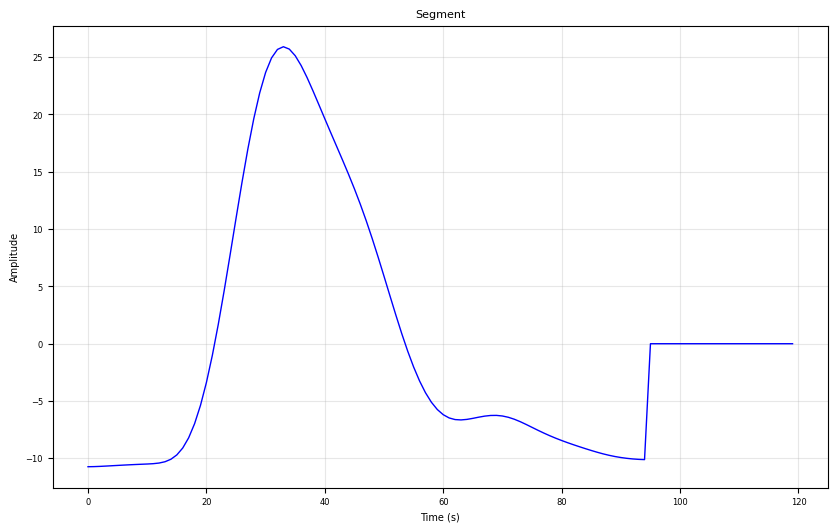

In [18]:
i = 5
j = 100
segments = np.load(output_path1 / files[i])
print(segments.shape)
segment = segments[j, :]

fig1, ax = plt.subplots(figsize=(10, 6))
time = np.arange(len(segment))

ax.plot(time, segment, 'b-', linewidth=1)
ax.set_title(f'Segment', fontsize=8)
ax.set_xlabel('Time (s)', fontsize=7)
ax.set_ylabel('Amplitude', fontsize=7)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=6)

# End